In [1]:
from fhb_helpers import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as patches
from matplotlib import colormaps, colors

import operator
from collections import defaultdict

from dscribe.descriptors import SOAP #, ACSF, LMBTR
#from skmatter.sample_selection import FPS
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from skmatter.preprocessing import StandardFlexibleScaler

import torch
from torch_geometric.nn import fps

from rdkit import Chem
from rdkit.Chem import GetPeriodicTable, rdchem, rdEHTTools, rdmolops, rdDetermineBonds, AllChem, Draw

from ase.io import read, write
import seaborn as sns

In [2]:
# All data containing 2267 complexes and redox potentials
full_data_df = pd.read_csv('./Data/tmqm_redox_data_full_data.csv')

# Mol and smiles of complexes generated directly from tmQM dataset
# This also represents the full redox dataset
tmqm_final_df = pd.read_pickle('./Data/tmc_frm_xyz2mol_tmqm_all_df.pkl')
tmqm_final_df = tmqm_final_df.drop_duplicates(subset='csd_code', keep='first')

# Mol and smiles of complexes generated after semi-impirically optimizing the geometries solvated exlicitly with water and then desolvating
# This also represents the gnn-redox dataset
final_df = pd.read_pickle('./Data/tmc_frm_xyz2mol_desolvated_all_df.pkl')
final_df = final_df.drop_duplicates(subset='csd_code', keep='first')



In [3]:
full_data_df

csd_code  q     Stoichiometry  num_atoms  \
0      HOLHUO  0     C12H14FeN4O10         41   
1      UPOWOO  0     C17H21Cl2FeN3         44   
2      TACSAU  0  C10H16Cl2FeN4Se2         35   
3      LULSET  0      C11H12FeO3S2         29   
4      GESMAW  0       C8H3Br5FeO2         19   
...       ... ..               ...        ...   
2262   REGPEY  1  C30H26FeNOP2(1+)         61   
2263   HIKMIZ  1  C29H33FeNO2P(1+)         67   
2264   SULPAQ  0     C22H21FeNO5Si         51   
2265   ILOMAZ  0    C17H31FeN3OSi2         55   
2266   ZONDAH  0    C31H28ClFeOPSi         64   

                                           ligands_list  tm_oxs  \
0     ['Cc1nc(C(=O)[O-])c(C(=O)O)[nH]1', 'Cc1nc(C(=O...       2   
1     ['CN1Cc2cccc(c2)CN(C)Cc2cccc(n2)C1', '[Cl-]', ...       2   
2     ['Cn1ccn(C)c1=[Se]', 'Cn1ccn(C)c1=[Se]', '[Cl-...       2   
3     ['CC(C)SC(=O)[S-]', '[C-]#[O+]', '[C-]#[O+]', ...       2   
4     ['Brc1c(Br)c(Br)[c-](Br)c1Br', '[C-]#[O+]', '[...       2   
...                                                 ...     ...   
2262  ['[C-]#[O+]', 'c1cc[cH-]c1', 'c1ccc(P(NP(c2ccc...       2   
2263  ['CC(C)N(C(C)C)P1C(c2ccccc2)C=CC1c1ccccc1', '[...       2   
2264  ['CN(C)Cc1ccccc1O[Si-]1Oc2ccccc2O1', '[C-]#[O+...       2   
2265  ['CC([O-])=CC(C)=NCc1ccccn1', 'C[Si](C)(C)[N-]...       2   
2266  ['C[Si-](Cl)c1ccccc1', '[C-]#[O+]', 'c1cc[cH-]...       2   

      ligands_q_list  reduction_pot  
0     [-1, -1, 0, 0]       0.645236  
1        [0, -1, -1]       0.147820  
2     [0, 0, -1, -1]      -0.512239  
3     [-1, 0, 0, -1]       0.900510  
4     [-1, 0, 0, -1]       0.513174  
...              ...            ...  
2262      [0, -1, 0]       1.105673  
2263   [0, 0, 0, -1]       1.560836  
2264  [-1, 0, 0, -1]       1.234285  
2265        [-1, -1]       0.300287  
2266  [-1, 0, -1, 0]       1.235289  

[2267 rows x 8 columns]

In [4]:
final_df

csd_code                                               mol  \
0      ABISOV  <rdkit.Chem.rdchem.Mol object at 0x145e8f05b010>   
1      ABITEM  <rdkit.Chem.rdchem.Mol object at 0x145e8f1b30b0>   
2      ABIVAK  <rdkit.Chem.rdchem.Mol object at 0x145e8f05b150>   
3      ACAZFE  <rdkit.Chem.rdchem.Mol object at 0x145e8f1b31a0>   
4      ACODUR  <rdkit.Chem.rdchem.Mol object at 0x145e8f05b290>   
...       ...                                               ...   
1682   ZORGUL  <rdkit.Chem.rdchem.Mol object at 0x145e8ee78400>   
1683   ZORVOT  <rdkit.Chem.rdchem.Mol object at 0x145e8ee78450>   
1684   ZOVKEC  <rdkit.Chem.rdchem.Mol object at 0x145e8ee78540>   
1685   ZOWLII  <rdkit.Chem.rdchem.Mol object at 0x145e8ee78590>   
1686   ZUYNEM  <rdkit.Chem.rdchem.Mol object at 0x145e8ee785e0>   

                                                 smiles  \
0     S=C=[N-]->[Fe+2]123(<-[N-]=C=S)<-[n]4ccccc4C[N...   
1     S=C=[N-]->[Fe+2]123(<-[N-]=C=S)<-[n]4ccccc4C[N...   
2     S=C=[N-]->[Fe+2]123(<-[N-]=C=S)<-[n]4ccccc4C[N...   
3     CC(=O)c1c[nH][cH-]2->[Fe+2]34(<-[C-]#[O+])(<-[...   
4     N#[C-]->[Fe+2]1234(<-[C-]#[O+])(<-[C-]#[O+])<-...   
...                                                 ...   
1682  O=[N+]([O-])c1cn2[BH-]3n4ccc[n]4->[Fe+2]45(<-[...   
1683  Cc1c(C)[c-]2(C)->[Fe+2]3(<-[C](=O)=[C]->3=C(c3...   
1684  Cc1[c]2(C)->[Fe+2]34(<-[C-]#[O+])(<-[c-]5n(C)c...   
1685  CN1c2ccccc2N2c3ccccc3-c3ccccc3N3c4ccccc4N(C)[C...   
1686  C[N]1(C)CC[N](C)(C)->[Fe+2]<-12(<-[Cl-])<-[N-]...   

                                           desolv_atoms  \
0     (Atom('Fe', [np.float64(9.314544), np.float64(...   
1     (Atom('Fe', [np.float64(7.286369), np.float64(...   
2     (Atom('Fe', [np.float64(-13.328241), np.float6...   
3     (Atom('C', [np.float64(1.89194), np.float64(2....   
4     (Atom('Fe', [np.float64(0.534776), np.float64(...   
...                                                 ...   
1682  (Atom('Fe', [np.float64(-0.241791), np.float64...   
1683  (Atom('Fe', [np.float64(-2.386185), np.float64...   
1684  (Atom('Fe', [np.float64(3.368125), np.float64(...   
1685  (Atom('Fe', [np.float64(7.495714), np.float64(...   
1686  (Atom('Fe', [np.float64(2.351652), np.float64(...   

                                             tmqm_atoms         y  
0     (Atom('Fe', [np.float64(9.45301159474186), np....  0.198685  
1     (Atom('Fe', [np.float64(7.50803351987049), np....  0.354905  
2     (Atom('Fe', [np.float64(-13.19623389441261), n...  0.207419  
3     (Atom('C', [np.float64(2.39653748899036), np.f...  0.945131  
4     (Atom('Fe', [np.float64(0.55217431195427), np....  1.765582  
...                                                 ...       ...  
1682  (Atom('Fe', [np.float64(-0.23539035079073), np...  0.170708  
1683  (Atom('Fe', [np.float64(-2.34276535987453), np...  0.319818  
1684  (Atom('Fe', [np.float64(3.62887408906367), np....  1.178587  
1685  (Atom('Fe', [np.float64(7.7543618396066), np.f...  0.070925  
1686  (Atom('Fe', [np.float64(2.50896709526599), np.... -0.387083  

[1687 rows x 6 columns]

### Filters for the gnn-redox dataset

In [5]:
# Filter out rows in final_df
rows_to_delete = []

for idx, row in final_df.iterrows():
    csd = row['csd_code']
    if csd not in tmqm_final_df['csd_code'].values:
        rows_to_delete.append(idx)
        continue
    mol = row['mol']

    atoms = mol.GetAtoms()
    max_valence = 0
    Fe_charge = None
    for _, atom in enumerate(atoms):
        max_valence = atom.GetDegree() if atom.GetDegree() > max_valence else max_valence
        if atom.GetSymbol() == 'Fe':
            Fe_charge = atom.GetFormalCharge()

    if max_valence > 7:
        if idx not in rows_to_delete:
            rows_to_delete.append(idx)
    if Fe_charge > 3 or Fe_charge < 0:
        if idx not in rows_to_delete:
            rows_to_delete.append(idx)

# Drop rows from the dataframe
final_df = final_df.drop(rows_to_delete).reset_index(drop=True)

In [6]:
len(rows_to_delete)

208

In [7]:
len(final_df)

1479

In [ ]:
from rdkit.Chem.MolStandardize import rdMolStandardize
params = Chem.MolStandardize.rdMolStandardize.MetalDisconnectorOptions()
params.splitAromaticC = True
params.splitGrignards = True
params.adjustCharges = False
MetalNon_Hg = "[#3,#11,#12,#19,#13,#21,#22,#23,#24,#25,#26,#27,#28,#29,#30,#39,#40,#41,#42,#43,#44,#45,#46,#47,#48,#57,#72,#73,#74,#75,#76,#77,#78,#79,#80]~[B,#6,#14,#15,#33,#51,#16,#34,#52,Cl,Br,I,#85]"
mdis = rdMolStandardize.MetalDisconnector(params)
mdis.SetMetalNon(Chem.MolFromSmarts(MetalNon_Hg))

count = 0
rows_to_delete = []

for idx, row in final_df.iterrows():
    csd = row['csd_code']
    if csd not in tmqm_final_df['csd_code'].values:
        rows_to_delete.append(idx)
        continue
    mol = row['mol']
    tmqm_mol = tmqm_final_df[tmqm_final_df['csd_code'] == csd]['mol'].values[0]

    # check number of ligands
    frags = mdis.Disconnect(mol)
    tmqm_frags = mdis.Disconnect(tmqm_mol)

    frag_mols = rdmolops.GetMolFrags(frags, asMols=True)
    tmqm_frag_mols = rdmolops.GetMolFrags(tmqm_frags, asMols=True)
    if len(frag_mols) != len(tmqm_frag_mols):
        if idx not in rows_to_delete:
            print(f"Skipping {csd} due to different number of ligands: {len(frag_mols)} vs {len(tmqm_frag_mols)}")
            rows_to_delete.append(idx)
            count += 1
    
print(f"Total rows to delete: {count}")
# Drop rows from the dataframe
final_df = final_df.drop(rows_to_delete).reset_index(drop=True)

In [9]:
len(rows_to_delete)

29

In [10]:
len(final_df)

1450

In [12]:
print(f"Total rows to delete: {count}")

final_df

Total rows to delete: 29


csd_code                                               mol  \
0      ABISOV  <rdkit.Chem.rdchem.Mol object at 0x145e8f05b010>   
1      ABITEM  <rdkit.Chem.rdchem.Mol object at 0x145e8f1b30b0>   
2      ABIVAK  <rdkit.Chem.rdchem.Mol object at 0x145e8f05b150>   
3      ACAZFE  <rdkit.Chem.rdchem.Mol object at 0x145e8f1b31a0>   
4      ACUZII  <rdkit.Chem.rdchem.Mol object at 0x145e8f05b3d0>   
...       ...                                               ...   
1445   ZOMKAR  <rdkit.Chem.rdchem.Mol object at 0x145e8ee78360>   
1446   ZORGUL  <rdkit.Chem.rdchem.Mol object at 0x145e8ee78400>   
1447   ZOVKEC  <rdkit.Chem.rdchem.Mol object at 0x145e8ee78540>   
1448   ZOWLII  <rdkit.Chem.rdchem.Mol object at 0x145e8ee78590>   
1449   ZUYNEM  <rdkit.Chem.rdchem.Mol object at 0x145e8ee785e0>   

                                                 smiles  \
0     S=C=[N-]->[Fe+2]123(<-[N-]=C=S)<-[n]4ccccc4C[N...   
1     S=C=[N-]->[Fe+2]123(<-[N-]=C=S)<-[n]4ccccc4C[N...   
2     S=C=[N-]->[Fe+2]123(<-[N-]=C=S)<-[n]4ccccc4C[N...   
3     CC(=O)c1c[nH][cH-]2->[Fe+2]34(<-[C-]#[O+])(<-[...   
4     CC1(C)O[C-](=O)->[Fe+2](<-[C-]#[O+])(<-[C-]#[O...   
...                                                 ...   
1445  CN(C)C(N(C)C)=[N]1CCC[N](=C(N(C)C)N(C)C)->[Fe+...   
1446  O=[N+]([O-])c1cn2[BH-]3n4ccc[n]4->[Fe+2]45(<-[...   
1447  Cc1[c]2(C)->[Fe+2]34(<-[C-]#[O+])(<-[c-]5n(C)c...   
1448  CN1c2ccccc2N2c3ccccc3-c3ccccc3N3c4ccccc4N(C)[C...   
1449  C[N]1(C)CC[N](C)(C)->[Fe+2]<-12(<-[Cl-])<-[N-]...   

                                           desolv_atoms  \
0     (Atom('Fe', [np.float64(9.314544), np.float64(...   
1     (Atom('Fe', [np.float64(7.286369), np.float64(...   
2     (Atom('Fe', [np.float64(-13.328241), np.float6...   
3     (Atom('C', [np.float64(1.89194), np.float64(2....   
4     (Atom('Fe', [np.float64(13.442061), np.float64...   
...                                                 ...   
1445  (Atom('Fe', [np.float64(9.511264), np.float64(...   
1446  (Atom('Fe', [np.float64(-0.241791), np.float64...   
1447  (Atom('Fe', [np.float64(3.368125), np.float64(...   
1448  (Atom('Fe', [np.float64(7.495714), np.float64(...   
1449  (Atom('Fe', [np.float64(2.351652), np.float64(...   

                                             tmqm_atoms         y  
0     (Atom('Fe', [np.float64(9.45301159474186), np....  0.198685  
1     (Atom('Fe', [np.float64(7.50803351987049), np....  0.354905  
2     (Atom('Fe', [np.float64(-13.19623389441261), n...  0.207419  
3     (Atom('C', [np.float64(2.39653748899036), np.f...  0.945131  
4     (Atom('Fe', [np.float64(13.76449478713283), np...  2.261145  
...                                                 ...       ...  
1445  (Atom('Fe', [np.float64(9.85343477883966), np.... -0.082576  
1446  (Atom('Fe', [np.float64(-0.23539035079073), np...  0.170708  
1447  (Atom('Fe', [np.float64(3.62887408906367), np....  1.178587  
1448  (Atom('Fe', [np.float64(7.7543618396066), np.f...  0.070925  
1449  (Atom('Fe', [np.float64(2.50896709526599), np.... -0.387083  

[1450 rows x 6 columns]

# Analysing the full redox dataset using tmqm_final_df

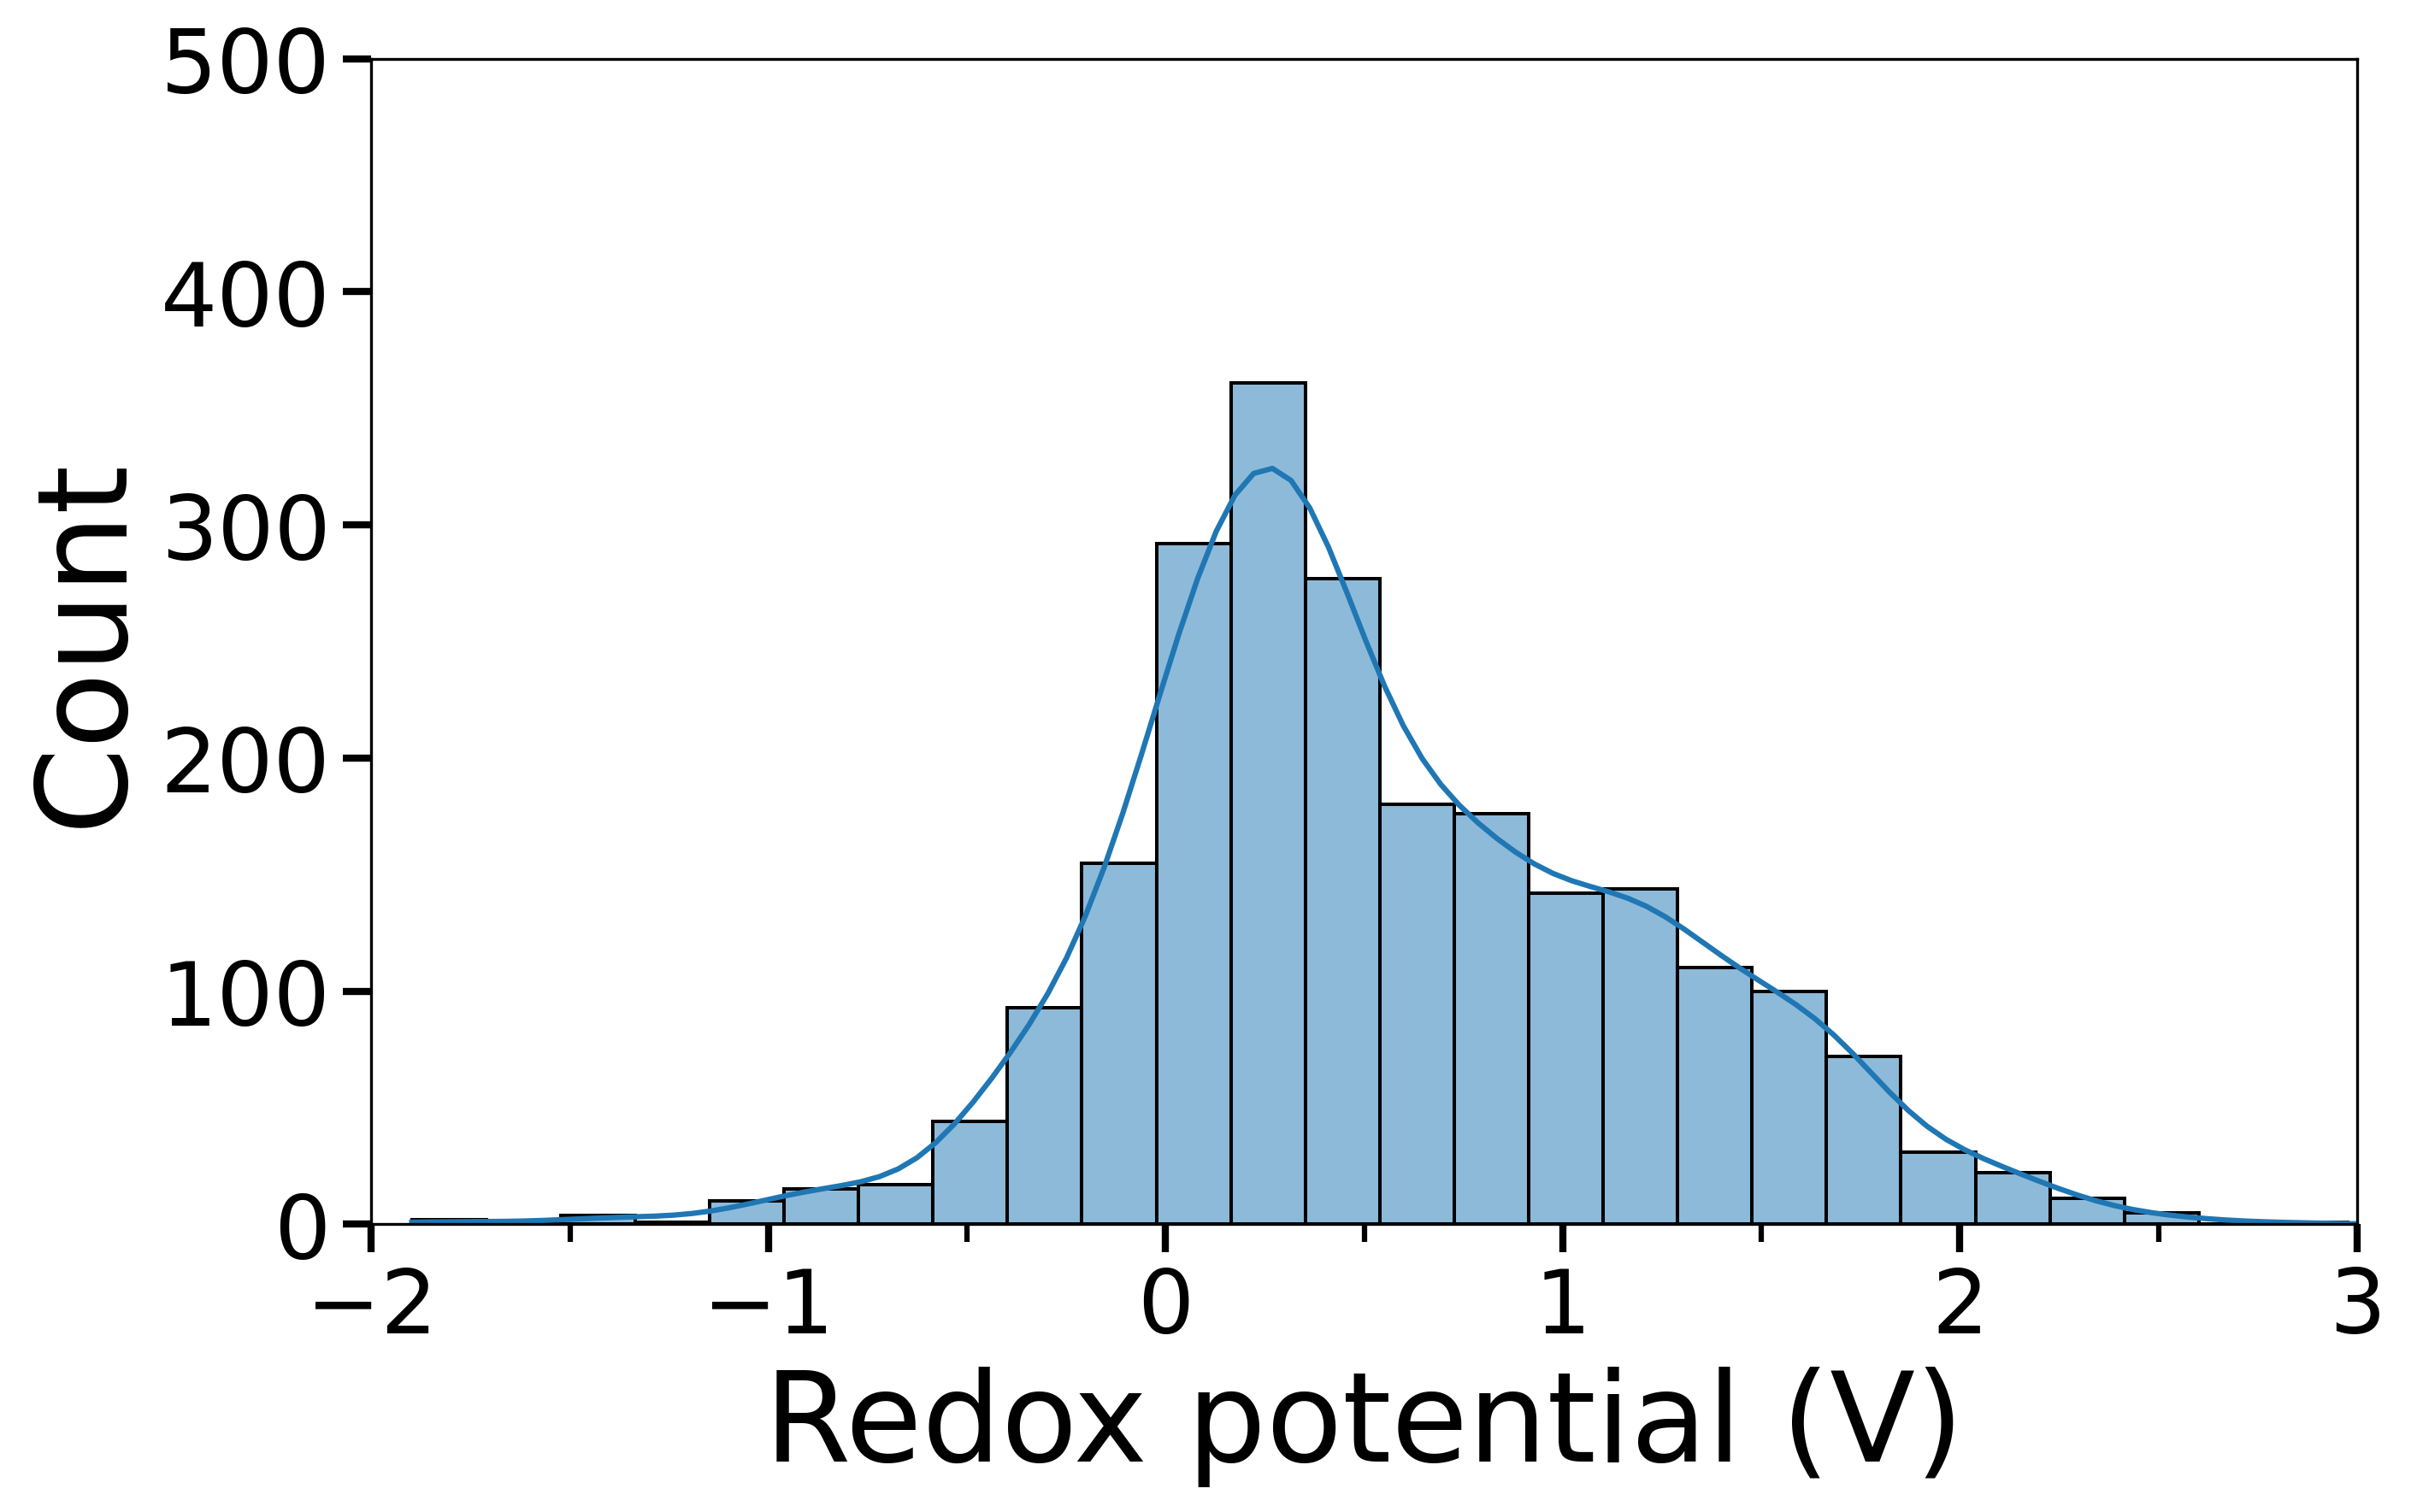

In [13]:
# Plot histogram for entire dataset

# tmqm_redox_combined_df

from matplotlib.ticker import AutoMinorLocator # Import AutoMinorLocator


plt.figure(figsize=(9.5, 6), dpi=300) # Optional: sets the figure size

ax = sns.histplot(full_data_df['reduction_pot'], kde=True, bins=50) # Get the axes object

#plt.title('Histogram of final_df[\'y\']')
plt.xlabel('Redox potential (V)', fontsize=35)
plt.xlim([-2,3])
plt.xticks(fontsize=25)

plt.ylabel('Count', fontsize=35)
plt.ylim([0,500])
plt.yticks(fontsize=25)

ax.yaxis.set_major_locator(plt.MaxNLocator(5))  # Set major ticks to a maximum of 6
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.tick_params(which='major', length=8, width=2)
ax.tick_params(axis='x', which='minor', length=5, width=1.5)

#plt.grid(axis='y', alpha=0.75) # Optional: adds a grid

plt.tight_layout()
plt.savefig('./Figures/Redox_hist_fulldata.png', transparent=True)

# Morgan FP: PCA

### Defining the functions

In [14]:
# Calculating mfp PCA and tsne
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from skmatter.preprocessing import StandardFlexibleScaler
from rdkit.Chem import AllChem, rdchem, rdFingerprintGenerator
import sklearn.ensemble

def get_rf_feature_mask(x: np.ndarray,
                        y: np.ndarray,
                        n_features: int = None,
                        rf_model: sklearn.ensemble.RandomForestRegressor = None,
                        **rf_params) -> np.ndarray:
    """
    Trains a RandomForestRegressor and returns a boolean mask for the
    top 'n_features' most important features.

    Args:
        x (np.ndarray): Input features (e.g., fingerprints), shape (n_samples, n_original_features).
        y (np.ndarray): Target variable, shape (n_samples,).
        n_features (int, optional): The number of top features to select.
            If None or >= x.shape[1], a mask selecting all features is returned.
            Defaults to None.
        rf_model (RandomForestRegressor, optional): A pre-initialized
            RandomForestRegressor instance. If None, a new one is created.
            Defaults to None.
        **rf_params: Additional keyword arguments passed to the
                     RandomForestRegressor constructor if rf_model is None
                     (e.g., n_estimators=100, random_state=42).

    Returns:
        np.ndarray: A boolean mask of shape (n_original_features,) where True
                    indicates a selected feature.

    Raises:
        ValueError: If n_features is greater than the number of features in x.
    """
    n_samples, n_original_features = x.shape

    if n_features is None:
        n_features = n_original_features # Select all if None
        print(f"n_features not specified, selecting all {n_original_features} features.")

    if n_features > n_original_features:
        raise ValueError(f'n_features={n_features} cannot be larger than '
                         f'the original number of features ({n_original_features})')
    elif n_features == n_original_features:
        print(f"n_features ({n_features}) equals original features. Selecting all.")
        return np.ones(n_original_features, dtype=bool)
    else:
        # --- Core RF Feature Selection ---
        print(f"Selecting top {n_features} features using RandomForestRegressor...")
        if rf_model is None:
            # Provide sensible defaults or allow passing via **rf_params
            rf_params_default = {'n_estimators': 300, 'n_jobs': -1, 'random_state': 42}
            rf_params_default.update(rf_params) # Overwrite defaults with user params
            print(f"  Creating RandomForestRegressor with params: {rf_params_default}")
            rf = sklearn.ensemble.RandomForestRegressor(**rf_params_default)
        else:
            print("  Using provided RandomForestRegressor model.")
            rf = rf_model

        # Ensure y is 1D array for RF regressor
        if y.ndim > 1 and y.shape[1] == 1:
            y = y.ravel()

        rf.fit(x, y)
        importances = rf.feature_importances_

        # Get indices of top k features (indices sorted by importance descending)
        # Using np.argsort directly on negative importance
        indices = (-importances).argsort()[:n_features]

        # Create boolean mask
        mask = np.zeros(n_original_features, dtype=bool)
        mask[indices] = True
        print(f"  Generated mask selecting {mask.sum()} features.")
        return mask
    

def get_masked_mfp(mfp_descriptors_full, y, n_features, random_state=42):
    mask = get_rf_feature_mask(mfp_descriptors_full, y, n_features=n_features, random_state=random_state)
    return mfp_descriptors_full[:, mask]

def pca_from_mfp(mfp_descriptors, y=None, n_components=2, n_features=-1, copy=True):
    pca = PCA(n_components=n_components, copy=copy)
    if n_features == -1:
        mfp_pca = pca.fit_transform(mfp_descriptors)
    elif n_features > -1:
        if y is not None:
            mfp_pca = pca.fit_transform(get_masked_mfp(mfp_descriptors, y, n_features))
        else:
            print('Provide target y')
            return None
    else:
        print('n_features must be -1 or above')
        return None
    return mfp_pca

def tsne_from_mfp(mfp_descriptors, y=None, n_components=2, n_features=-1, random_state=42):
    tsne = TSNE(n_components=n_components, random_state=random_state)
    if n_features == -1:
        mfp_tsne = tsne.fit_transform(mfp_descriptors)
    elif n_features > -1:
        if y is not None:
            mfp_tsne = tsne.fit_transform(get_masked_mfp(mfp_descriptors, y, n_features))
        else:
            print('Provide target y')
            return None
    else:
        print('n_features must be -1 or above')
        return None
    return mfp_tsne

In [15]:
def get_descriptor_object(atoms):
    chosen_descriptor = SOAP # other options: ACSF, LMBTR
    
    global_args = {
        "species": list(set(atoms.get_atomic_numbers())), #[type for type in set(atoms.get_atomic_numbers())],
        "periodic": False,
        "average": "off",
        "sparse": False,
        "dtype": "float32",
    }

    SOAP_HYPERS = {
    "interaction_cutoff": 5.0,
    "max_radial": 6,
    "max_angular": 6,
    "gaussian_sigma_constant": 0.5,
    "cutoff_smooth_width": 0.3,
    "gaussian_sigma_type": "Constant",
    }

    # if using ACSF, LMBTR instead of SOAP, define specific hyper parameters if needed
    soap_specific_hypers = {
        "r_cut": 3,
        "n_max": 4,
        "l_max": 4
    }

    args = {}
    args.update(global_args)
    args.update(soap_specific_hypers)

    return chosen_descriptor(**args)

### Calculating PCA

In [16]:
from rdkit.Chem import AllChem, rdchem, rdFingerprintGenerator

def compute_morgan_fingerprint(mol, radius=3, fpSize=2048):
    mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=radius,fpSize=fpSize)
    morgan_fp = mfpgen.GetFingerprint(mol) # Get the fingerprint object
    # Convert ExplicitBitVect to NumPy array
    np_fp = np.array(list(morgan_fp))#, dtype=float)
    return np_fp # Return the NumPy array


descriptors = None

for i,mol in enumerate(tmqm_final_df['mol']):
    x = compute_morgan_fingerprint(mol)
    if i == 0:
        descriptors = np.zeros((len(tmqm_final_df), x.shape[-1]))
    descriptors[i]=x

mfp_descriptors_scaled_full = StandardFlexibleScaler(column_wise=False).fit_transform(descriptors)

target_y = tmqm_final_df['y'].values

mfp_pca_calculated_full = pca_from_mfp(mfp_descriptors_scaled_full) 
mfp_pca_calculated_256 = pca_from_mfp(mfp_descriptors_scaled_full, y = target_y, n_features=256) 
mfp_pca_calculated_128 = pca_from_mfp(mfp_descriptors_scaled_full, y = target_y, n_features=128) 
mfp_pca_calculated_64 = pca_from_mfp(mfp_descriptors_scaled_full, y = target_y, n_features=64)


#mfp_tsne_calculated_full = tsne_from_mfp(mfp_descriptors_scaled_full) 
#mfp_tsne_calculated_256 = tsne_from_mfp(mfp_descriptors_scaled_full, y = target_y, n_features=256)
#mfp_tsne_calculated_128 = tsne_from_mfp(mfp_descriptors_scaled_full, y = target_y, n_features=128)
#mfp_tsne_calculated_64 = tsne_from_mfp(mfp_descriptors_scaled_full, y = target_y, n_features=64)

/home/fbhuiyan/.local/sophia/conda/2024-08-08/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/fbhuiyan/.local/sophia/conda/2024-08-08/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Selecting top 256 features using RandomForestRegressor...
  Creating RandomForestRegressor with params: {'n_estimators': 300, 'n_jobs': -1, 'random_state': 42}
  Generated mask selecting 256 features.
Selecting top 128 features using RandomForestRegressor...
  Creating RandomForestRegressor with params: {'n_estimators': 300, 'n_jobs': -1, 'random_state': 42}
  Generated mask selecting 128 features.
Selecting top 64 features using RandomForestRegressor...
  Creating RandomForestRegressor with params: {'n_estimators': 300, 'n_jobs': -1, 'random_state': 42}
  Generated mask selecting 64 features.


Running KMeans clustering on PCA data with k=2...
Assigned cluster labels (0 to 1) to 2147 molecules.
Cluster distribution: Counter({np.int32(1): 1254, np.int32(0): 893})
Cluster Info:
Cluster 0: 893 points, average = 1.05, std = 0.61
Cluster 1: 1254 points, average = 0.24, std = 0.48

Identified 129 potential outlier points based on criteria.

Original DataFrame indices of identified outlier points:
[17, 24, 27, 36, 53, 63, 65, 74, 78, 85, 87, 93, 95, 98, 102, 123, 130, 132, 141, 148, 152, 172, 173, 176, 186, 194, 214, 257, 270, 308, 314, 319, 329, 339, 355, 410, 415, 434, 437, 445, 447, 451, 454, 456, 492, 530, 552, 565, 571, 576, 588, 607, 619, 649, 666, 699, 710, 749, 761, 767, 794, 801, 808, 825, 826, 829, 847, 892, 935, 936, 947, 949, 951, 966, 969, 989, 996, 1005, 1128, 1144, 1157, 1159, 1163, 1178, 1216, 1229, 1250, 1291, 1325, 1332, 1363, 1383, 1385, 1410, 1416, 1429, 1431, 1434, 1437, 1443, 1467, 1487, 1521, 1542, 1569, 1601, 1605, 1626, 1631, 1654, 1701, 1727, 1751, 1758, 17

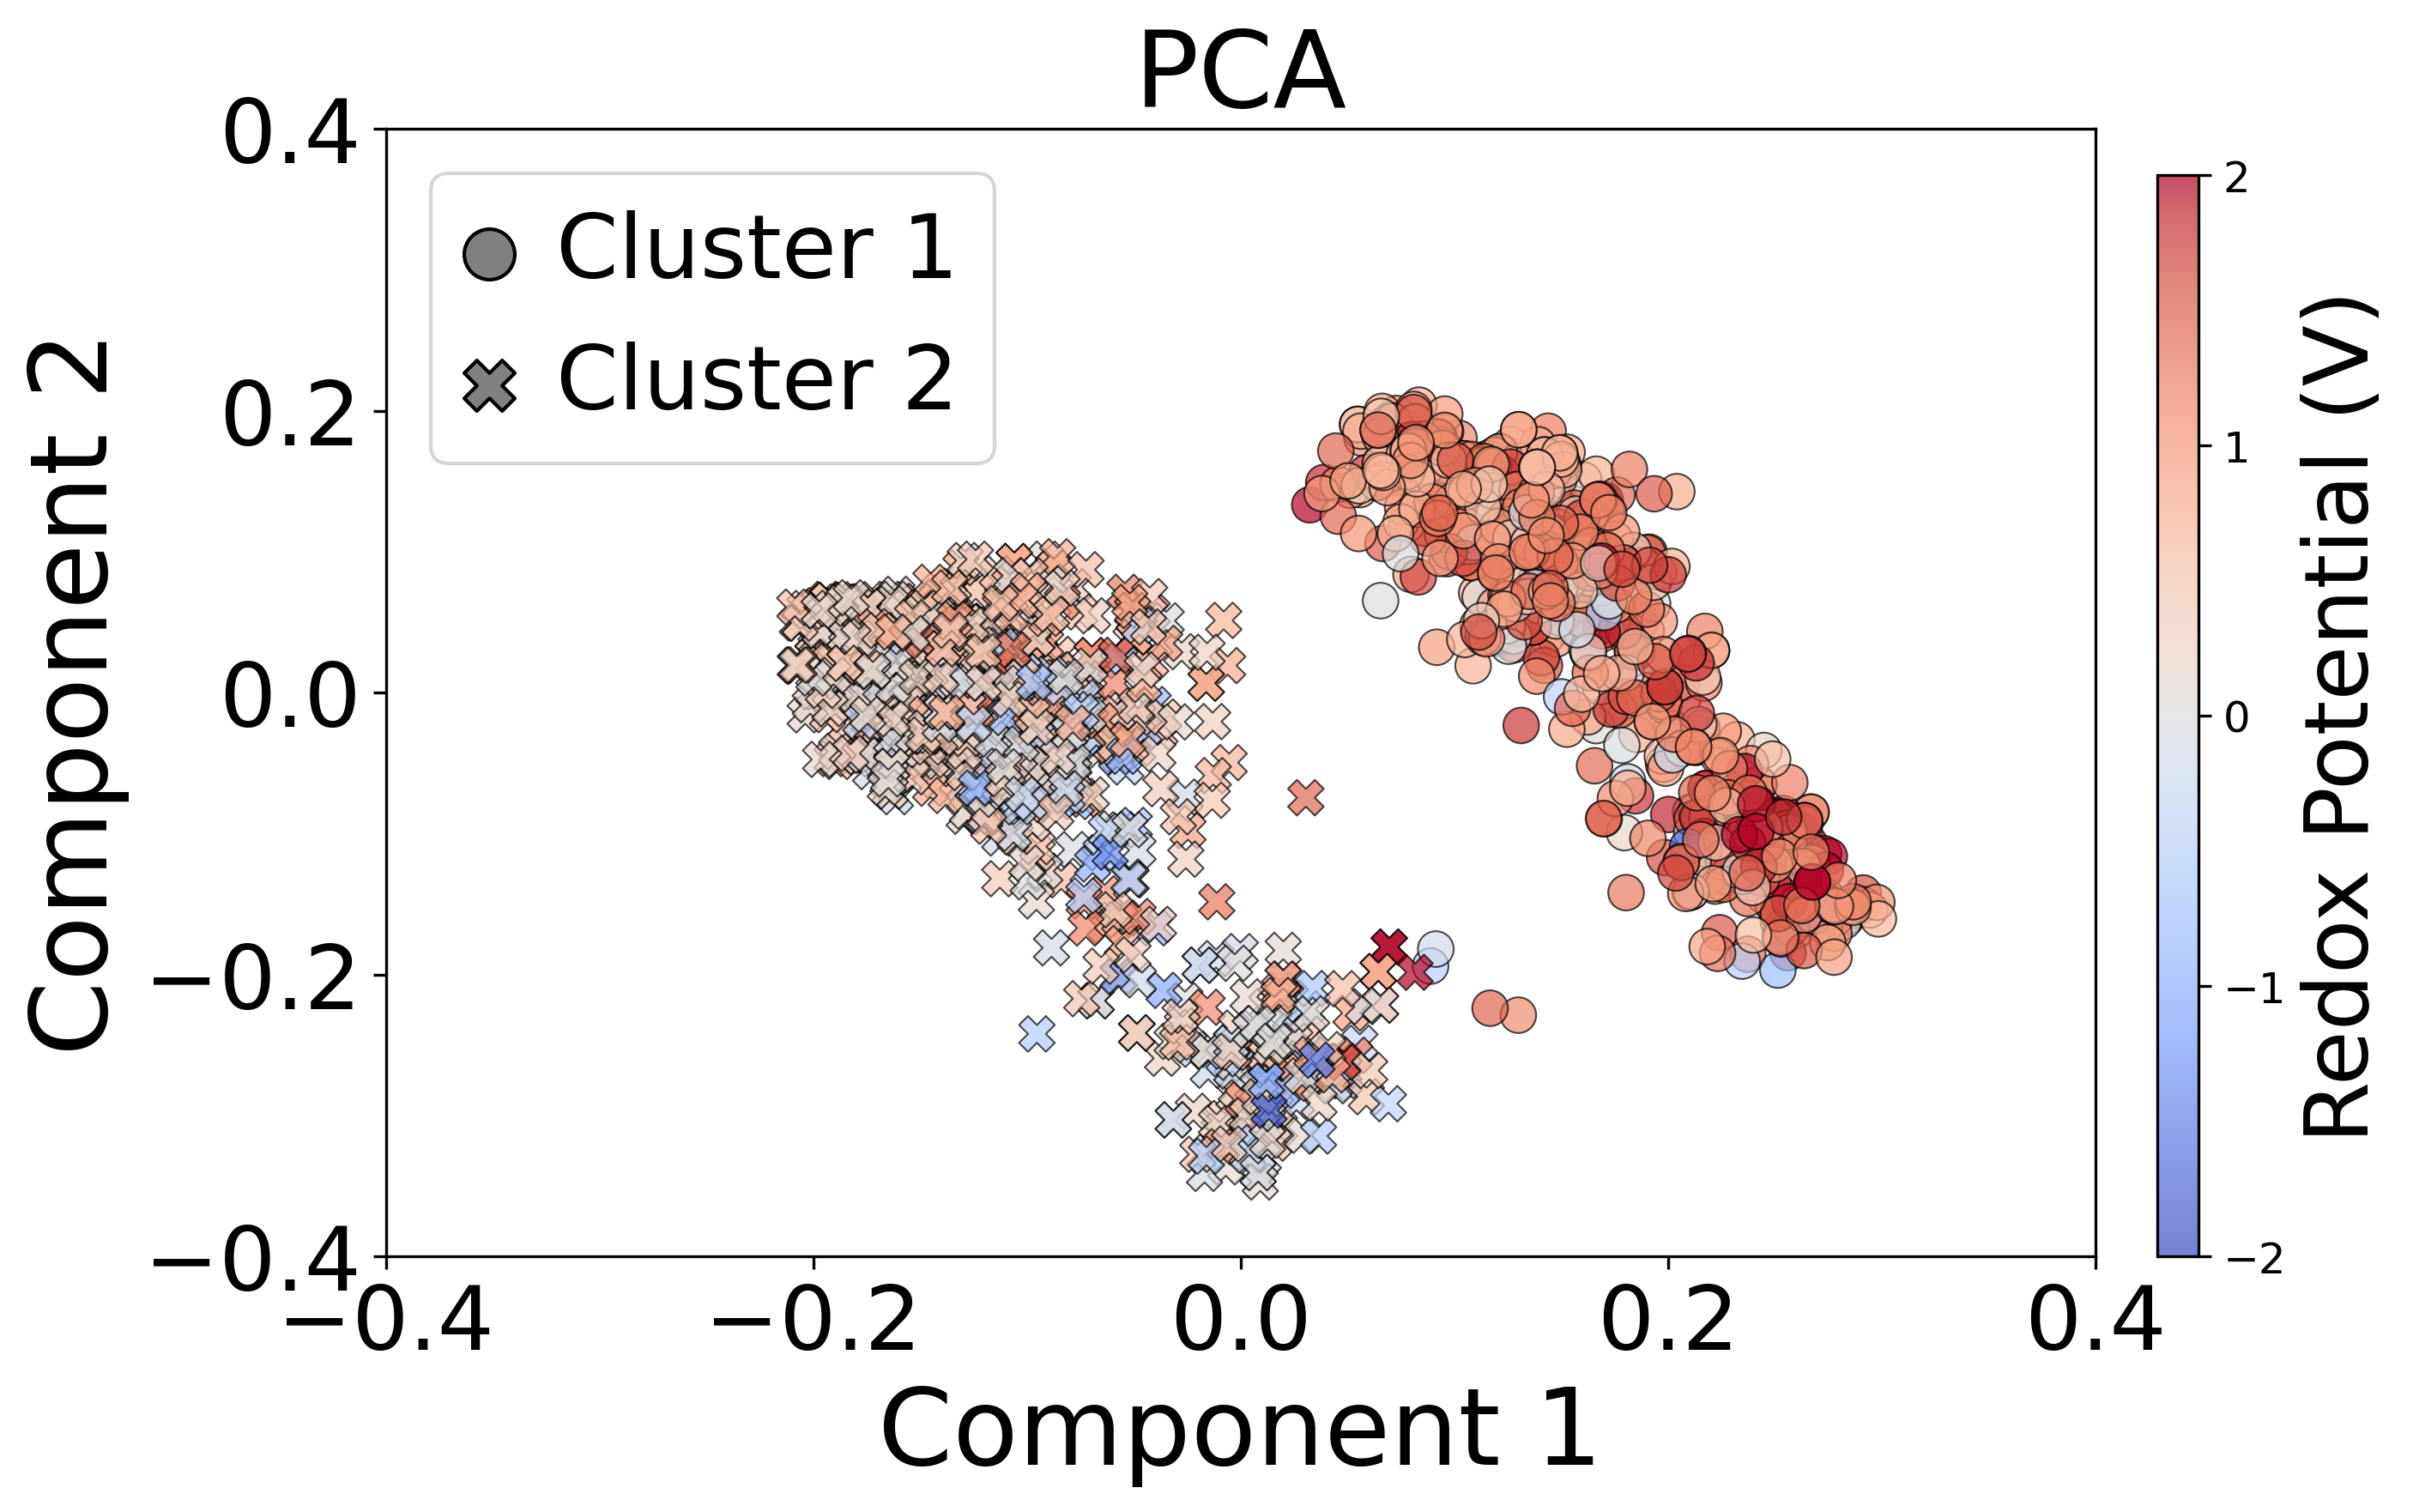

In [17]:
 # Import patches for circles
from sklearn.cluster import KMeans
from collections import Counter
import copy

pca_2_plot = mfp_pca_calculated_64
df2use = copy.deepcopy(tmqm_final_df) 

# --- 1. Cluster the PCA Data ---
n_clusters = 2
print(f"Running KMeans clustering on PCA data with k={n_clusters}...")
kmeans = KMeans(n_clusters=n_clusters, n_init = 'auto', max_iter=500, tol=0.00001, random_state=52)
cluster_labels = kmeans.fit_predict(pca_2_plot)
df2use['pca_cluster'] = cluster_labels
print(f"Assigned cluster labels (0 to {n_clusters-1}) to {len(df2use)} molecules.")
print("Cluster distribution:", Counter(cluster_labels))

# --- calculate avg of clusters ---- #
# --- Identify Outlier Indices ---
color_data_np = df2use['y'].to_numpy() # Ensure color data is numpy array for masking
cluster_labels_np = df2use['pca_cluster'].to_numpy() # Ensure cluster labels is numpy array

# Condition 1: Cluster 0
mask_c0 = (cluster_labels_np == 0) 
# Condition 2: Cluster 1
mask_c1 = (cluster_labels_np == 1)

cluster_0_idxs = np.where(mask_c0)[0]
cluster_1_idxs = np.where(mask_c1)[0]

# Clusters
cluster_0_y = df2use.y[cluster_0_idxs].to_numpy()
cluster_1_y = df2use.y[cluster_1_idxs].to_numpy()

print(f"Cluster Info:")
print(f"Cluster 0: {len(cluster_0_y)} points, average = {np.mean(cluster_0_y):.2f}, std = {np.std(cluster_0_y):.2f}")
print(f"Cluster 1: {len(cluster_1_y)} points, average = {np.mean(cluster_1_y):.2f}, std = {np.std(cluster_1_y):.2f}")

# --- Identify Outlier Indices ---
#color_data_np = df2use['y'].to_numpy() # Ensure color data is numpy array for masking
#cluster_labels_np = df2use['pca_cluster'].to_numpy() # Ensure cluster labels is numpy array

c0_thresh = 0.25 #-0.8
c1_thresh = 1.1 #1.8
outlier_mask_c0 = (cluster_labels_np == 0) & (color_data_np < c0_thresh)
# Condition 2: Cluster 1 AND y > 1
outlier_mask_c1 = (cluster_labels_np == 1) & (color_data_np > c1_thresh)

# Combine masks
outlier_mask = outlier_mask_c0 | outlier_mask_c1

# Get the indices within the DataFrame/numpy arrays for these outliers
outlier_indices = np.where(outlier_mask)[0] # Gets the indices where outlier_mask is True

# Store the original identifiers (e.g., DataFrame index or 'csd_code')
outlier_original_indices = df2use.index[outlier_indices].tolist()

print(f"\nIdentified {len(outlier_indices)} potential outlier points based on criteria.")
# print("Original indices/identifiers of outliers:", outlier_original_indices) # Keep this line if you need the IDs

outlier_smiles_c0 = df2use.smiles[np.where(outlier_mask_c0)[0]].tolist()
outlier_smiles_c1 = df2use.smiles[np.where(outlier_mask_c1)[0]].tolist()


# --- Plotting Setup ---

color_data = df2use['y'] 
color_value_min = -2; color_value_max = 2; colormap = 'coolwarm'
marker_size = 100; marker_alpha = 0.7; marker_edgecolor = 'k'; marker_linewidth = 0.5
markers = {0: 'o', 1: 'X'}; cluster_legend_labels = {0: 'Cluster 1', 1: 'Cluster 2'}

# Create the figure and the subplots
fig, ax = plt.subplots(figsize=(8, 6), dpi = 300)
#axes = axes.flatten()

# Data and titles
plot_data = [(pca_2_plot, "PCA")] #, (mfp_tsne_calculated_128, "TSNE")]
pca_xlim = [-0.4, 0.4]; pca_ylim = [-0.4, 0.4]
tsne_xlim = [-60, 60]; tsne_ylim = [-40, 40]
plot_limits = [(pca_xlim, pca_ylim)] #, (tsne_xlim, tsne_ylim)]


# --- Loop through data and create each subplot ---
mappable = None
proxy_handles_dict = {}

for i, ((data, title), (xlim, ylim)) in enumerate(zip(plot_data, plot_limits)):
    #ax = axes[i]

    # Iterate through each cluster to plot with different markers
    for cluster_id in range(n_clusters):
        cluster_mask = (cluster_labels == cluster_id)
        if not np.any(cluster_mask): continue

        x_cluster = data[cluster_mask, 0]
        y_cluster = data[cluster_mask, 1]
        # Use the mask directly on the pandas Series or numpy array
        color_data_cluster = color_data[cluster_mask]

        scatter_plot = ax.scatter(
            x=x_cluster, y=y_cluster, c=color_data_cluster, cmap=colormap,
            vmin=color_value_min, vmax=color_value_max, s=marker_size,
            alpha=marker_alpha, edgecolor=marker_edgecolor,
            linewidth=marker_linewidth, marker=markers[cluster_id],
            label="_nolegend_"
        )
        if i == 0 and cluster_id == 0: mappable = scatter_plot
        if i == 0 and cluster_id not in proxy_handles_dict:
             proxy_handles_dict[cluster_id] = ax.scatter([],[], marker=markers[cluster_id], label=cluster_legend_labels[cluster_id],
                                                        edgecolor=marker_edgecolor, linewidth=marker_linewidth+0.5,
                                                        s=marker_size*2, c='gray')

    # --- Draw Circles Around Outliers for this plot ---
    # Get the PCA/TSNE coordinates specifically for the outlier points
    outlier_coords_this_plot = data[outlier_indices]
    # Plot circles around outlier points
    '''for x_outlier, y_outlier in outlier_coords_this_plot:
        outlier_point_cluster = cluster_labels_np[np.where((data[:,0] == x_outlier) & (data[:,1] == y_outlier))[0][0]] # Find cluster of this point - bit complex

        # Or just use a single outlier style
        scale = 0.004 #if title == 'PCA' else 0.03
        c = 'r' if outlier_point_cluster == 0 else 'b' 
        circle = patches.Circle((x_outlier, y_outlier), radius=xlim[1]*scale, # Radius relative to axis range
                                edgecolor=c, 
                                facecolor='none',
                                linestyle='--', # Dotted line style
                                linewidth=1.1,
                                label='_nolegend_')
        ax.add_patch(circle)'''
    # --- End Outlier Circles ---


    # Add labels and title for the specific subplot
    ax.set_xlim(xlim); ax.set_ylim(ylim)
    ax.xaxis.set_major_locator(ticker.LinearLocator(numticks=5))
    ax.yaxis.set_major_locator(ticker.LinearLocator(numticks=5))
    ax.set_xlabel("Component 1", fontsize=30)
    if i == 0: ax.set_ylabel("Component 2", fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=25)
    ax.set_title(title, fontsize=30)
    #ax.grid(True, linestyle='--', alpha=0.4)

# --- Create Legend for the First Plot Only ---
if proxy_handles_dict:
    sorted_handles = [proxy_handles_dict[cid] for cid in sorted(proxy_handles_dict.keys())]
    ax.legend(handles=sorted_handles, loc='upper left', handlelength=0.5, handletextpad=0.5, fontsize=25,) # title="Kmeans clusters", title_fontsize=20)


# --- Add Colorbar ---
if mappable:
    cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(mappable, cax=cbar_ax, label='Redox Potential')
    cbar.set_label('Redox Potential (V)', fontsize=25)
    cbar.ax.yaxis.set_major_locator(ticker.LinearLocator(numticks=5))
    cbar.ax.tick_params(labelsize=12)


# --- Adjust Layout ---
fig.subplots_adjust(left=0.07, right=0.9, top=0.88, bottom=0.15, wspace=0.17, hspace=0.3)
#plt.tight_layout()
plt.savefig('./Figures/PCA_clusters_fulldata.png', transparent=True, bbox_inches='tight')


# --- The outlier indices you wanted ---
print("\nOriginal DataFrame indices of identified outlier points:")
print(outlier_original_indices)


In [18]:
# print min, max, mean, std of clusters
print(f"Cluster 1: min={np.min(cluster_0_y):.2f}, max={np.max(cluster_0_y):.2f}, mean={np.mean(cluster_0_y):.2f}, std={np.std(cluster_0_y):.2f}")
print(f"Cluster 2: min={np.min(cluster_1_y):.2f}, max={np.max(cluster_1_y):.2f}, mean={np.mean(cluster_1_y):.2f}, std={np.std(cluster_1_y):.2f}")

Cluster 1: min=-1.76, max=2.81, mean=1.05, std=0.61
Cluster 2: min=-1.90, max=7.48, mean=0.24, std=0.48


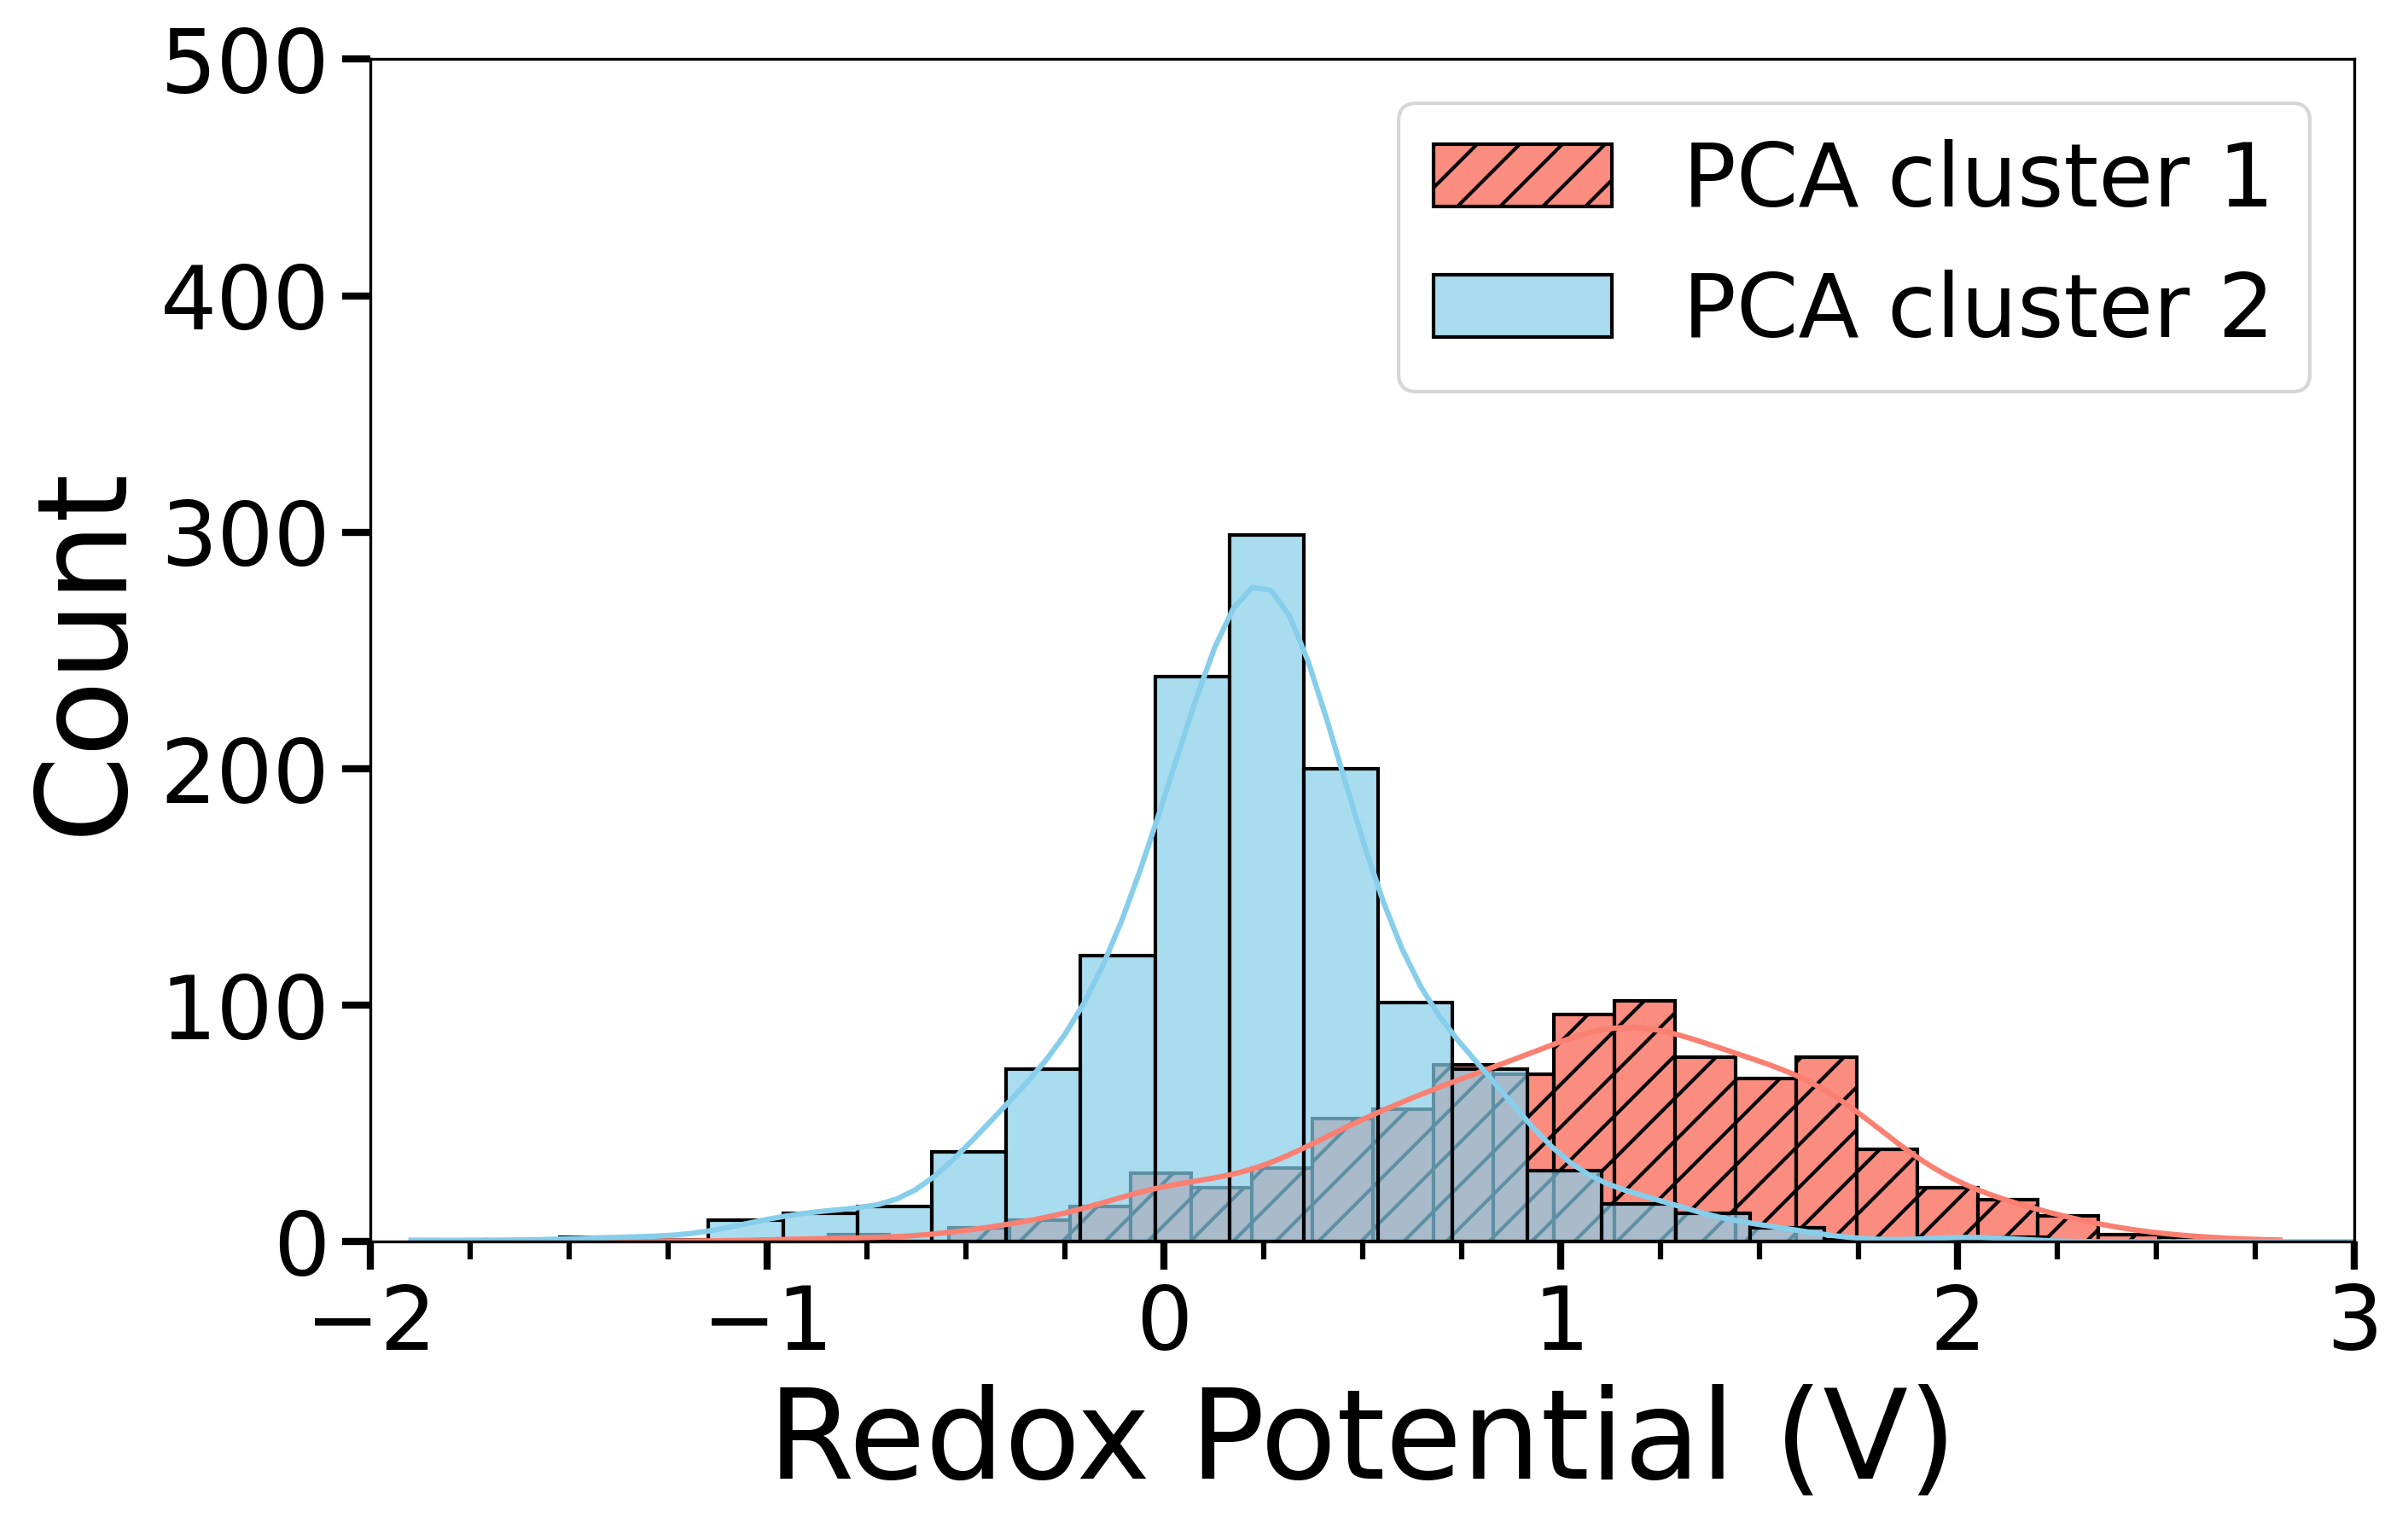

In [19]:
# histogram of the clusters

plt.figure(figsize=(10, 6), dpi=300)

# --- Plot Histogram for Cluster 0 ---
# Use alpha for transparency if histograms overlap
# Use a distinct color for each cluster
# The `ax` will be created by the first histplot call
ax = sns.histplot(cluster_0_y, kde=True, bins=30, label='PCA cluster 1', color='salmon', alpha=0.9, hatch='//')

# --- Plot Histogram for Cluster 1 on the SAME Axes ---
sns.histplot(cluster_1_y, kde=True, bins=50, label='PCA cluster 2', color='skyblue', alpha=0.7, ax=ax) # Pass the same 'ax'

# Add labels and title
plt.xlabel('Redox Potential (V)', fontsize=35)
plt.xlim([-2, 3])
plt.xticks(fontsize=25)

plt.ylabel('Count', fontsize=35)
plt.ylim([0,500])
plt.yticks(fontsize=25)

plt.legend(fontsize=25)

# Apply tick formatting 
ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=5)) # Set number of major ticks
ax.xaxis.set_minor_locator(AutoMinorLocator(4)) # 3 minor ticks between major ticks
ax.tick_params(which='major', length=8, width=2)
ax.tick_params(axis='x', which='minor', length=5, width=1.5)

# plt.grid(axis='y', alpha=0.75) # Optional
plt.savefig('./Figures/Redox_hist_clusters_fulldata.png', transparent=True, bbox_inches='tight')

### Ligand classifications

In [20]:
from rdkit import Chem
from rdkit.Chem import Fragments # Use Fragments submodule for fr_halogen

def get_ligand_smiles_after_fe_removal(mol):
    """
    Finds and removes the first 'Fe' atom from an RDKit molecule
    and returns the SMILES strings of the resulting fragments.

    Args:
        mol: An RDKit molecule object.

    Returns:
        A list of SMILES strings for the fragments remaining after
        removing the 'Fe' atom. Returns an empty list if no 'Fe'
        atom is found or if no fragments remain.
    """
    if not mol:
        print("Warning: Received an invalid molecule object.")
        return []

    fe_index = -1
    # Find the index of the first Fe atom
    for atom in mol.GetAtoms():
        if atom.GetSymbol() == 'Fe':
            fe_index = atom.GetIdx()
            break # Stop after finding the first one

    if fe_index == -1:
        # print("Info: No 'Fe' atom found in the molecule.")
        # If no Fe, the "fragments after removal" is an empty concept
        return []

    # Create an editable copy of the molecule
    rwmol = Chem.RWMol(mol)

    # Remove the Fe atom using its index
    rwmol.RemoveAtom(fe_index)

    # Convert back to a standard Mol object
    mol_without_fe = rwmol.GetMol()

    if not mol_without_fe:
        # This might happen if the original molecule was just [Fe]
        return []

    # Get the disconnected fragments as separate Mol objects
    # sanitizeFrags=True attempts to clean up valences etc. in the fragments
    fragments = Chem.GetMolFrags(mol_without_fe, asMols=True, sanitizeFrags=False)

    #assert len(fragments) > len(Chem.GetMolFrags(mol_without_fe, asMols=True, sanitizeFrags=False)), "Some fragments were not sanitized."

    # Convert each fragment molecule to SMILES
    fragment_smiles = [Chem.MolToSmiles(Chem.MolFromSmiles(Chem.MolToSmiles(frag))) for frag in fragments]

    return fragment_smiles

# RDKit to check if *any* atom is aromatic.
def is_molecule_aromatic(mol):
    """Checks if any atom in the molecule is aromatic."""
    if not mol:
        return False
    for atom in mol.GetAtoms():
        if atom.GetIsAromatic():
            return True
    return False

def classify_smiles(smiles_string, inorganic_list, halogen_list):
    """
    Classifies a SMILES string based on the user's defined rules.

    Args:
        smiles_string (str): The input SMILES string.
        inorganic_list (list or set): List/set of SMILES considered 'inorganic'.
        halogen_list (list or set): List/set of SMILES considered elemental 'halogen'.

    Returns:
        str: The classification category.
    """
    # --- Predefined Sets (Atomic Numbers) ---
    HALOGENS_ATNUM = {9, 17, 35, 53, 85} # F, Cl, Br, I, At
    TARGET_HETERO_ATNUM = {7,} # N, 
    OTHER_HETERO_ATNUM = {16, 15, 14, 34, 33, 51, 52, 81, 82, 83, 84} # S, P, Si, Se, As, Sb, Te, Tl, Pb, Bi, Po (add more if needed)
    OXYGEN_ATNUM = {8}
    CARBON_ATNUM = {6}
    ALLOWED_HOMO_ATNUM = {6, 1} # Carbon, Hydrogen (for atom iteration)

    # --- Initial Checks ---
    if not isinstance(smiles_string, str) or not smiles_string:
        return "invalid_input"

    # Check predefined lists first
    if smiles_string in inorganic_list:
        return "Inorganic"
    if smiles_string in halogen_list:
        return "Halogen" # Covers single halogen atoms like 'Cl' if in list

    # --- RDKit Molecule Processing ---
    mol = Chem.MolFromSmiles(smiles_string)
    if mol is None:
        # Try sanitizing, might help with some unusual SMILES
        mol = Chem.MolFromSmiles(smiles_string, sanitize=True)
        if mol is None:
           return "invalid_smiles" # Cannot parse SMILES

    # Add hydrogens to count heavy atoms correctly if needed, but GetNumHeavyAtoms is usually sufficient
    # mol = Chem.AddHs(mol)
    n_atoms = mol.GetNumHeavyAtoms() # Get number of non-hydrogen atoms

    # --- Classification Logic ---

    # 1. Single Heavy Atom Check (after list checks)
    if n_atoms == 1:
        atom = mol.GetAtomWithIdx(0)
        atom_symbol = atom.GetSymbol()
        if atom_symbol in halogen_list:
            return "Halogen"
        #return "Inorganic" 
        else:
            mol = Chem.AddHs(mol)


    # 2. Determine Core Properties
    is_aromatic = is_molecule_aromatic(mol)
    has_halogen = any(atom.GetAtomicNum() in HALOGENS_ATNUM for atom in mol.GetAtoms())
    num_rings = mol.GetRingInfo().NumRings()

    # --- Aliphatic Classification ---
    if not is_aromatic:
        has_hetero = any(
            atom.GetAtomicNum() not in CARBON_ATNUM | {1} # Exclude C, H
            for atom in mol.GetAtoms() if atom.GetAtomicNum() != 1 # Iterate heavy atoms
        )

        if num_rings == 0: # Acyclic
            if has_hetero:
                return "Acyclic_Hetero"
            else:
                return "Acyclic_CH" # Only C, H (Halogens already excluded)
            
        else: # Alicyclic, num_rings > 0
            if has_hetero:
                return "Alicyclic_Hetero"
            else:
                return "Alicyclic_CH" # Only C, H (Halogens already excluded)


    # --- Aromatic Classification ---
    else: # is_aromatic True
        heavy_atoms = [atom for atom in mol.GetAtoms() if atom.GetAtomicNum() != 1]
        present_atomic_nums = {atom.GetAtomicNum() for atom in heavy_atoms}

        all_hetero_ATnums = present_atomic_nums - CARBON_ATNUM - {1} # Identify heteroatoms (excluding C, H)
        num_heteroatoms = len(all_hetero_ATnums)

        if num_heteroatoms == 0: # no hetero atoms
            return 'Aromatic_CH'
        elif num_heteroatoms == 1: 
            if {7}.issubset(all_hetero_ATnums):  # contains N
                return 'Aromatic_CHN(O)'
            else:
                return 'Aromatic_monoHetero'
        elif num_heteroatoms == 2:
            if {7, 8}.issubset(all_hetero_ATnums): # contains N and O
                return 'Aromatic_CHN(O)'
            else:
                return 'Aromatic_multiHetero'
        elif num_heteroatoms > 2:
            return 'Aromatic_multiHetero'

    # Fallback if somehow no category is matched (should not happen with this logic)
    return "unknown"



In [21]:
# calculate_sorted_fragment_frequencies(mol_list): Given a list of mols, Function to calculate frequency of functional groups based on rdkit Fragment

def calculate_sorted_fragment_frequencies(mol_list):
    """
    Calculates the frequency of various functional groups across a list of molecules
    and returns them sorted by frequency.

    Args:
        mol_list (list): A list of RDKit molecule objects.

    Returns:
        list: A list of tuples, where each tuple is (fragment_name, frequency_percent),
              sorted in descending order of frequency. Returns an empty list if
              input list is empty.
    """
    import inspect
    import operator
    from collections import defaultdict
    from rdkit import Chem
    from rdkit.Chem import Fragments

    # --- Custom function definitions ---
    def count_water(mol):
        water_smarts = '[OH2]'
        water_pattern = Chem.MolFromSmarts(water_smarts)
        if mol and water_pattern:
            matches = mol.GetSubstructMatches(water_pattern)
            verified_count = 0
            for match in matches:
                oxygen_index = match[0]
                oxygen_atom = mol.GetAtomWithIdx(oxygen_index)
                if oxygen_atom.GetDegree() == 2:
                     verified_count += 1
            return verified_count
        else:
            return 0

    def count_nitrate(mol):
        nitrate_smarts = '[N+1](=O)([O-])[O-]'
        nitrate_pattern = Chem.MolFromSmarts(nitrate_smarts)
        if mol and nitrate_pattern:
            matches = mol.GetSubstructMatches(nitrate_pattern)
            return len(matches)
        elif not mol:
             return 0 # Return 0 for invalid mol
        elif not nitrate_pattern:
             return None # Indicate pattern failure explicitly if needed, or 0
        return 0 # Return 0 if no matches

    def count_carbon_monoxide_ligand(mol):
        co_ligand_smarts = '[C-1]#[O+1]'
        co_pattern = Chem.MolFromSmarts(co_ligand_smarts)
        if not co_pattern:
            return None # Indicate pattern failure
        if not mol:
            return 0
        try:
            matches = mol.GetSubstructMatches(co_pattern)
            return len(matches)
        except Exception:
            return 0

    # --- Gather fragment functions ---
    all_members = inspect.getmembers(Fragments)
    fragment_functions = {}
    for name, func in all_members:
        if inspect.isfunction(func) and name.startswith('fr_'):
            fragment_functions[name[3:]] = func
    fragment_functions['water'] = count_water
    fragment_functions['nitrate'] = count_nitrate
    fragment_functions['carbon_monoxide_ligand'] = count_carbon_monoxide_ligand

    # --- Process molecules ---
    num_mols = len(mol_list)
    if num_mols == 0:
        return [] # Return empty list if no molecules provided

    fragment_presence_count = defaultdict(int) # Count presence (>=1) per molecule

    for mol in mol_list:
        if not mol: continue # Skip invalid molecules in the input list

        for func_name, func_object in fragment_functions.items():
            try:
                count = func_object(mol)
                # Count if the fragment is present (count > 0)
                if count is not None and count > 0:
                    fragment_presence_count[func_name] += 1
            except Exception:
                # Silently ignore errors during fragment counting for a molecule
                pass

    # --- Calculate and sort frequencies ---
    fragment_frequencies = {
        name: (count / num_mols) * 100
        for name, count in fragment_presence_count.items()
    }

    sorted_groups = sorted(fragment_frequencies.items(), key=operator.itemgetter(1), reverse=True)

    return sorted_groups


In [22]:
from thermo.functional_groups import *

for i,mol in enumerate(df2use['mol'][:]):
    if i == 0:
        fragment_smiles_list = []
    fragment_smiles = get_ligand_smiles_after_fe_removal(mol)
    fragment_smiles_list.append(fragment_smiles)

unique_ligands = set()
for i,smiles_list in enumerate(fragment_smiles_list):
    for smiles in smiles_list:
        unique_ligands.add(smiles)
unique_ligands = list(unique_ligands)


halogens = ['F', 'Cl', 'Br', 'I']
exclude_smiles = [] #['[CH3-]', '[C-]#[NH+]']
inorganic_ligands = []
for smiles in unique_ligands:
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    if not is_organic(mol):
        # check if there are any C-C bonds or C-H bonds
        for bond in mol.GetBonds():
            if bond.GetBondTypeAsDouble() == 1.0:
                # check if both atoms are carbon
                atom1 = bond.GetBeginAtom()
                atom2 = bond.GetEndAtom()
                bond_sign = set([atom1.GetSymbol(), atom2.GetSymbol()])
                if bond_sign == {'C','C'} or bond_sign == {'C','H'}:
                    #print(f"Found C-C or C-H bond in {smiles}")
                    exclude_smiles.append(smiles)
        # Single halogen atoms are also considered inorganic
        if len(mol.GetAtoms()) == 1 and mol.GetAtoms()[0].GetSymbol() in halogens:
            #print(f"Found single halogen atom in {smiles}")
            exclude_smiles.append(smiles)
        if smiles not in exclude_smiles:
            inorganic_ligands.append(smiles)


classes_info = defaultdict(list)
ligand_cls_info = {}

for mol in df2use['mol']:
    lig_smiles = get_ligand_smiles_after_fe_removal(mol)
    for smiles in lig_smiles:
        classification = classify_smiles(smiles, inorganic_ligands, halogens)
        if smiles not in classes_info[classification]:
            classes_info[classification].append(smiles)
        if smiles not in ligand_cls_info:
            ligand_cls_info[smiles] = classification
        else:
            # If already present, check if classifications match
            if ligand_cls_info[smiles] != classification:
                print(f"  Conflict for SMILES {smiles}: {ligand_cls_info[smiles]} vs {classification}")

In [23]:
classes_info.keys()

dict_keys(['Aromatic_CHN(O)', 'Halogen', 'Aromatic_multiHetero', 'Acyclic_Hetero', 'Inorganic', 'Aromatic_CH', 'Aromatic_monoHetero', 'Acyclic_CH', 'Alicyclic_Hetero', 'Alicyclic_CH'])

In [24]:
classes_info["Inorganic"]

['[C-]#[O+]',
 '[N-]=C=S',
 'O',
 'NNC(=S)NN',
 '[C-]#[NH+]',
 '[C-]#N',
 '[BH3-]C#N',
 '[N-]=O',
 'NN',
 'F[C-](F)F',
 'O=[N+]([O-])[O-]',
 'N1=N[N-]1',
 '[N-]=C=[Se]',
 'O=S=O',
 'N#CN=C=[N-]',
 'Cl[Si-](Cl)Cl',
 '[SiH2-][SiH3]',
 'Cl[SiH-]Cl',
 'N#C[S-]',
 'O=N[O-]',
 'Cl[Si-](Cl)[Si](Cl)(Cl)Cl',
 'Cl[C]Cl',
 'N',
 '[O-]C#P',
 'N#N',
 '[NH-][NH-]',
 'O=S(=O)([O-])O',
 '[OH-]',
 'F[B-](F)(F)F',
 '[N-]=C=O',
 'N#CS']

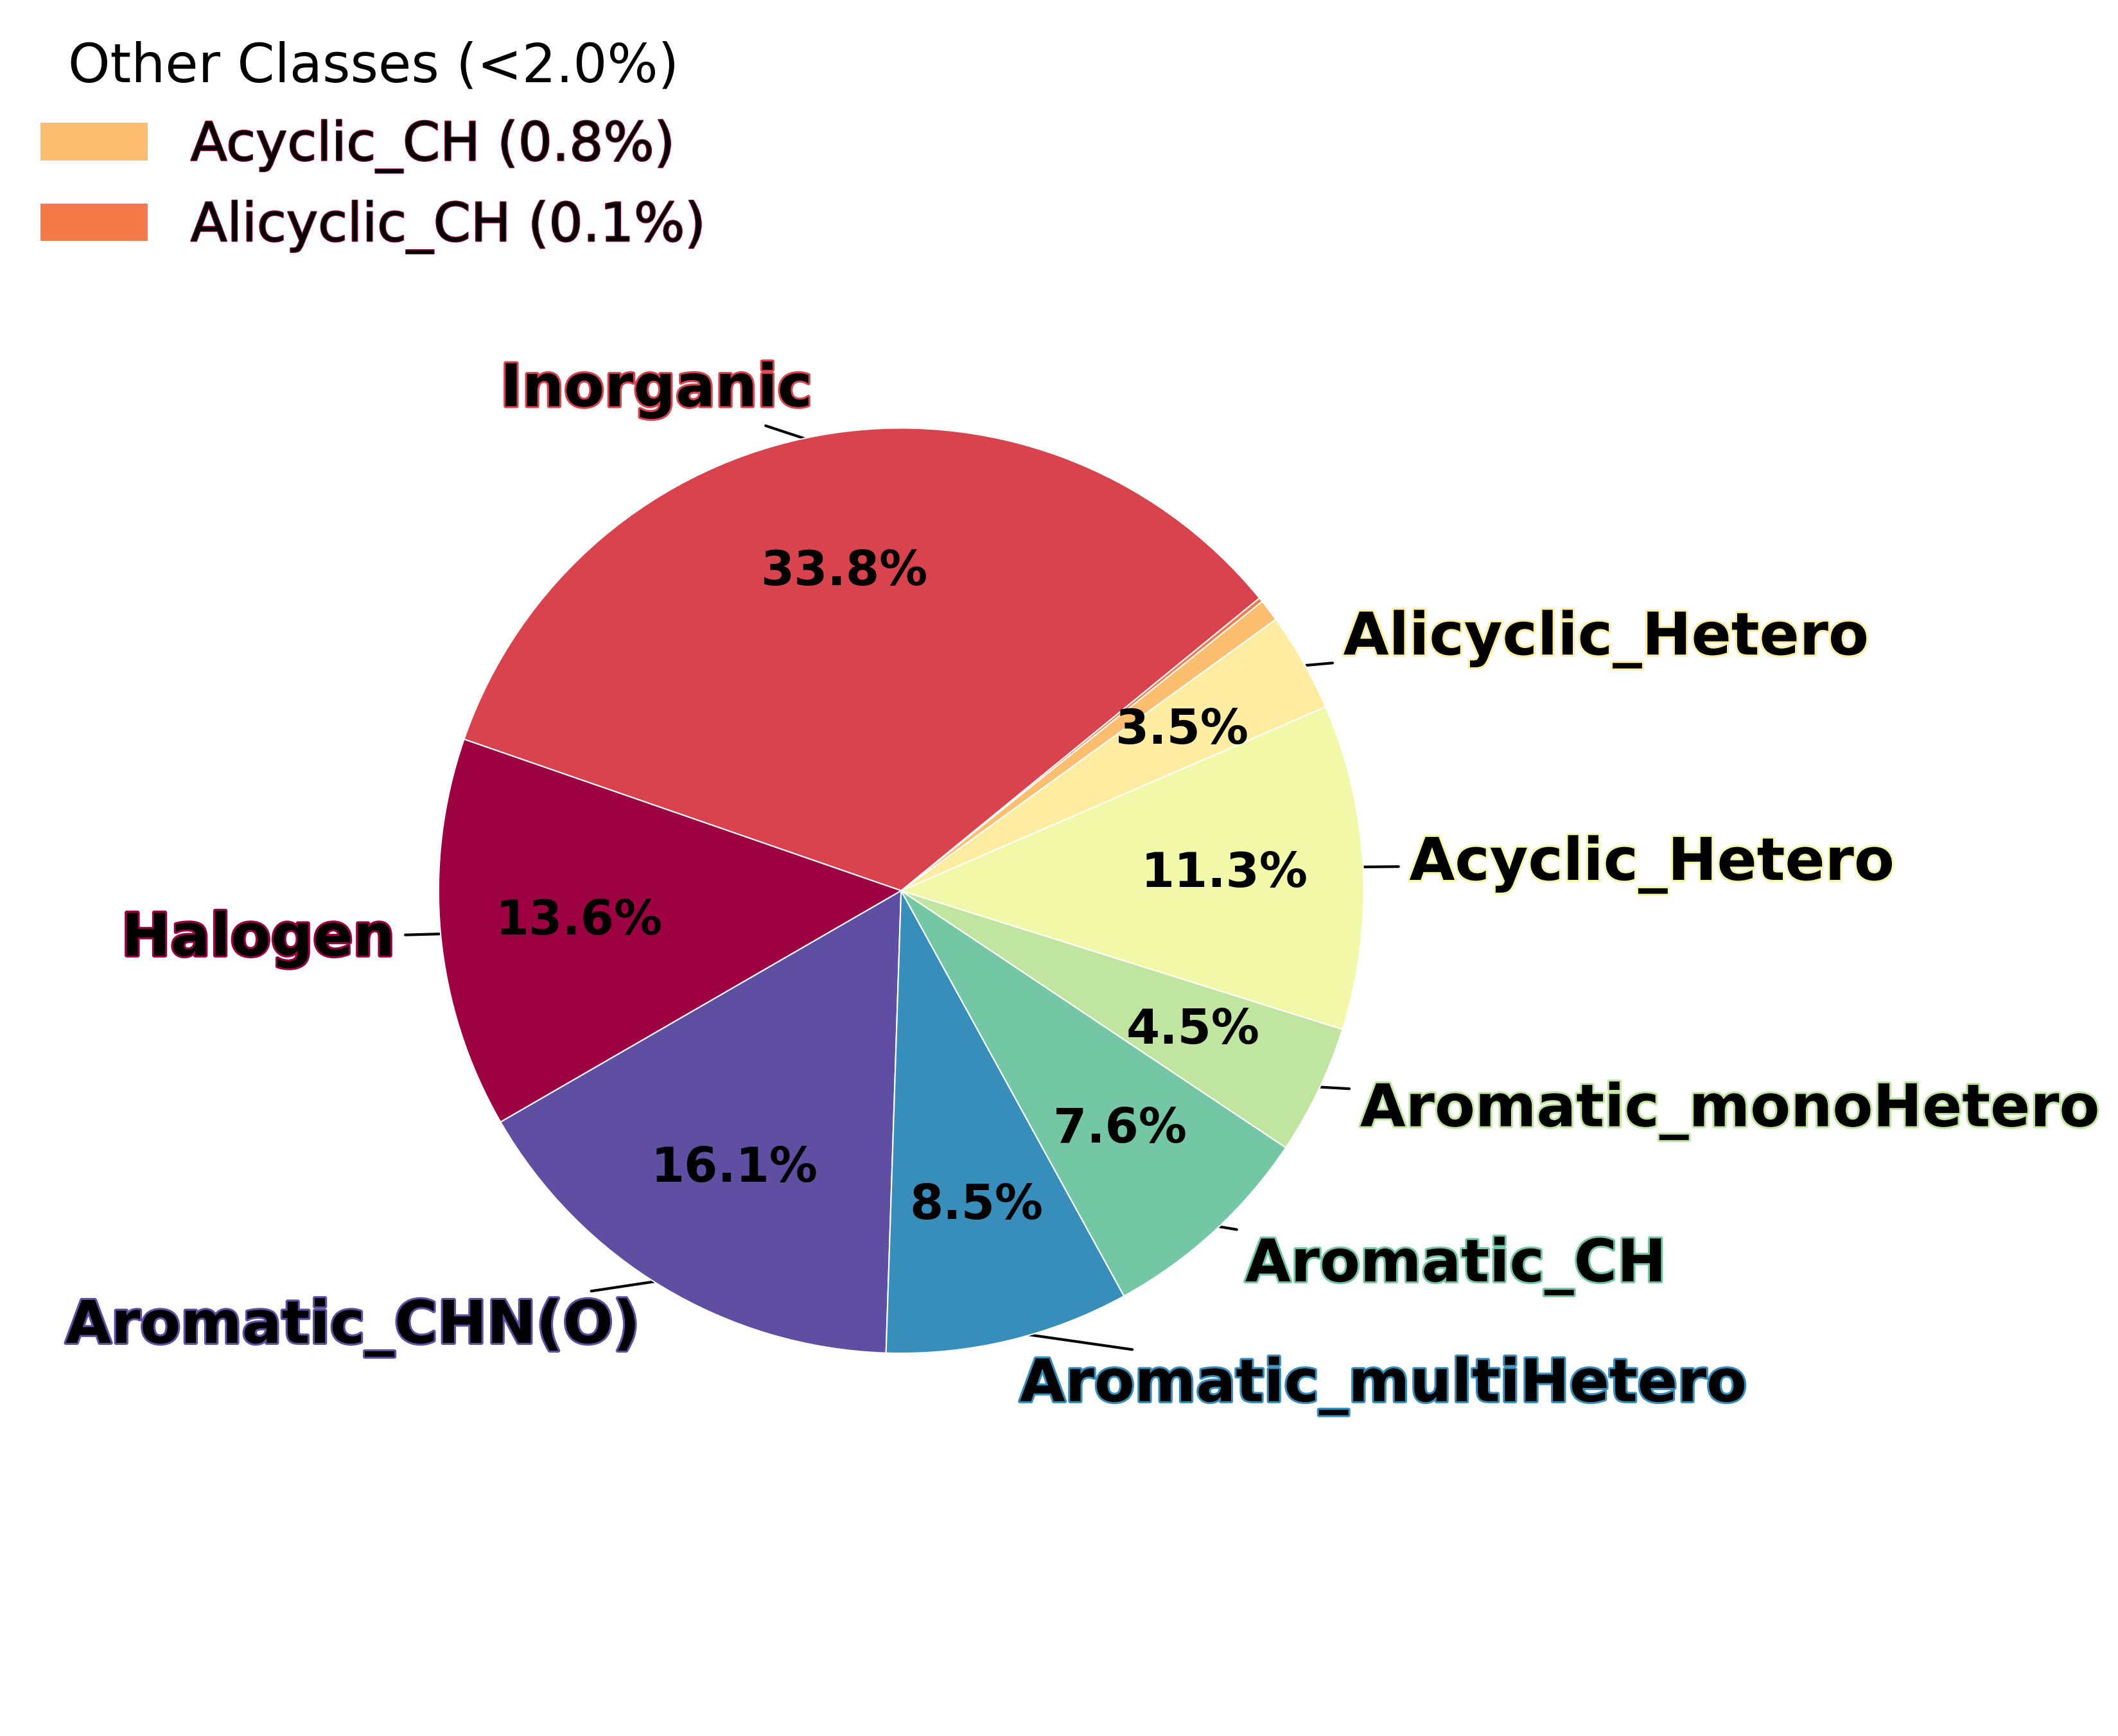

In [ ]:
# Pie chart of the classes

all_ligands = []
all_ligand_cls_counter = defaultdict(int)
for mol in df2use['mol']:
    lig_smiles = get_ligand_smiles_after_fe_removal(mol)
    all_ligands.extend(lig_smiles)
    for smiles in lig_smiles:
        classification = classify_smiles(smiles, inorganic_ligands, halogens)
        all_ligand_cls_counter[classification] += 1
all_ligand_cls_freq = {label: (count / len(all_ligands)) * 100 for label, count in all_ligand_cls_counter.items()}
sorted_ligand_freqs = sorted(all_ligand_cls_freq.items(), key=operator.itemgetter(1), reverse=True)


total_ligands = sum(all_ligand_cls_counter.values())


# Calculate percentages
all_ligand_cls_percent = {
    label: (count / total_ligands) * 100
    for label, count in all_ligand_cls_counter.items()
}

# make a str all lowercase

# --- Custom Sorting Function ---
def sort_key(item):
    label, perc = item
    if label.lower().startswith('aro'): group = 0
    elif label.lower().startswith('ali'): group = 1
    elif label.lower().startswith('acy'): group = 1
    else: group = 2
    return (group, -perc) # Sort by group, then by percentage descending

# Sort items
sorted_items = sorted(all_ligand_cls_percent.items(), key=sort_key)

# Separate labels, percentages, and counts
sorted_labels = [item[0] for item in sorted_items]
sorted_percents = [item[1] for item in sorted_items]
sorted_counts = [all_ligand_cls_counter[label] for label in sorted_labels]

# --- Pie Chart Plotting ---

fig, ax = plt.subplots(figsize=(12, 10), dpi=300) # Adjusted size slightly for legend room

# Define threshold
percent_threshold = 2.0

# Custom autopct function (only show &gt;= threshold)
def func_autopct(pct):
    return f"{pct:.1f}%" if pct >= percent_threshold else ""

# --- Get the colormap ---
n_slices = len(sorted_counts)
cmap = colormaps.get_cmap('Spectral') #('gist_rainbow')
#slice_colors = [cmap(i / n_slices) for i in range(n_slices)]
slice_colors = cmap(np.linspace(1, 0, n_slices))


# --- Plot the pie chart WITH SPECIFIED COLORS ---
radius = 0.7 # Adjust radius for better fit
wedges, texts, autotexts = ax.pie(
    sorted_counts,
    autopct=func_autopct,
    startangle=210, # Your preferred start angle
    pctdistance=0.7, # Place percentage inside
    colors=slice_colors, # &lt;&lt;&lt; USE THE GENERATED COLORS HERE &gt;&gt;&gt;
    wedgeprops={'linewidth': 0.5, 'edgecolor': 'white'},
    radius=radius
)

# Style autopct text
for autotext in autotexts:
    autotext.set_color('k')
    autotext.set_weight('bold')
    autotext.set_fontsize(18) # Adjusted autopct font size slightly


# --- Custom Labeling and Legend Preparation ---
# Base settings for annotate
kw = dict(arrowprops=dict(arrowstyle="-", color='gray', lw=0.7),
            zorder=0, va="center")

# Fixed distance for large slice labels
large_slice_label_radius = 1.1*radius

# Lists to store items for the legend
legend_handles = []
legend_labels = []

for i, p in enumerate(wedges):
    # Get data for this wedge
    percentage = sorted_percents[i]
    label_text = sorted_labels[i]
    wedge_color = p.get_facecolor() # Get the color of the current wedge (now from colormap)

    if percentage >= percent_threshold:
        # --- Large Slices: Annotate beside the pie ---
        ang = (p.theta2 - p.theta1)/2. + p.theta1 # Angle of the middle
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))

        # Use a straight line connector for simplicity
        kw['arrowprops'].update({"connectionstyle": None, "arrowstyle": "-", "color": 'k', "lw": 1})  # wedge_color

        # Horizontal alignment
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]

        # Calculate text position
        text_x = large_slice_label_radius * x
        text_y = large_slice_label_radius * y

        # --- Draw annotation for large slices ---
        import matplotlib.patheffects as path_effects
        ax.annotate(label_text,
                    xy=(x*0.98*radius, y*0.98*radius), # Point on wedge edge
                    xytext=(text_x, text_y),
                    horizontalalignment=horizontalalignment,
                    color='k', #wedge_color, # Match text color to wedge
                    fontsize=22, # Adjusted label font size
                    fontweight='bold',
                    path_effects=[
                                path_effects.Stroke(linewidth=1.5, foreground=wedge_color),
                                path_effects.Normal()],
                    **kw)
    else:
        # --- Small Slices: Add to legend ---
        # Create a dummy patch for the legend with the wedge color
        legend_handles.append(plt.Rectangle((0, 0), 1, 1, fc=wedge_color)) # wedge_color
        # Add the label text and its percentage for the legend
        legend_labels.append(f"{label_text} ({percentage:.1f}%)")


# --- Add the Legend for Small Slices ---
if legend_handles: # Only add legend if there are items for it
    leg = ax.legend(legend_handles, legend_labels,
                    title="Other Classes (<{:.1f}%)".format(percent_threshold),
                    loc="center left", # Position the legend
                    bbox_to_anchor=(-0.05, 0.95), # Place it outside the pie on the right
                    ncol = 1,
                    fontsize=20,
                    title_fontsize=20,
                    frameon=False)

    # Set legend text colors to match pie slices (handles)
    for i, text in enumerate(leg.get_texts()):
        text.set_color('k')#(legend_handles[i].get_facecolor())
        text.set_path_effects([
        path_effects.Stroke(linewidth=0.55
        , foreground=wedge_color),
        path_effects.Normal()
    ])


# ax.set_title("Ligand Class Distribution", pad=20) # Simpler title
# plt.axis('equal') # Handled by pie

plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust right margin for legend
plt.savefig('./Figures/Ligand_class_pie_fulldata.png', transparent=True, bbox_inches='tight')


Analyzing Cluster 0...
  Found 893 complexes.
  Analyzed 3516 ligands from 893 complexes.
  Top 5 Ligand Classifications (Frequency %):
    - Inorganic: 50.6%
    - Aromatic_CH: 13.9%
    - Acyclic_Hetero: 8.4%
    - Aromatic_multiHetero: 7.2%
    - Aromatic_monoHetero: 7.1%

Analyzing Cluster 1...
  Found 1254 complexes.
  Analyzed 3947 ligands from 1254 complexes.
  Top 5 Ligand Classifications (Frequency %):
    - Aromatic_CHN(O): 26.1%
    - Halogen: 22.8%
    - Inorganic: 18.8%
    - Acyclic_Hetero: 14.0%
    - Aromatic_multiHetero: 9.7%

--- Overall Cluster Ligand Classification Analysis ---
Cluster 0 (893 complexes, 3516 ligands):
  Predominant ligand classifications: Inorganic (50.6%), Aromatic_CH (13.9%), Acyclic_Hetero (8.4%), Aromatic_multiHetero (7.2%), Aromatic_monoHetero (7.1%)
Cluster 1 (1254 complexes, 3947 ligands):
  Predominant ligand classifications: Aromatic_CHN(O) (26.1%), Halogen (22.8%), Inorganic (18.8%), Acyclic_Hetero (14.0%), Aromatic_multiHetero (9.7%)


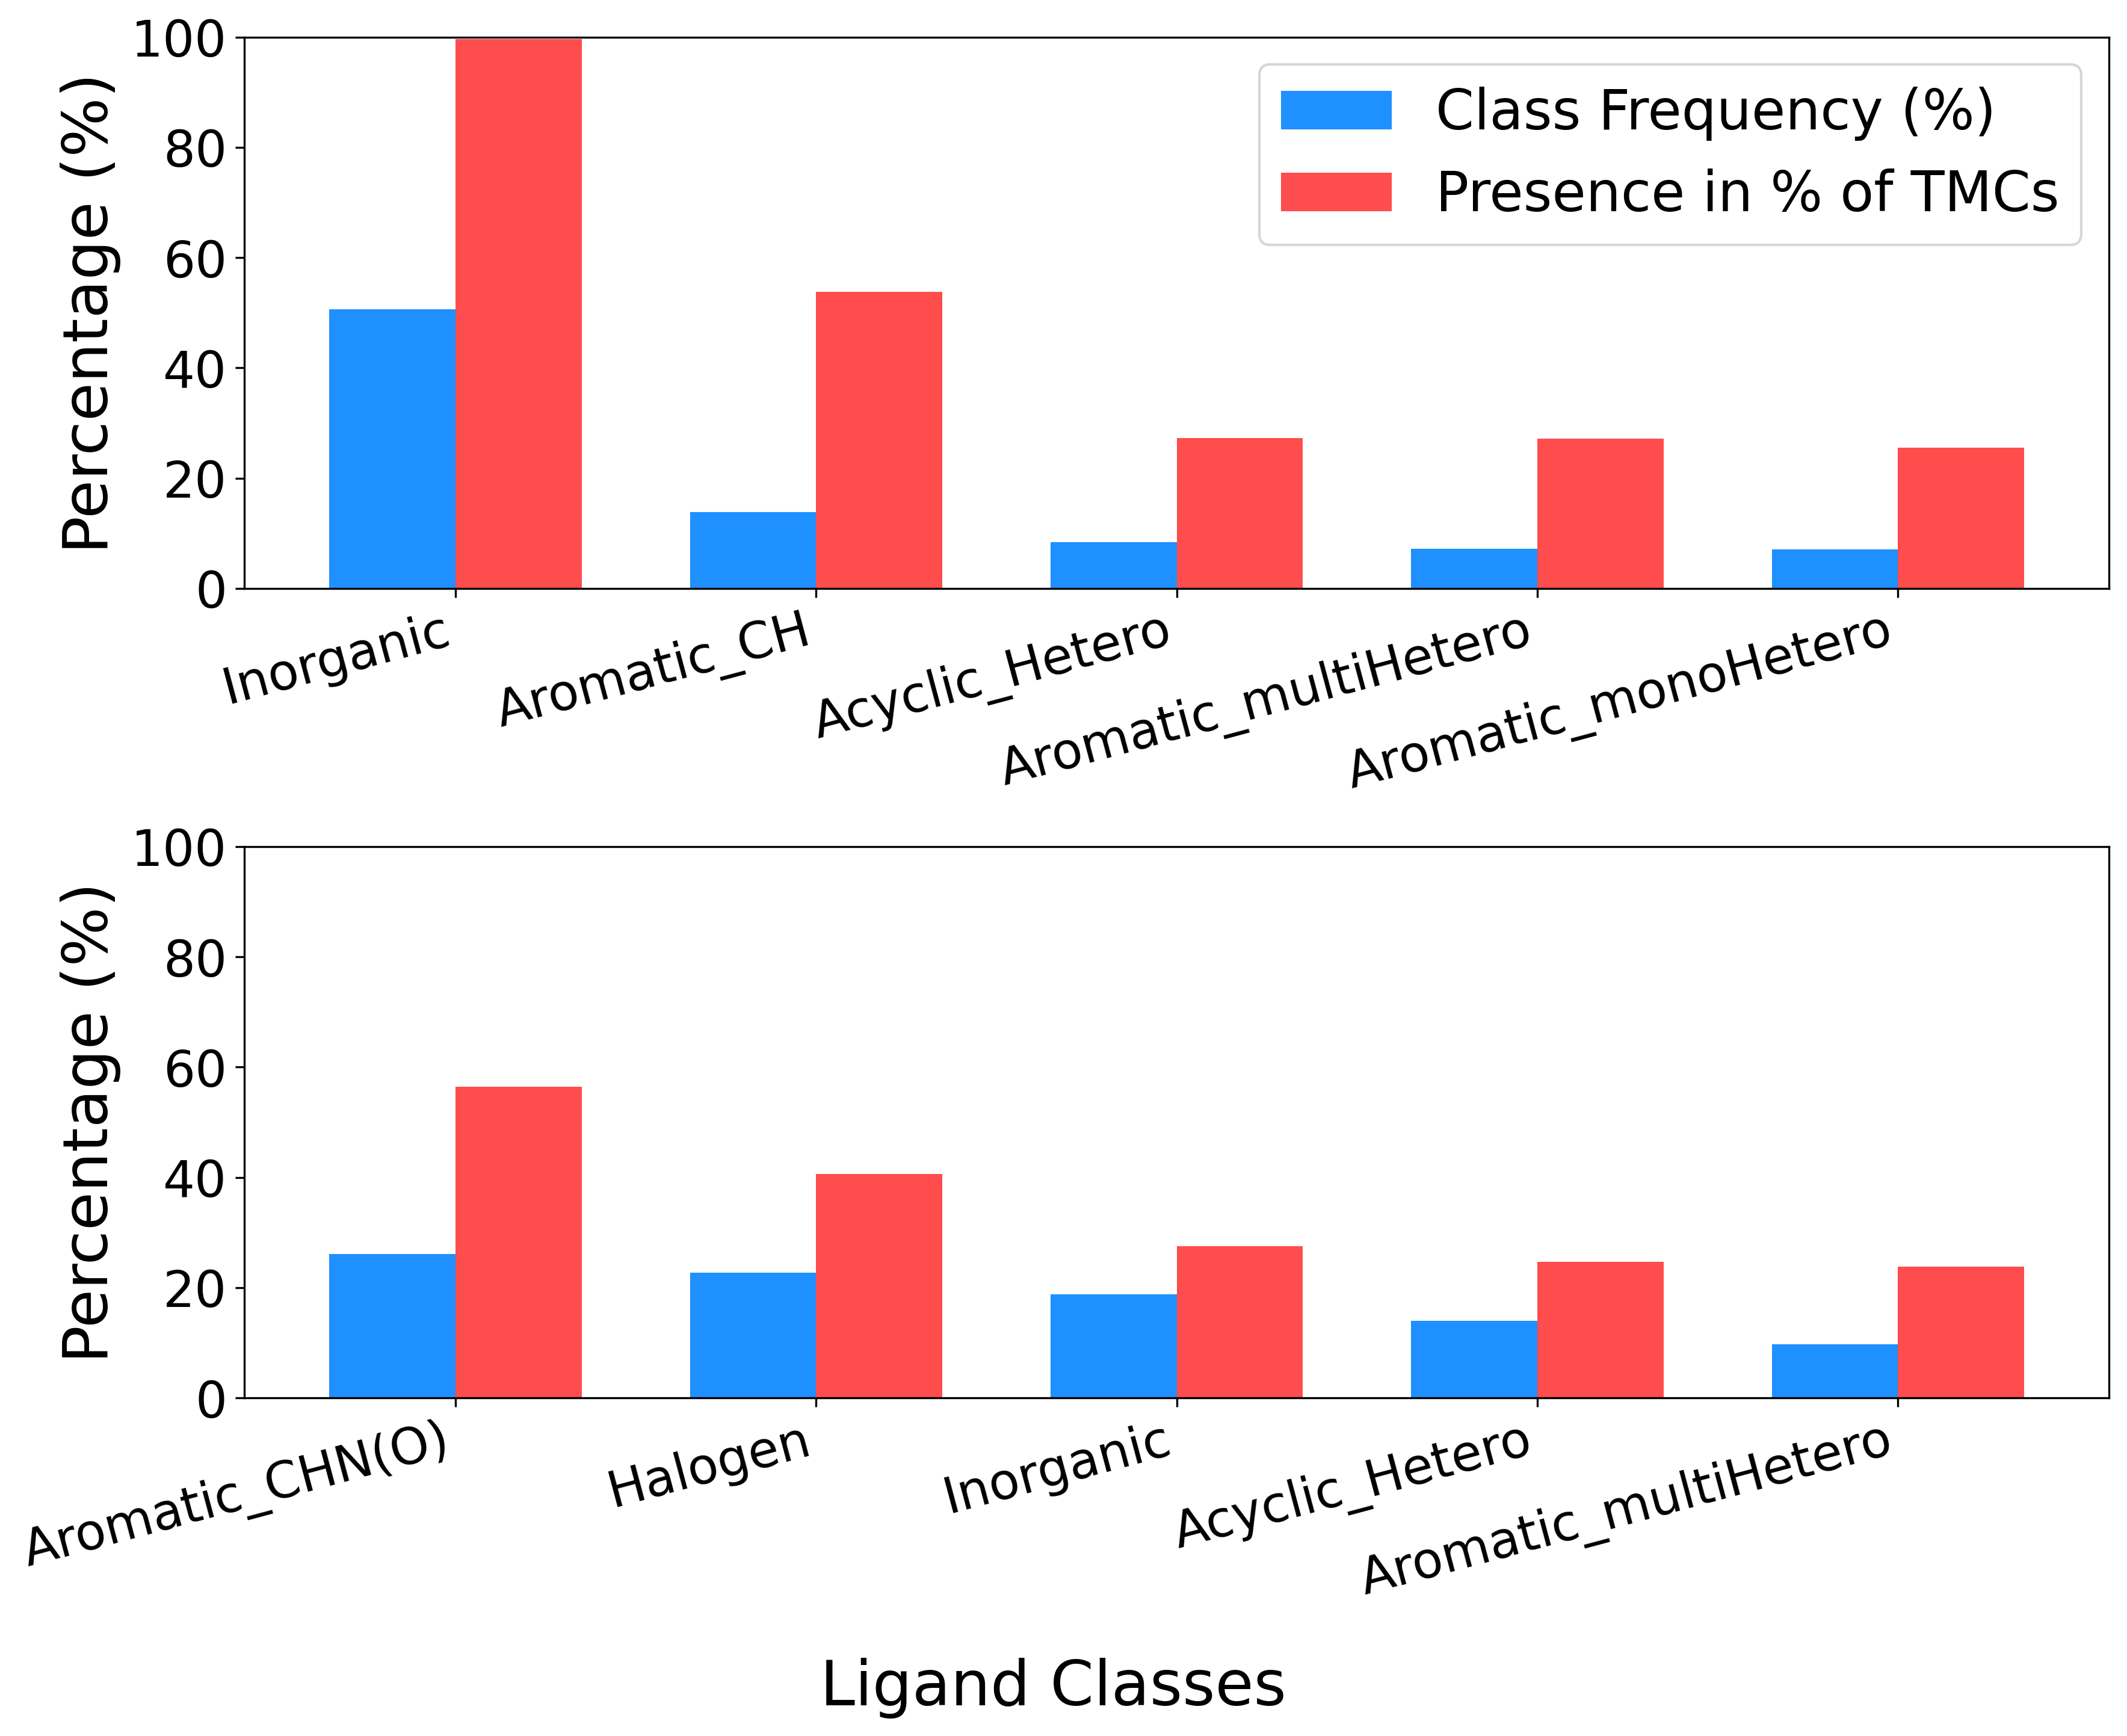

In [26]:
import operator


# --- Iterate Through Clusters and Analyze Fragments ---

cluster_classification_analysis = {} # Store results per cluster

for cluster_id in range(n_clusters):
    print(f"\nAnalyzing Cluster {cluster_id}...")

    # Get complexes belonging to the current cluster
    cluster_df = df2use[df2use['pca_cluster'] == cluster_id]
    cluster_mols = cluster_df['mol'].tolist() # Get the list of complex molecules
    num_complexes_in_cluster = len(cluster_mols) # Keep track of complexes for info

    if num_complexes_in_cluster == 0:
        print("  No complexes in this cluster. Skipping.")
        cluster_classification_analysis[cluster_id] = {
            "complex_count": 0,
            "ligand_count": 0,
            "top_classes": [],
            "ligand_frequencies": {}, 
            "tmc_presence_counts": defaultdict(int) # Store empty counts
        }
        continue

    print(f"  Found {num_complexes_in_cluster} complexes.")

    # Initialize counts for this cluster's classifications
    cluster_ligand_classification_counts = defaultdict(int)
    cluster_tmc_presence_counts = defaultdict(int) # Track counts per molecule
    total_ligands_in_cluster = 0

    # Iterate through complexes in this cluster
    for mol in cluster_mols:
        if not mol: continue # Skip invalid complex molecules

        # Get the list of ligand SMILES for the current complex
        lig_smiles = get_ligand_smiles_after_fe_removal(mol)


        # Iterate through LIGANDS for this complex
        lig_classes = set() # To avoid double counting ligands in the same complex
        for smiles in lig_smiles:
            # We count every valid ligand SMILES we attempt to classify
            total_ligands_in_cluster += 1

            # Classify the ligand based on its SMILES
            classification = classify_smiles(smiles, inorganic_ligands, halogens)
            lig_classes.add(classification) # Add to set to avoid duplicates
            
            # Record the classification category count for this cluster
            cluster_ligand_classification_counts[classification] += 1

        for lig_class in lig_classes:
            # Increment the count for this ligand classification
            cluster_tmc_presence_counts[lig_class] += 1


    # Calculate frequency (%) of each classification relative to the total number of ligands
    ligand_frequencies = {
        label: (count / total_ligands_in_cluster) * 100 if total_ligands_in_cluster > 0 else 0
        for label, count in cluster_ligand_classification_counts.items()
    }

    # Sort frequencies to find top classifications
    sorted_ligand_freqs = sorted(ligand_frequencies.items(), key=operator.itemgetter(1), reverse=True)


    tmc_frequencies = { # Calculate TMC frequencies just for reporting if needed
        label: (count / num_complexes_in_cluster) * 100 if num_complexes_in_cluster > 0 else 0
        for label, count in cluster_tmc_presence_counts.items()
    }
    sorted_tmc_freqs = sorted(tmc_frequencies.items(), key=operator.itemgetter(1), reverse=True)

    # Store results
    cluster_classification_analysis[cluster_id] = {
        "complex_count": num_complexes_in_cluster,
        "ligand_count": total_ligands_in_cluster,
        "top_classes": sorted_ligand_freqs[:5], # Top classes based on ligand frequency
        "ligand_frequencies": sorted_ligand_freqs, # Store ligand frequencies
        "tmc_presence_frequencies": sorted_tmc_freqs
    }

    print(f"  Analyzed {total_ligands_in_cluster} ligands from {num_complexes_in_cluster} complexes.")
    print(f"  Top 5 Ligand Classifications (Frequency %):")
    if sorted_ligand_freqs:
        for label, freq in sorted_ligand_freqs[:5]:
            print(f"    - {label}: {freq:.1f}%")
    else:
        print("    - No ligand classifications determined.")


# --- Report Overall Findings ---
print("\n--- Overall Cluster Ligand Classification Analysis ---")
for cluster_id, analysis in cluster_classification_analysis.items():
    # Use the counts stored in the analysis dictionary
    print(f"Cluster {cluster_id} ({analysis.get('complex_count', 0)} complexes, {analysis.get('ligand_count', 0)} ligands):")
    if analysis.get('top_classes'):
        top_str = ", ".join([f"{label} ({freq:.1f}%)" for label, freq in analysis['top_classes']])
        print(f"  Predominant ligand classifications: {top_str}")
    else:
        print("  No ligand classifications determined or no ligands found.")

# --- Visualization per cluster ---

DPI = 300

num_plot_items = 5 #-1 # Or set a limit like 15 if plots get too crowded

fig, axes = plt.subplots(n_clusters, 1, figsize=(12, n_clusters * 5), sharex=False, dpi=DPI) # Increased width slightly
if n_clusters == 1: axes = [axes] # Make axes iterable if only 1 cluster


for cluster_id, analysis in cluster_classification_analysis.items():
    ax = axes[cluster_id] # This is the primary axis (left)

    # Retrieve counts and frequencies needed
    complex_count = analysis.get('complex_count', 0)
    ligand_count = analysis.get('ligand_count', 0)
    ligand_frequencies = analysis.get('ligand_frequencies', {})
    tmc_presence_frequencies = analysis.get('tmc_presence_frequencies', defaultdict(int))

    
    
    # Sort based on ligand frequency to determine the order of bars
    #all_sorted_ligand_freqs = sorted(ligand_frequencies.items(), key=operator.itemgetter(1), reverse=True)

    # Limit the number of items to plot if num_plot_items is positive
    if num_plot_items > 0:
            ax1_plot_items = ligand_frequencies[:num_plot_items]
            ax2_plot_items = tmc_presence_frequencies[:num_plot_items]
    else:
        ax1_plot_items = ligand_frequencies # Show all
        ax2_plot_items = tmc_presence_frequencies # Show all

    plot_labels = [item[0] for item in ax1_plot_items]
    plot_ligand_freqs = [item[1] for item in ax1_plot_items]

    # Calculate the TMC presence percentage for the plotted labels
    plot_tmc_presence_percent = [item[1] for item in ax2_plot_items] 

    # --- Plotting Setup ---
    x_pos = np.arange(len(plot_labels)) # the label locations
    bar_width = 0.35 # the width of the bars

    # --- Plot Both Bar Series on the SAME Axis (ax) ---
    bars1 = ax.bar(x_pos - bar_width/2, plot_ligand_freqs, bar_width,
                    label='Class Frequency (%)', color='dodgerblue') # Add label for legend
    bars2 = ax.bar(x_pos + bar_width/2, plot_tmc_presence_percent, bar_width,
                    label='Presence in % of TMCs', color='red', alpha=0.7) # Add label for legend

    # --- Set Single Y-Axis Label and Ticks ---
    ax.set_ylabel('Percentage (%)', fontsize=25) # Single Y-axis label
    ax.tick_params(axis='y', labelsize=20) # Style Y-axis ticks
    ax.set_ylim(0, 100) # Set appropriate Y-limit (0-100% + headroom)

    # --- General Axes Formatting ---
    ax.set_xticks(x_pos)
    ax.set_xticklabels(plot_labels, rotation=15, ha='right', fontsize=20)

    #ax.set_title(f"Cluster {cluster_id+1} ({ligand_count} ligands from {complex_count} TMCs)", fontsize = 20)

    # --- Add Legend ---
    if cluster_id == 0: ax.legend(fontsize=22) # Display the legend using labels from ax.bar calls

# Set common x-label below all subplots
# Adjust figure layout to make room for labels and title
fig.text(0.5, 0.01, 'Ligand Classes', ha='center', va='center', fontsize=25)

fig.subplots_adjust(hspace=0.1)

plt.tight_layout(rect=[0, 0.04, 1, 0.95]) # Adjust rect bottom (0.04) to make space for common xlabel
#plt.show()

plt.savefig('./Figures/Cluster_classes_fulldata.png', transparent=True, bbox_inches='tight')


Analyzing Cluster 0...
  Found 893 molecules.
  Top 5 Groups (Frequency %):
    - C: 99.9%
    - P: 28.1%
    - N: 25.0%
    - S: 13.2%
    - O: 7.6%

Analyzing Cluster 1...
  Found 1254 molecules.
  Top 5 Groups (Frequency %):
    - N: 84.3%
    - Cl: 29.5%
    - O: 28.8%
    - C: 14.8%
    - P: 13.9%

--- Overall Cluster Fragment Analysis ---
Cluster 0 (893 molecules):
  Predominant groups: C (99.9%), P (28.1%), N (25.0%), S (13.2%), O (7.6%)
Cluster 1 (1254 molecules):
  Predominant groups: N (84.3%), Cl (29.5%), O (28.8%), C (14.8%), P (13.9%)


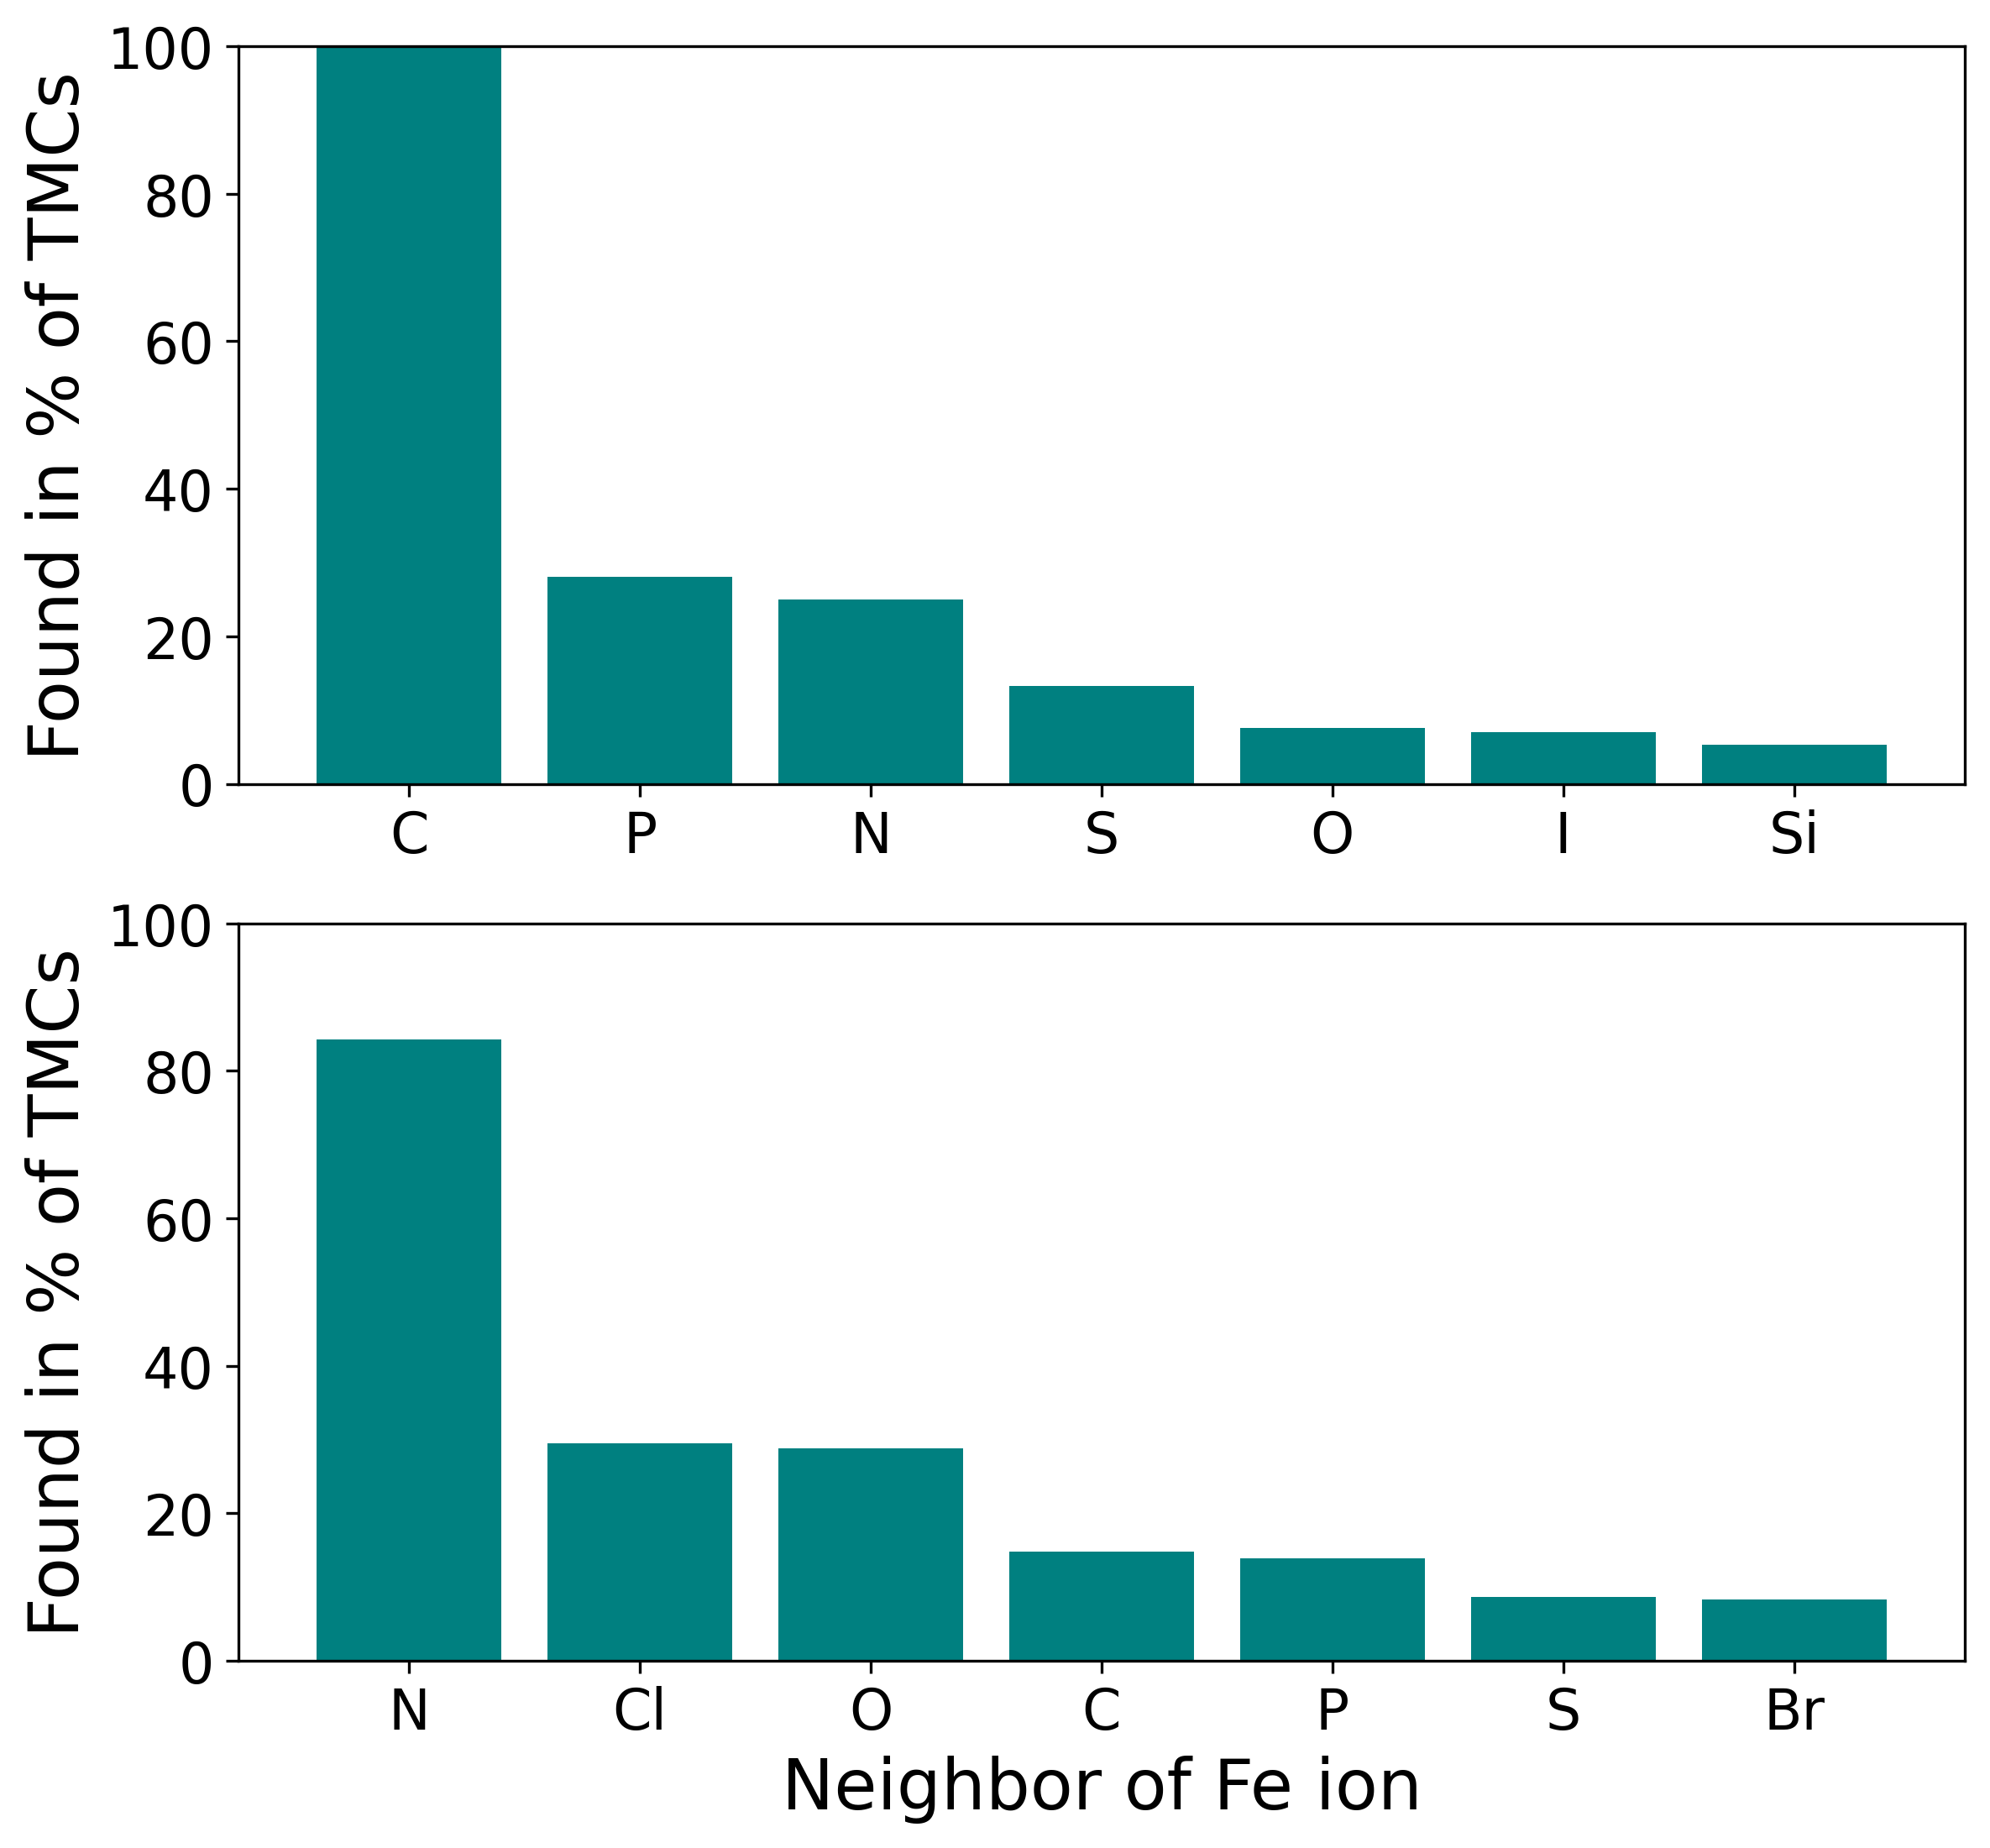

In [27]:
# Neighbor analysis around Fe

cluster_Fe_analysis = {} # Store results per cluster

for cluster_id in range(n_clusters):
    print(f"\nAnalyzing Cluster {cluster_id}...")

    # Get molecules belonging to the current cluster
    cluster_df = df2use[df2use['pca_cluster'] == cluster_id]
    cluster_mols = cluster_df['mol'].tolist()
    num_mols_in_cluster = len(cluster_mols)

    if num_mols_in_cluster == 0:
        print("  No molecules in this cluster. Skipping.")
        cluster_Fe_analysis[cluster_id] = {"count": 0, "top_groups": [], "frequencies": {}}
        continue

    print(f"  Found {num_mols_in_cluster} molecules.")

    # Initialize counts for this cluster
    # Use defaultdict for easier counting
    cluster_neigh_counts = defaultdict(int)

    # Iterate through molecules IN THIS CLUSTER
    for mol in cluster_mols:
        if not mol: continue # Skip None molecules if any

        # Iterate through the functional group checks
        for atom in mol.GetAtoms():
            if atom.GetSymbol() == 'Fe':
                # Get neighbors of the Fe atom
                neighbors = atom.GetNeighbors()
                neigh_symbol = set([neighbor.GetSymbol() for neighbor in neighbors])   # set() to get non-repeating neighs
                for neighbor in neigh_symbol:
                    # Increment the count for this neighbor type
                    cluster_neigh_counts[neighbor] += 1

    # --- Analyze and Store Results for the Cluster ---
    # Calculate frequency (%) of each group within this cluster
    cluster_frequencies = {
        name: (count / num_mols_in_cluster) * 100
        for name, count in cluster_neigh_counts.items()
    }

    # Sort frequencies to find top groups
    sorted_freqs = sorted(cluster_frequencies.items(), key=operator.itemgetter(1), reverse=True)

    # Store overall count and top N groups (e.g., top 5)
    cluster_Fe_analysis[cluster_id] = {
        "count": num_mols_in_cluster,
        "top_groups": sorted_freqs[:5], # Store top 5 groups/frequencies
        "frequencies": cluster_frequencies # Store all frequencies
    }

    print(f"  Top 5 Groups (Frequency %):")
    for name, freq in sorted_freqs[:5]:
        print(f"    - {name}: {freq:.1f}%")


print("\n--- Overall Cluster Fragment Analysis ---")
for cluster_id, analysis in cluster_Fe_analysis.items():
    print(f"Cluster {cluster_id} ({analysis['count']} molecules):")
    if analysis['top_groups']:
        top_str = ", ".join([f"{name} ({freq:.1f}%)" for name, freq in analysis['top_groups']])
        print(f"  Predominant groups: {top_str}")
    else:
        print("  No functional groups detected or no molecules in cluster.")

# --- Visualization per cluster ---

DPI = 300

num_plot_groups = 7 # Number of groups to show per cluster plot

fig, axes = plt.subplots(n_clusters, 1, figsize=(8, n_clusters * 4), sharex=False, dpi=DPI) # Adjust figsize
if n_clusters == 1: axes = [axes] # Make axes iterable if only 1 cluster

#fig.suptitle("Top Functional Group Frequencies per PCA Cluster", fontsize=16)

for cluster_id, analysis in cluster_Fe_analysis.items():
    ax = axes[cluster_id]
    if analysis['count'] > 0:
        # Sort all frequencies for plotting
        all_sorted_freqs = sorted(analysis['frequencies'].items(), key=operator.itemgetter(1), reverse=True)
        plot_names = [item[0] for item in all_sorted_freqs[:num_plot_groups]]
        plot_freqs = [item[1] for item in all_sorted_freqs[:num_plot_groups]]

        ax.bar(plot_names, plot_freqs, color='teal')
        ax.set_ylabel("Found in % of TMCs", fontsize = 20)
        #ax.set_title(f"Cluster {cluster_id+1} ({analysis['count']} TMCs)", fontsize = 20)
        ax.tick_params(axis='x', rotation=0, labelsize = 16)
        ax.tick_params(axis='y', labelsize = 16)
        ax.set_ylim([0,100])
        # Optional: Add frequency values on bars
        #for i, freq in enumerate(plot_freqs):
            #ax.text(i, freq, f'{freq:.1f}', ha='center', va='bottom')
    else:
        ax.set_title(f"Cluster {cluster_id} (Empty)")
        ax.text(0.5, 0.5, "No molecules", ha='center', va='center', transform=ax.transAxes)

plt.xlabel("Neighbor of Fe ion", fontsize = 20) # Common x-label
plt.tight_layout(rect=[0, 0.03, 1, 0.96]) # Adjust layout
plt.savefig('./Figures/Cluster_neighs_fulldata.png', transparent=True, bbox_inches='tight')

# Analyzing GNN-redox dataset

# Analysing the filtered gnn-redox dataset using final_df

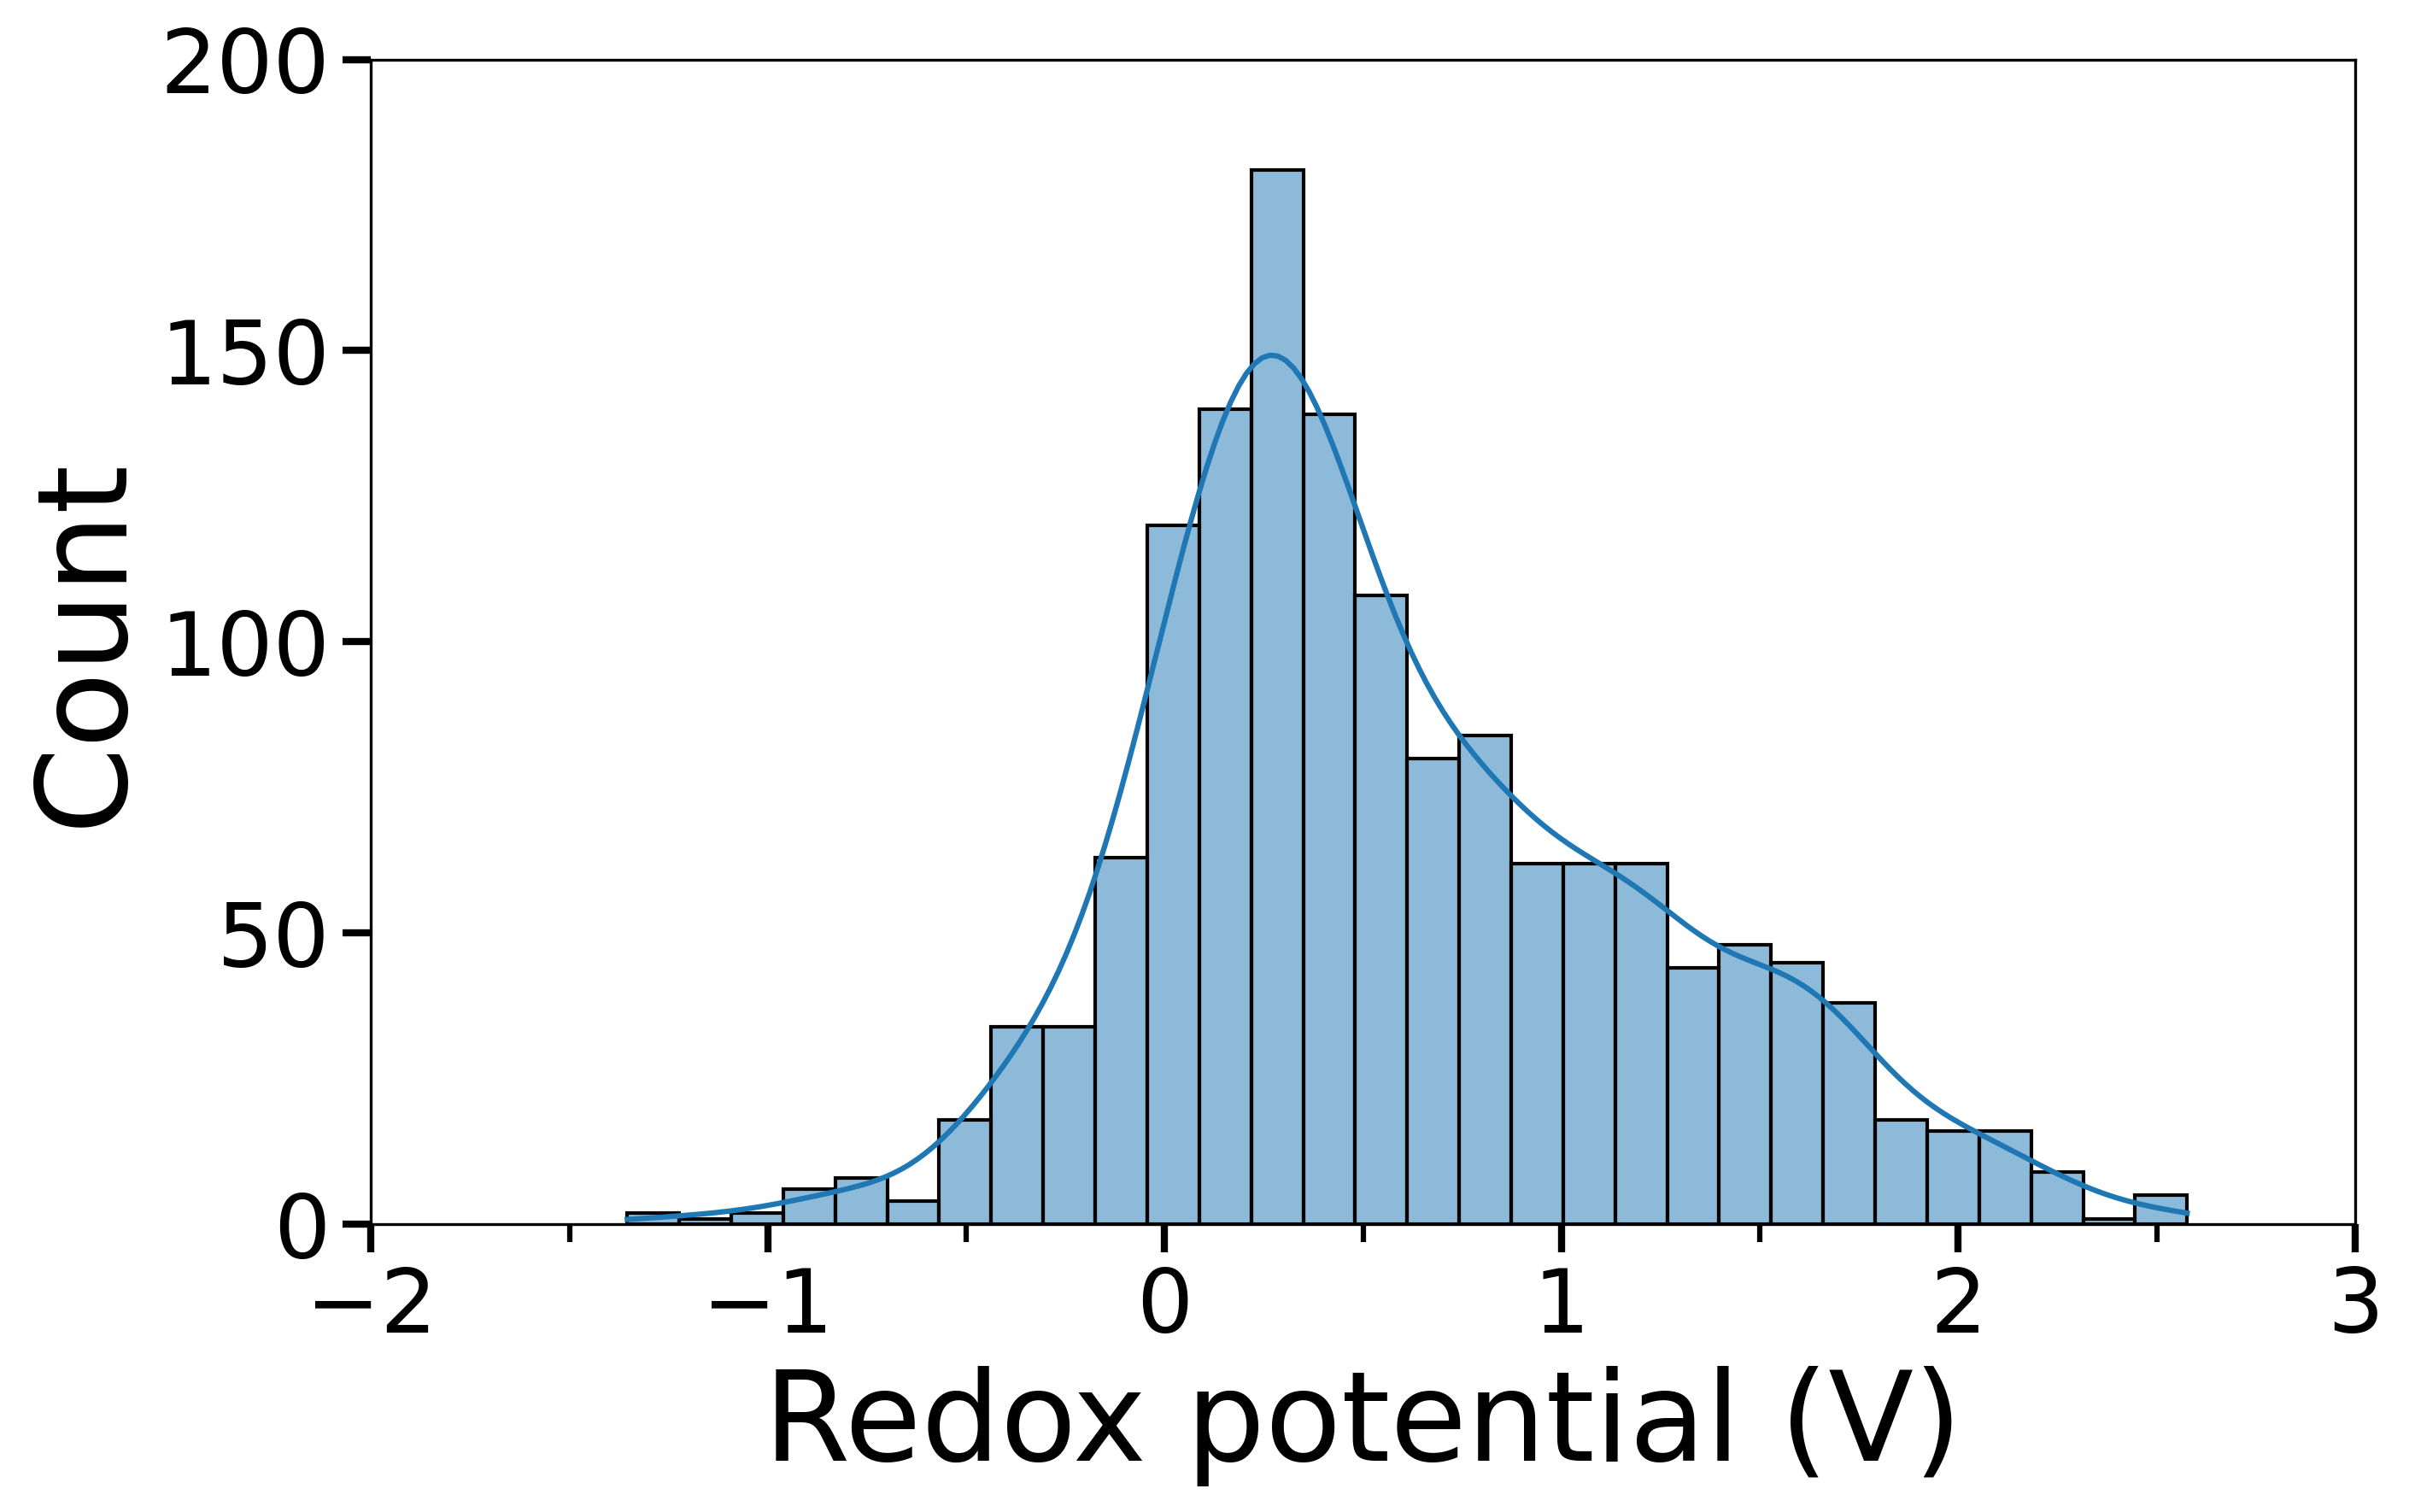

In [28]:
# Plot histogram for final_df['y']

# plot histogram for final_df['y']

from matplotlib.ticker import AutoMinorLocator # Import AutoMinorLocator


plt.figure(figsize=(9.5, 6), dpi=300) 

ax = sns.histplot(final_df['y'], kde=True, bins=30) # Get the axes object

#plt.title('Histogram of final_df[\'y\']')
plt.xlabel('Redox potential (V)', fontsize=35)
plt.xlim([-2,3])
plt.xticks(fontsize=25)

plt.ylabel('Count', fontsize=35)
plt.ylim([0,200])
plt.yticks(fontsize=25)

ax.yaxis.set_major_locator(plt.MaxNLocator(4))  # Set major ticks to a maximum of 6
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.tick_params(which='major', length=8, width=2)
ax.tick_params(axis='x', which='minor', length=5, width=1.5)

#plt.grid(axis='y', alpha=0.75) # Optional: adds a grid

plt.tight_layout()
plt.savefig('./Figures/Redox_hist.png', transparent=True)

# PCA for final_df

In [29]:
from rdkit.Chem import AllChem, rdchem, rdFingerprintGenerator

def compute_morgan_fingerprint(mol, radius=3, fpSize=2048):
    mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=radius,fpSize=fpSize)
    morgan_fp = mfpgen.GetFingerprint(mol) # Get the fingerprint object
    # Convert ExplicitBitVect to NumPy array
    np_fp = np.array(list(morgan_fp))#, dtype=float)
    return np_fp # Return the NumPy array


descriptors = None

for i,mol in enumerate(final_df['mol']):
    x = compute_morgan_fingerprint(mol)
    if i == 0:
        descriptors = np.zeros((len(final_df), x.shape[-1]))
    descriptors[i]=x

mfp_descriptors_scaled_full = StandardFlexibleScaler(column_wise=False).fit_transform(descriptors)

target_y = final_df['y'].values

mfp_pca_calculated_full = pca_from_mfp(mfp_descriptors_scaled_full) 
mfp_pca_calculated_gnndf_256 = pca_from_mfp(mfp_descriptors_scaled_full, y = target_y, n_features=256) 
mfp_pca_calculated_gnndf_128 = pca_from_mfp(mfp_descriptors_scaled_full, y = target_y, n_features=128) 
mfp_pca_calculated_gnndf_64 = pca_from_mfp(mfp_descriptors_scaled_full, y = target_y, n_features=64)


#mfp_tsne_calculated_full = tsne_from_mfp(mfp_descriptors_scaled_full) 
#mfp_tsne_calculated_256 = tsne_from_mfp(mfp_descriptors_scaled_full, y = target_y, n_features=256)
#mfp_tsne_calculated_128 = tsne_from_mfp(mfp_descriptors_scaled_full, y = target_y, n_features=128)
#mfp_tsne_calculated_64 = tsne_from_mfp(mfp_descriptors_scaled_full, y = target_y, n_features=64)

/home/fbhuiyan/.local/sophia/conda/2024-08-08/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/fbhuiyan/.local/sophia/conda/2024-08-08/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Selecting top 256 features using RandomForestRegressor...
  Creating RandomForestRegressor with params: {'n_estimators': 300, 'n_jobs': -1, 'random_state': 42}
  Generated mask selecting 256 features.
Selecting top 128 features using RandomForestRegressor...
  Creating RandomForestRegressor with params: {'n_estimators': 300, 'n_jobs': -1, 'random_state': 42}
  Generated mask selecting 128 features.
Selecting top 64 features using RandomForestRegressor...
  Creating RandomForestRegressor with params: {'n_estimators': 300, 'n_jobs': -1, 'random_state': 42}
  Generated mask selecting 64 features.


Running KMeans clustering on PCA data with k=2...
Assigned cluster labels (0 to 1) to 1450 molecules.
Cluster distribution: Counter({np.int32(1): 940, np.int32(0): 510})
Cluster Info:
Cluster 0: 510 points, average = 1.19, std = 0.53
Cluster 1: 940 points, average = 0.26, std = 0.41

Identified 44 potential outlier points based on criteria.

Original DataFrame indices of identified outlier points:
[38, 64, 161, 196, 208, 230, 250, 337, 349, 377, 378, 379, 463, 495, 551, 555, 581, 585, 588, 629, 674, 729, 731, 759, 760, 784, 808, 906, 945, 961, 1028, 1048, 1131, 1163, 1235, 1271, 1308, 1321, 1340, 1368, 1375, 1377, 1411, 1422]


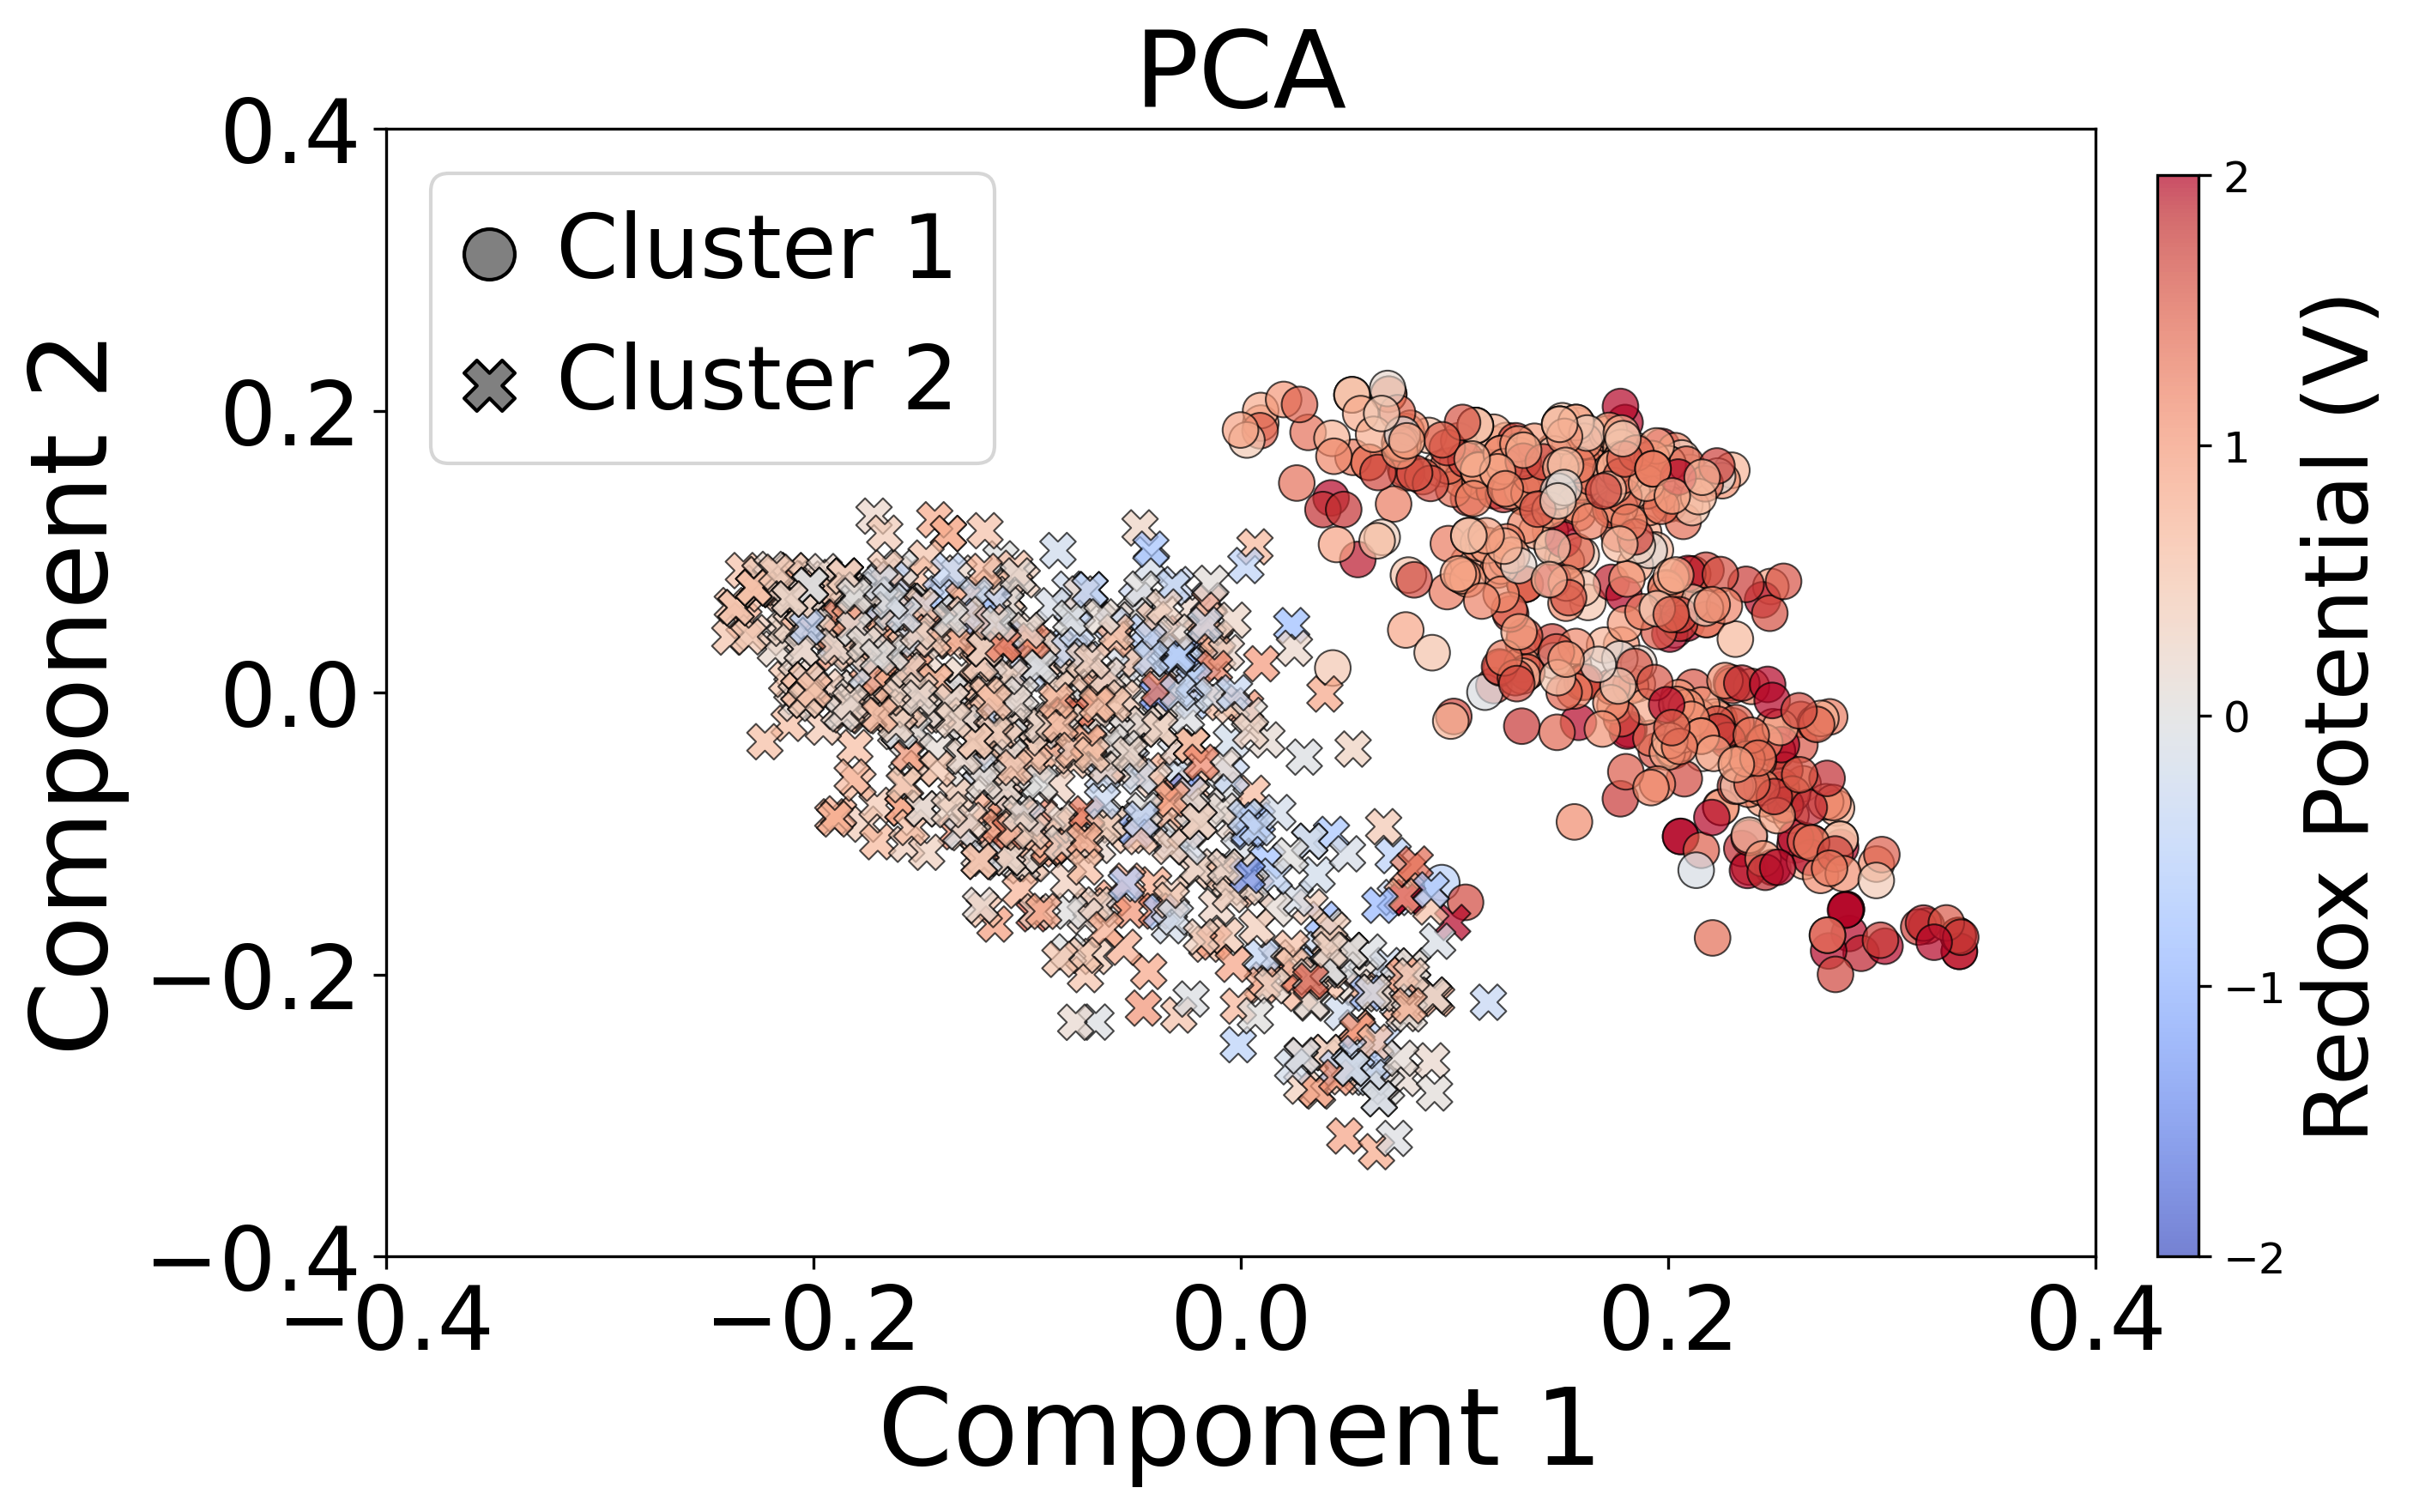

In [30]:
 # Import patches for circles
from sklearn.cluster import KMeans
from collections import Counter
import copy

pca_2_plot = mfp_pca_calculated_gnndf_64
df2use = copy.deepcopy(final_df)

# --- 1. Cluster the PCA Data ---
n_clusters = 2
print(f"Running KMeans clustering on PCA data with k={n_clusters}...")
kmeans = KMeans(n_clusters=n_clusters, n_init = 'auto', max_iter=500, tol=0.00001, random_state=52)
cluster_labels = kmeans.fit_predict(pca_2_plot)
df2use['pca_cluster'] = cluster_labels
print(f"Assigned cluster labels (0 to {n_clusters-1}) to {len(df2use)} molecules.")
print("Cluster distribution:", Counter(cluster_labels))

# --- calculate avg of clusters ---- #
# --- Identify Outlier Indices ---
color_data_np = df2use['y'].to_numpy() # Ensure color data is numpy array for masking
cluster_labels_np = df2use['pca_cluster'].to_numpy() # Ensure cluster labels is numpy array

# Condition 1: Cluster 0
mask_c0 = (cluster_labels_np == 0) 
# Condition 2: Cluster 1
mask_c1 = (cluster_labels_np == 1)

cluster_0_idxs = np.where(mask_c0)[0]
cluster_1_idxs = np.where(mask_c1)[0]

# Clusters
cluster_0_y = df2use.y[cluster_0_idxs].to_numpy()
cluster_1_y = df2use.y[cluster_1_idxs].to_numpy()

print(f"Cluster Info:")
print(f"Cluster 0: {len(cluster_0_y)} points, average = {np.mean(cluster_0_y):.2f}, std = {np.std(cluster_0_y):.2f}")
print(f"Cluster 1: {len(cluster_1_y)} points, average = {np.mean(cluster_1_y):.2f}, std = {np.std(cluster_1_y):.2f}")

# --- Identify Outlier Indices ---
#color_data_np = df2use['y'].to_numpy() # Ensure color data is numpy array for masking
#cluster_labels_np = df2use['pca_cluster'].to_numpy() # Ensure cluster labels is numpy array

c0_thresh = 0.25 #-0.8
c1_thresh = 1.1 #1.8
outlier_mask_c0 = (cluster_labels_np == 0) & (color_data_np < c0_thresh)
# Condition 2: Cluster 1 AND y > 1
outlier_mask_c1 = (cluster_labels_np == 1) & (color_data_np > c1_thresh)

# Combine masks
outlier_mask = outlier_mask_c0 | outlier_mask_c1

# Get the indices within the DataFrame/numpy arrays for these outliers
outlier_indices = np.where(outlier_mask)[0] # Gets the indices where outlier_mask is True

# Store the original identifiers (e.g., DataFrame index or 'csd_code')
outlier_original_indices = df2use.index[outlier_indices].tolist()

print(f"\nIdentified {len(outlier_indices)} potential outlier points based on criteria.")
# print("Original indices/identifiers of outliers:", outlier_original_indices) # Keep this line if you need the IDs

outlier_smiles_c0 = df2use.smiles[np.where(outlier_mask_c0)[0]].tolist()
outlier_smiles_c1 = df2use.smiles[np.where(outlier_mask_c1)[0]].tolist()


# --- Plotting Setup ---

color_data = df2use['y'] 
color_value_min = -2; color_value_max = 2; colormap = 'coolwarm'
marker_size = 100; marker_alpha = 0.7; marker_edgecolor = 'k'; marker_linewidth = 0.5
markers = {0: 'o', 1: 'X'}; cluster_legend_labels = {0: 'Cluster 1', 1: 'Cluster 2'}

# Create the figure and the subplots
fig, ax = plt.subplots(figsize=(8, 6), dpi = 300)
#axes = axes.flatten()

# Data and titles
plot_data = [(pca_2_plot, "PCA")] #, (mfp_tsne_calculated_128, "TSNE")]
pca_xlim = [-0.4, 0.4]; pca_ylim = [-0.4, 0.4]
tsne_xlim = [-60, 60]; tsne_ylim = [-40, 40]
plot_limits = [(pca_xlim, pca_ylim)] #, (tsne_xlim, tsne_ylim)]


# --- Loop through data and create each subplot ---
mappable = None
proxy_handles_dict = {}

for i, ((data, title), (xlim, ylim)) in enumerate(zip(plot_data, plot_limits)):
    #ax = axes[i]

    # Iterate through each cluster to plot with different markers
    for cluster_id in range(n_clusters):
        cluster_mask = (cluster_labels == cluster_id)
        if not np.any(cluster_mask): continue

        x_cluster = data[cluster_mask, 0]
        y_cluster = data[cluster_mask, 1]
        # Use the mask directly on the pandas Series or numpy array
        color_data_cluster = color_data[cluster_mask]

        scatter_plot = ax.scatter(
            x=x_cluster, y=y_cluster, c=color_data_cluster, cmap=colormap,
            vmin=color_value_min, vmax=color_value_max, s=marker_size,
            alpha=marker_alpha, edgecolor=marker_edgecolor,
            linewidth=marker_linewidth, marker=markers[cluster_id],
            label="_nolegend_"
        )
        if i == 0 and cluster_id == 0: mappable = scatter_plot
        if i == 0 and cluster_id not in proxy_handles_dict:
             proxy_handles_dict[cluster_id] = ax.scatter([],[], marker=markers[cluster_id], label=cluster_legend_labels[cluster_id],
                                                        edgecolor=marker_edgecolor, linewidth=marker_linewidth+0.5,
                                                        s=marker_size*2, c='gray')

    # --- Draw Circles Around Outliers for this plot ---
    # Get the PCA/TSNE coordinates specifically for the outlier points
    outlier_coords_this_plot = data[outlier_indices]
    # Plot circles around outlier points
    '''for x_outlier, y_outlier in outlier_coords_this_plot:
        outlier_point_cluster = cluster_labels_np[np.where((data[:,0] == x_outlier) & (data[:,1] == y_outlier))[0][0]] # Find cluster of this point - bit complex

        # Or just use a single outlier style
        scale = 0.004 #if title == 'PCA' else 0.03
        c = 'r' if outlier_point_cluster == 0 else 'b' 
        circle = patches.Circle((x_outlier, y_outlier), radius=xlim[1]*scale, # Radius relative to axis range
                                edgecolor=c, 
                                facecolor='none',
                                linestyle='--', # Dotted line style
                                linewidth=1.1,
                                label='_nolegend_')
        ax.add_patch(circle)'''
    # --- End Outlier Circles ---


    # Add labels and title for the specific subplot
    ax.set_xlim(xlim); ax.set_ylim(ylim)
    ax.xaxis.set_major_locator(ticker.LinearLocator(numticks=5))
    ax.yaxis.set_major_locator(ticker.LinearLocator(numticks=5))
    ax.set_xlabel("Component 1", fontsize=30)
    if i == 0: ax.set_ylabel("Component 2", fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=25)
    ax.set_title(title, fontsize=30)
    #ax.grid(True, linestyle='--', alpha=0.4)

# --- Create Legend for the First Plot Only ---
if proxy_handles_dict:
    sorted_handles = [proxy_handles_dict[cid] for cid in sorted(proxy_handles_dict.keys())]
    ax.legend(handles=sorted_handles, loc='upper left', handlelength=0.5, handletextpad=0.5, fontsize=25,) # title="Kmeans clusters", title_fontsize=20)


# --- Add Colorbar ---
if mappable:
    cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(mappable, cax=cbar_ax, label='Redox Potential')
    cbar.set_label('Redox Potential (V)', fontsize=25)
    cbar.ax.yaxis.set_major_locator(ticker.LinearLocator(numticks=5))
    cbar.ax.tick_params(labelsize=12)


# --- Adjust Layout ---
fig.subplots_adjust(left=0.07, right=0.9, top=0.88, bottom=0.15, wspace=0.17, hspace=0.3)
#plt.tight_layout()
plt.savefig('./Figures/PCA_clusters.png', transparent=True, bbox_inches='tight')


# --- The outlier indices you wanted ---
print("\nOriginal DataFrame indices of identified outlier points:")
print(outlier_original_indices)


In [32]:
# print min, max, mean, std of clusters
print(f"Cluster 1: min={np.min(cluster_0_y):.2f}, max={np.max(cluster_0_y):.2f}, mean={np.mean(cluster_0_y):.2f}, std={np.std(cluster_0_y):.2f}")
print(f"Cluster 2: min={np.min(cluster_1_y):.2f}, max={np.max(cluster_1_y):.2f}, mean={np.mean(cluster_1_y):.2f}, std={np.std(cluster_1_y):.2f}")

Cluster 1: min=-0.48, max=2.58, mean=1.19, std=0.53
Cluster 2: min=-1.35, max=2.06, mean=0.26, std=0.41


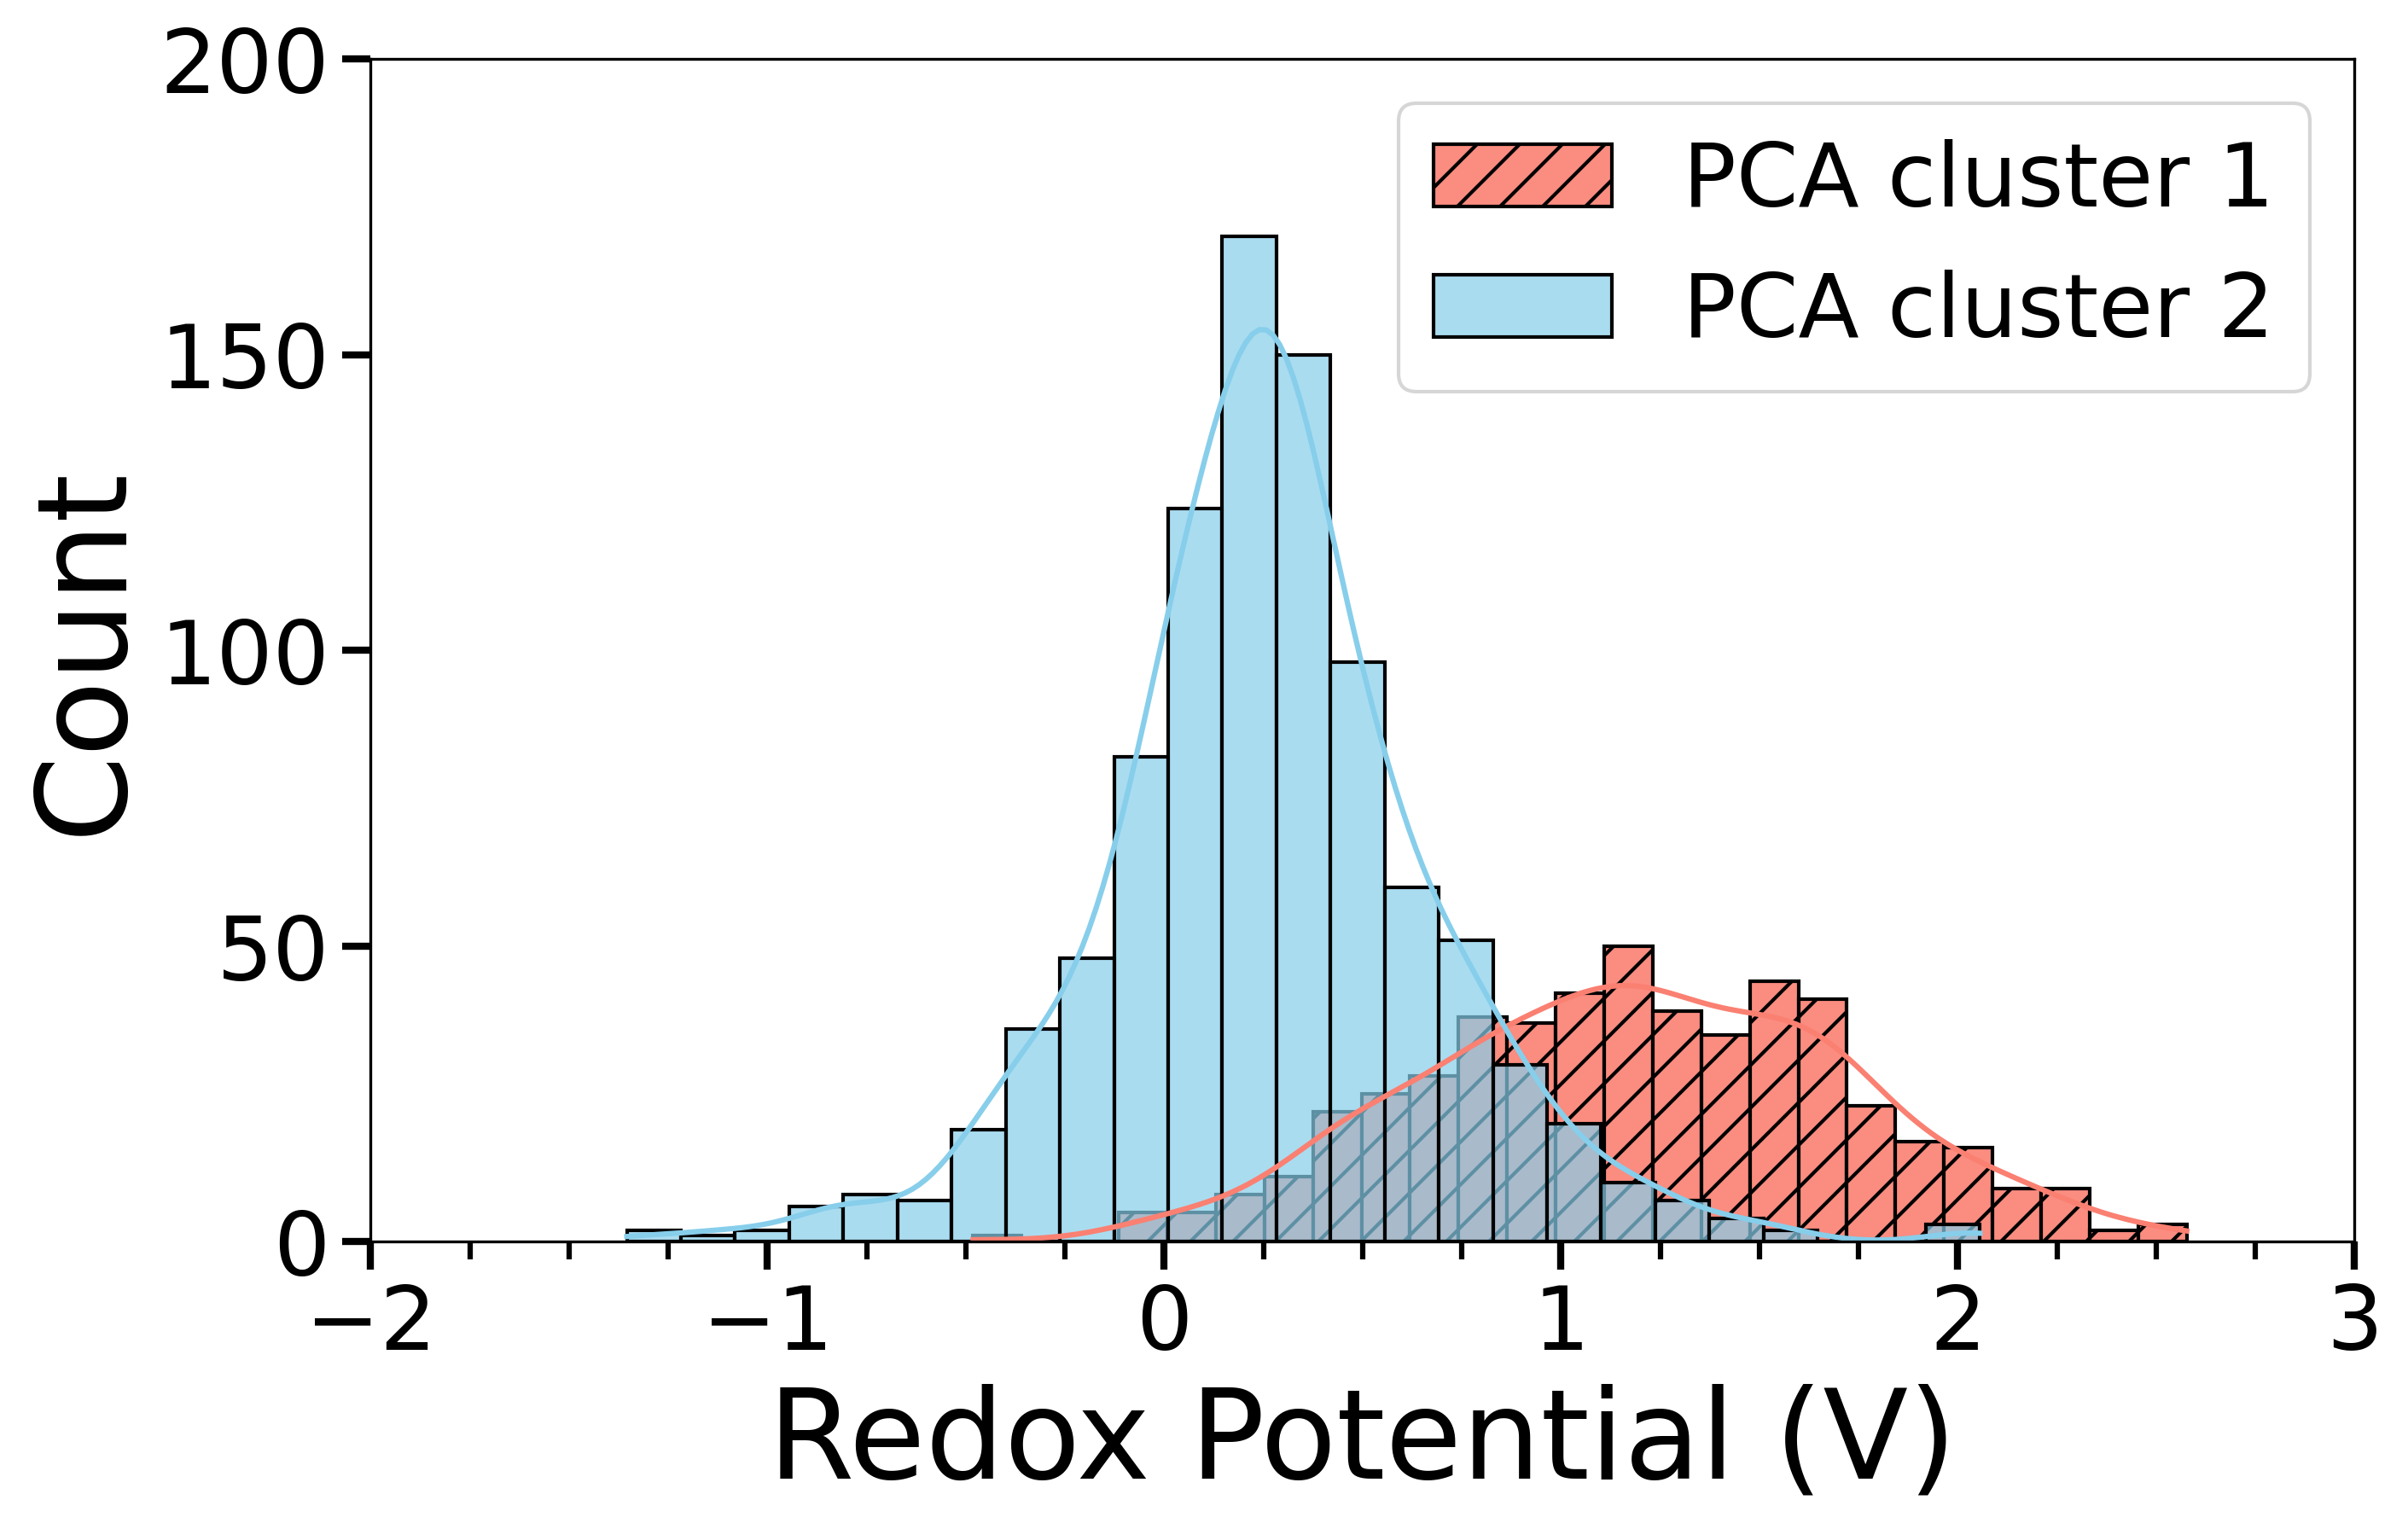

In [33]:
# histogram of the clusters

plt.figure(figsize=(10, 6), dpi=300)

# --- Plot Histogram for Cluster 0 ---
# Use alpha for transparency if histograms overlap
# Use a distinct color for each cluster
# The `ax` will be created by the first histplot call
ax = sns.histplot(cluster_0_y, kde=True, bins=25, label='PCA cluster 1', color='salmon', alpha=0.9, hatch='//')

# --- Plot Histogram for Cluster 1 on the SAME Axes ---
sns.histplot(cluster_1_y, kde=True, bins=25, label='PCA cluster 2', color='skyblue', alpha=0.7, ax=ax) # Pass the same 'ax'

# Add labels and title
plt.xlabel('Redox Potential (V)', fontsize=35)
plt.xlim([-2, 3]) # Keep your original x-limits or adjust
plt.xticks(fontsize=25)

plt.ylabel('Count', fontsize=35)
plt.ylim([0, 200]) 
plt.yticks(fontsize=25)

# Add a legend to distinguish the histograms
plt.legend(fontsize=25)

# Apply tick formatting (applies to the common axes 'ax')
ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=4)) # Set number of major ticks
ax.xaxis.set_minor_locator(AutoMinorLocator(4)) # 3 minor ticks between major ticks
ax.tick_params(which='major', length=8, width=2)
ax.tick_params(axis='x', which='minor', length=5, width=1.5)

# plt.grid(axis='y', alpha=0.75) # Optional
plt.savefig('./Figures/Redox_hist_clusters.png', transparent=True, bbox_inches='tight')

### Ligand Classification

In [34]:
from thermo.functional_groups import *

for i,mol in enumerate(df2use['mol'][:]):
    if i == 0:
        fragment_smiles_list = []
    fragment_smiles = get_ligand_smiles_after_fe_removal(mol)
    fragment_smiles_list.append(fragment_smiles)

unique_ligands = set()
for i,smiles_list in enumerate(fragment_smiles_list):
    for smiles in smiles_list:
        unique_ligands.add(smiles)
unique_ligands = list(unique_ligands)


halogens = ['F', 'Cl', 'Br', 'I']
exclude_smiles = [] #['[CH3-]', '[C-]#[NH+]']
inorganic_ligands = []
for smiles in unique_ligands:
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    if not is_organic(mol):
        # check if there are any C-C bonds or C-H bonds
        for bond in mol.GetBonds():
            if bond.GetBondTypeAsDouble() == 1.0:
                # check if both atoms are carbon
                atom1 = bond.GetBeginAtom()
                atom2 = bond.GetEndAtom()
                bond_sign = set([atom1.GetSymbol(), atom2.GetSymbol()])
                if bond_sign == {'C','C'} or bond_sign == {'C','H'}:
                    #print(f"Found C-C or C-H bond in {smiles}")
                    exclude_smiles.append(smiles)
        # Single halogen atoms are also considered inorganic
        if len(mol.GetAtoms()) == 1 and mol.GetAtoms()[0].GetSymbol() in halogens:
            #print(f"Found single halogen atom in {smiles}")
            exclude_smiles.append(smiles)
        if smiles not in exclude_smiles:
            inorganic_ligands.append(smiles)


classes_info = defaultdict(list)
ligand_cls_info = {}

for mol in df2use['mol']:
    lig_smiles = get_ligand_smiles_after_fe_removal(mol)
    for smiles in lig_smiles:
        classification = classify_smiles(smiles, inorganic_ligands, halogens)
        if smiles not in classes_info[classification]:
            classes_info[classification].append(smiles)
        if smiles not in ligand_cls_info:
            ligand_cls_info[smiles] = classification
        else:
            # If already present, check if classifications match
            if ligand_cls_info[smiles] != classification:
                print(f"  Conflict for SMILES {smiles}: {ligand_cls_info[smiles]} vs {classification}")

### Drawing example ligands from each class

--- Class: Aromatic_CHN(O) ---


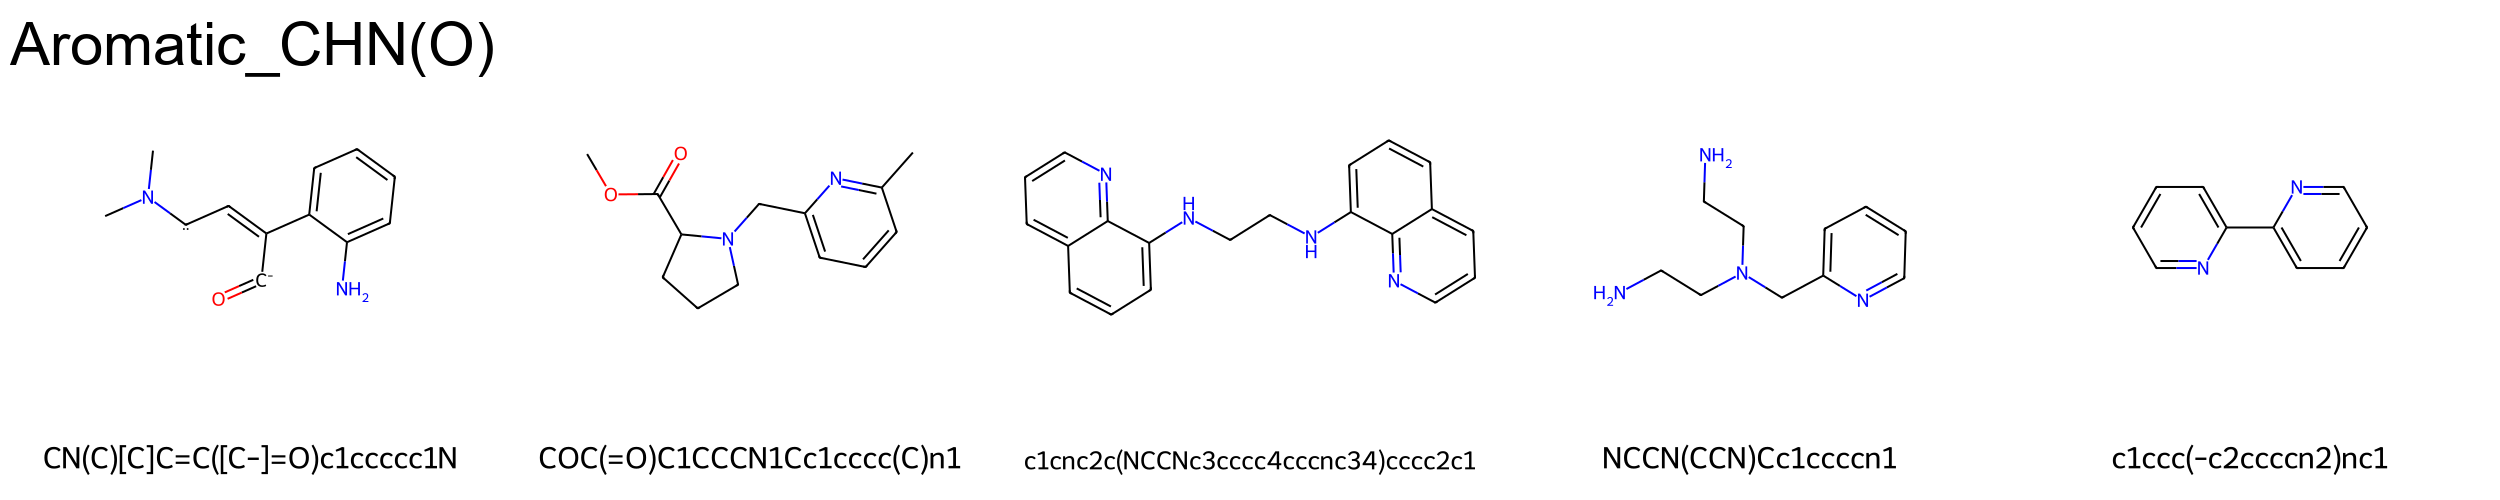



--- Class: Halogen ---


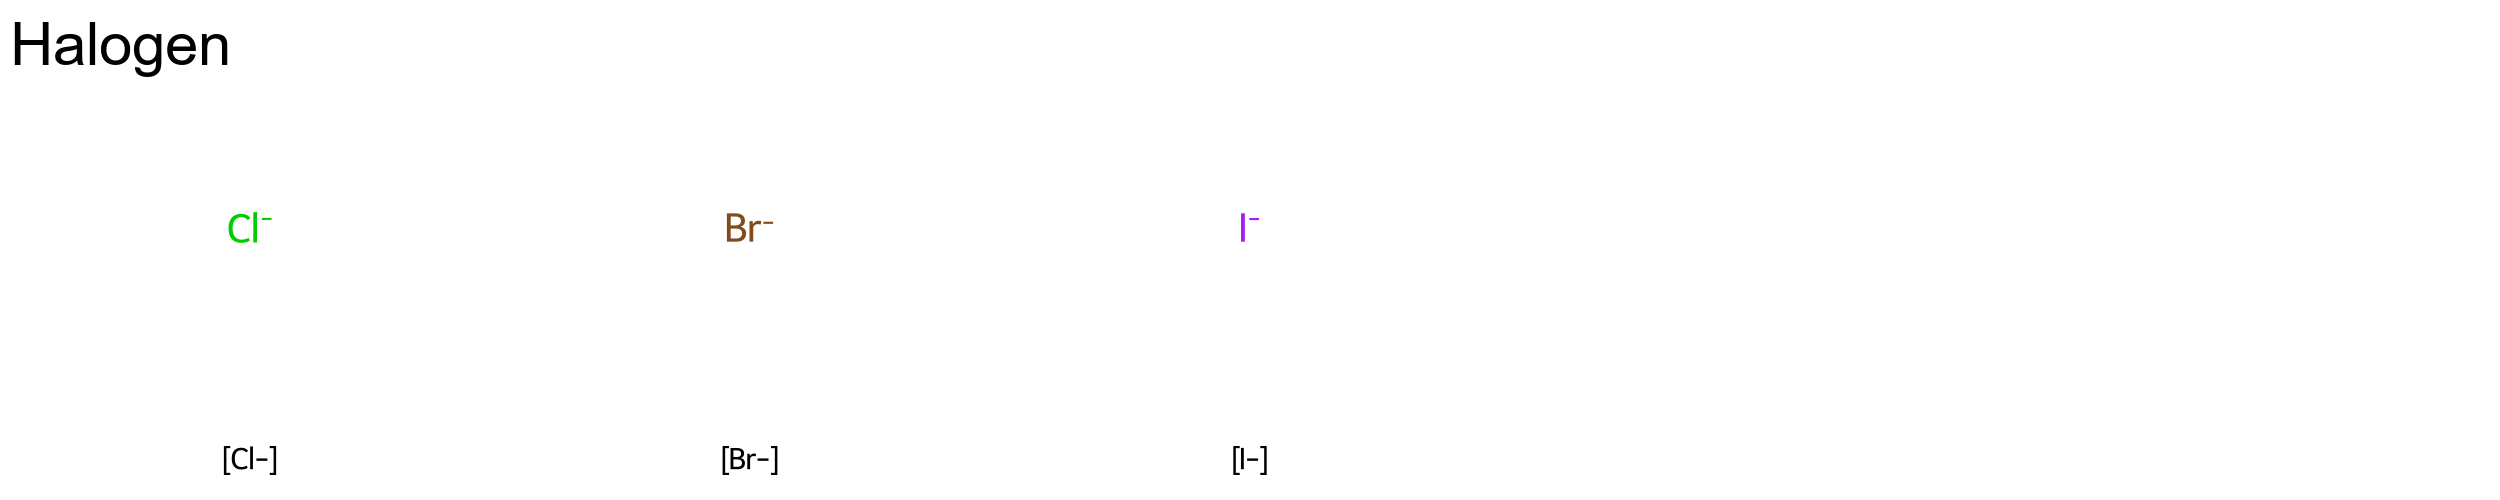



--- Class: Aromatic_multiHetero ---


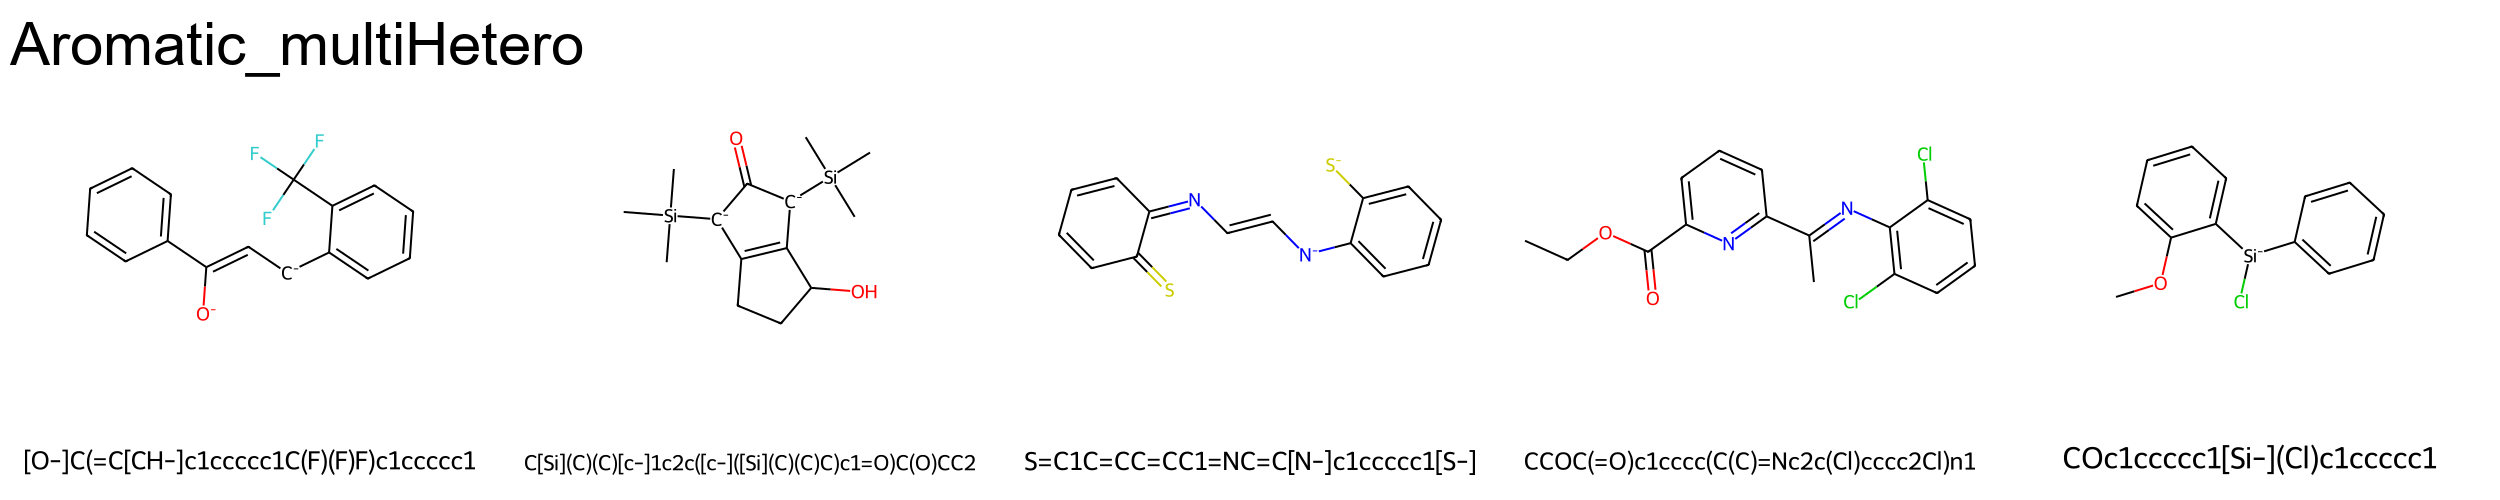



--- Class: Aromatic_monoHetero ---


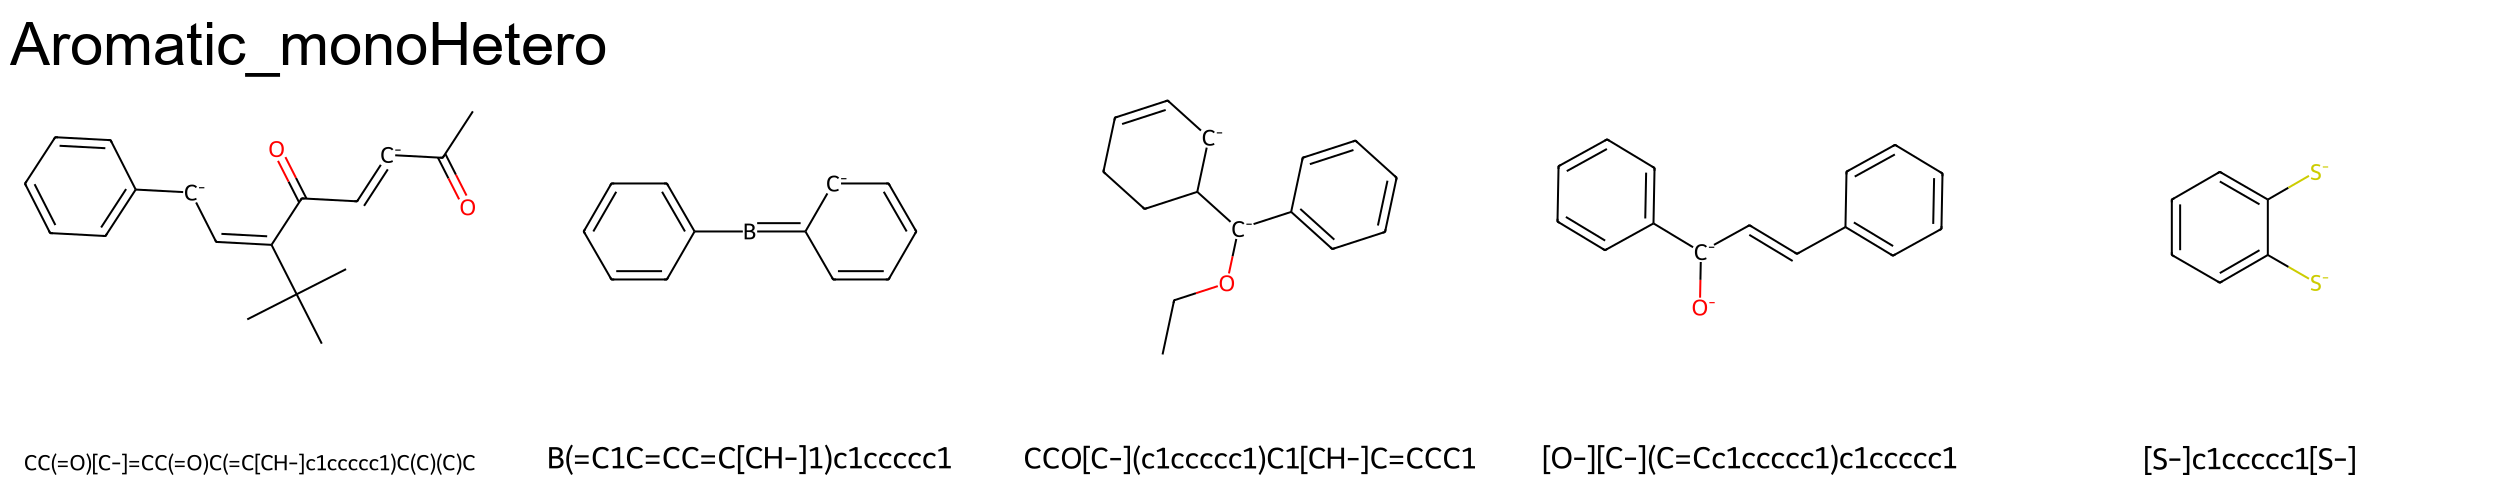



--- Class: Inorganic ---


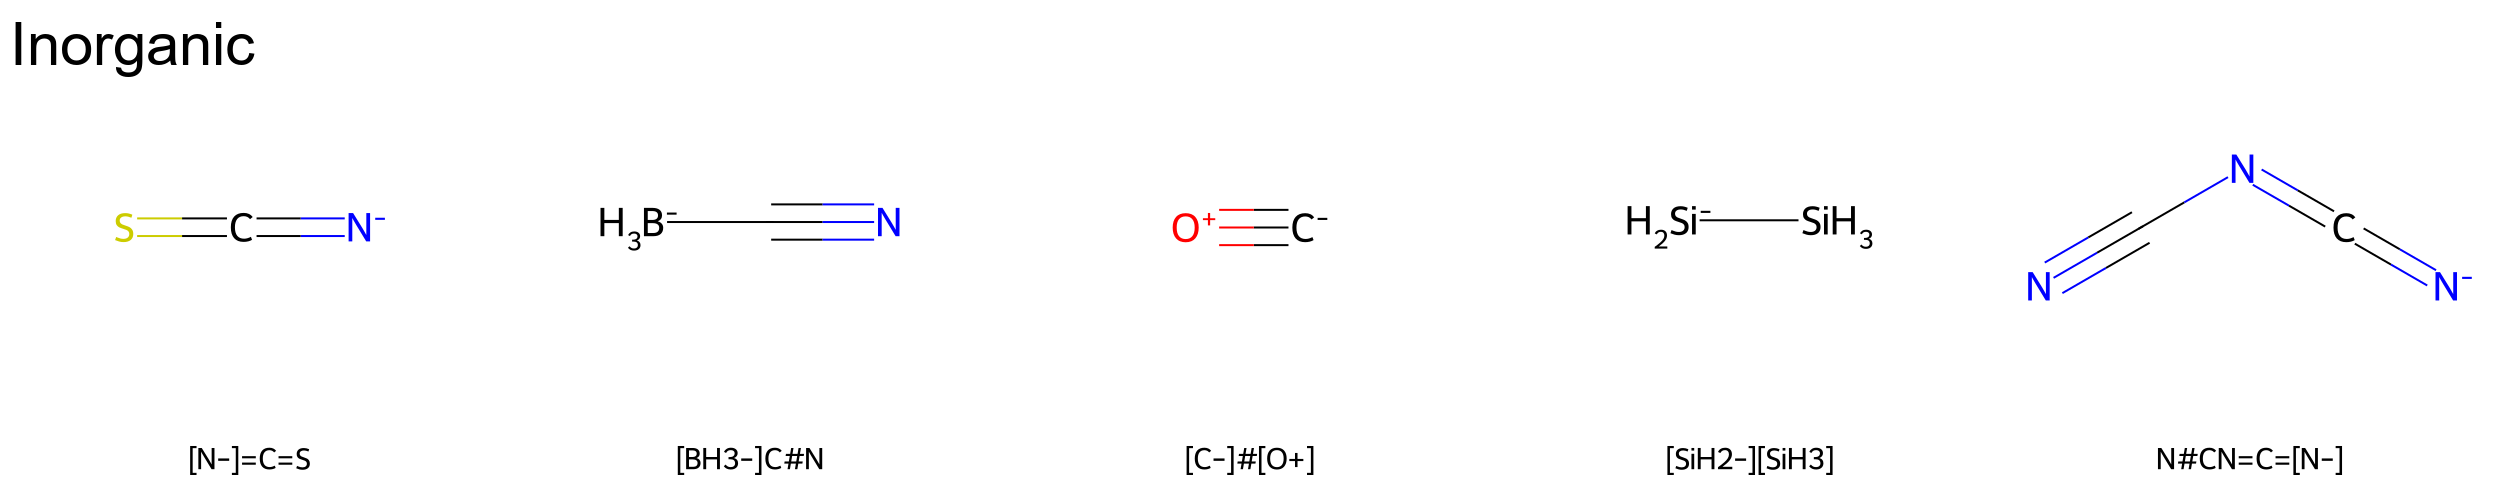



--- Class: Acyclic_Hetero ---


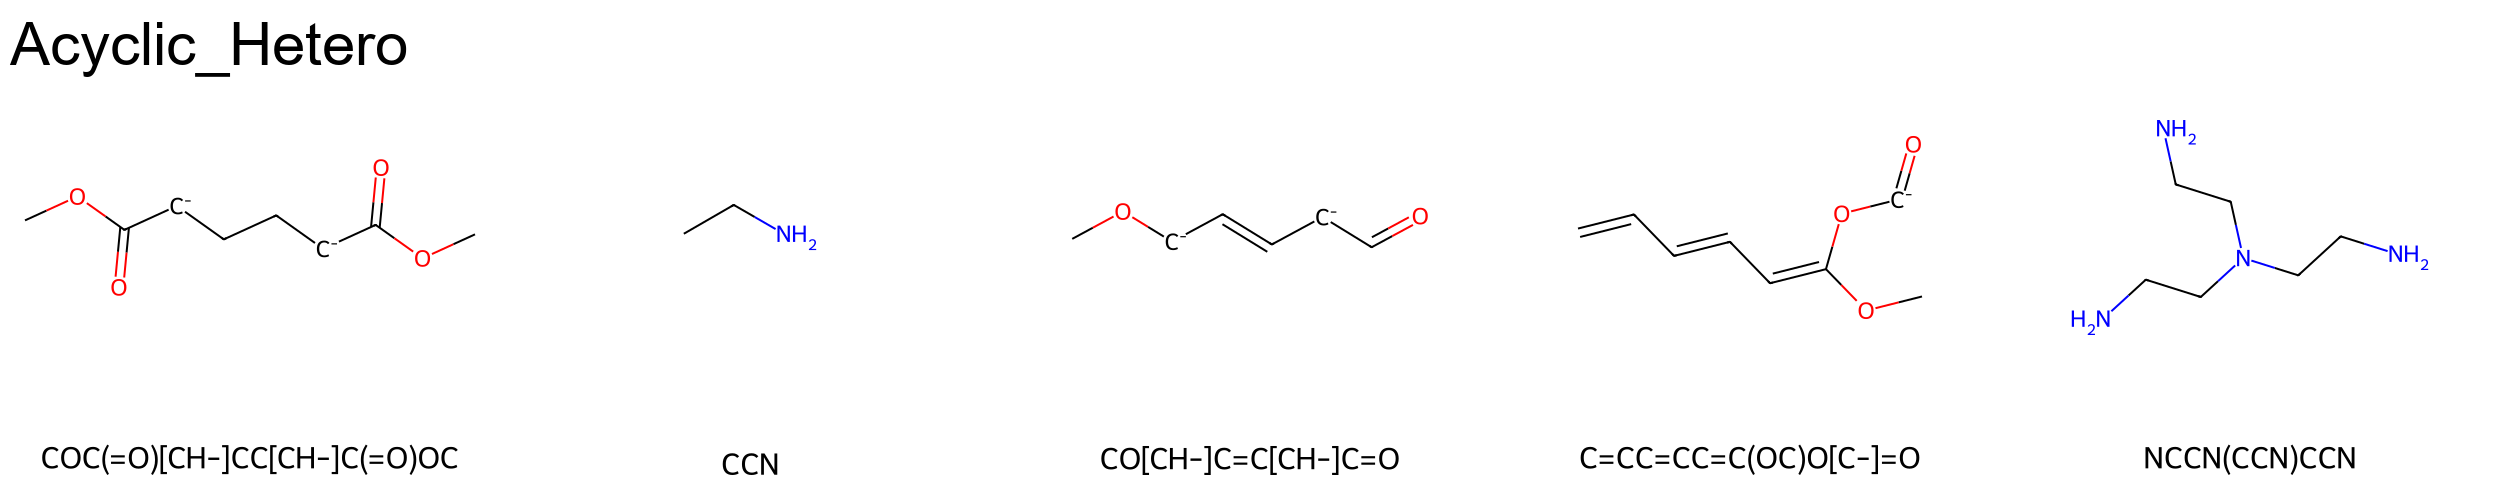



--- Class: Aromatic_CH ---


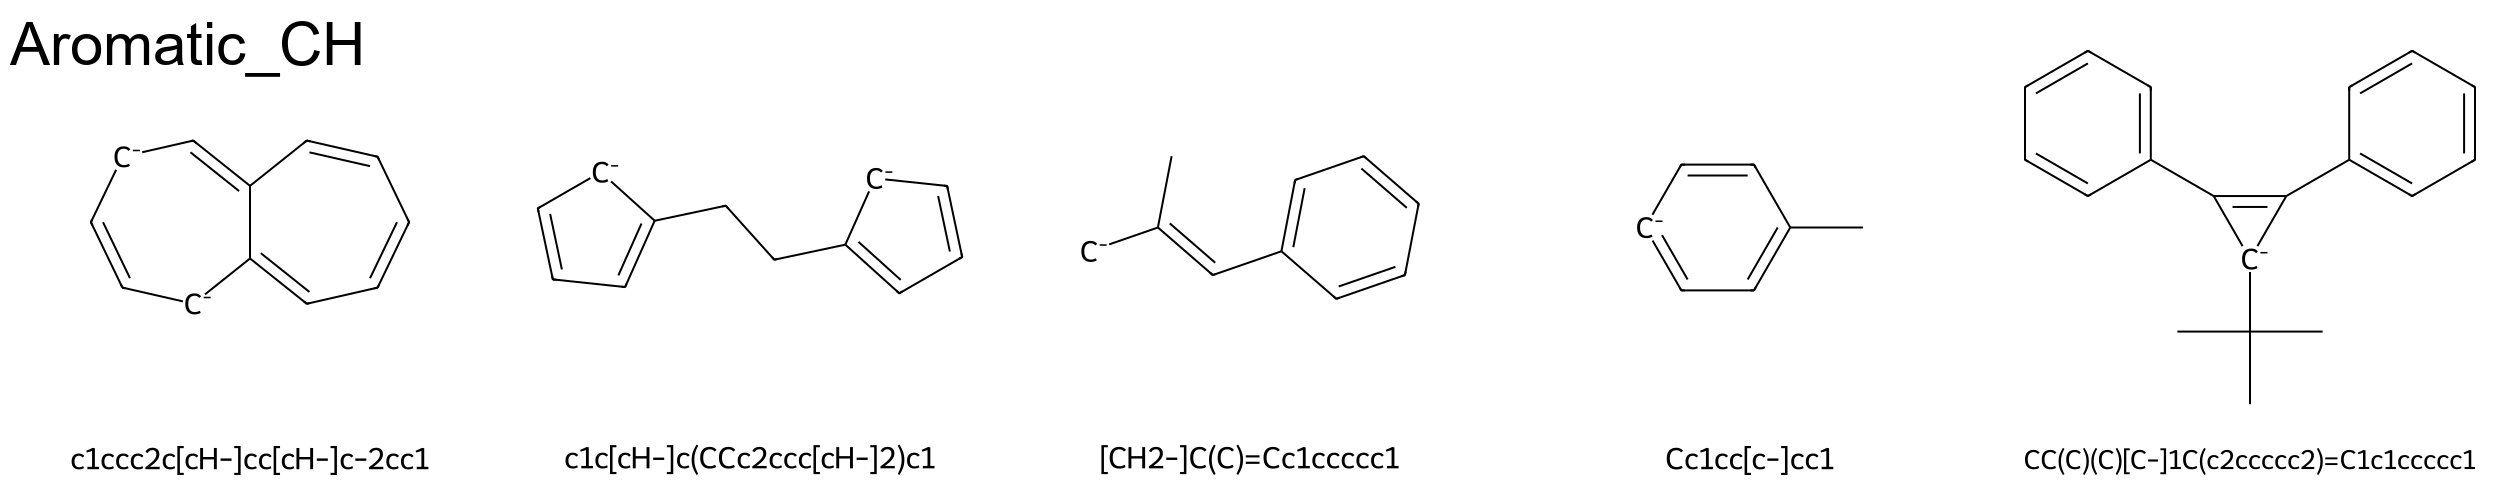



--- Class: Alicyclic_Hetero ---


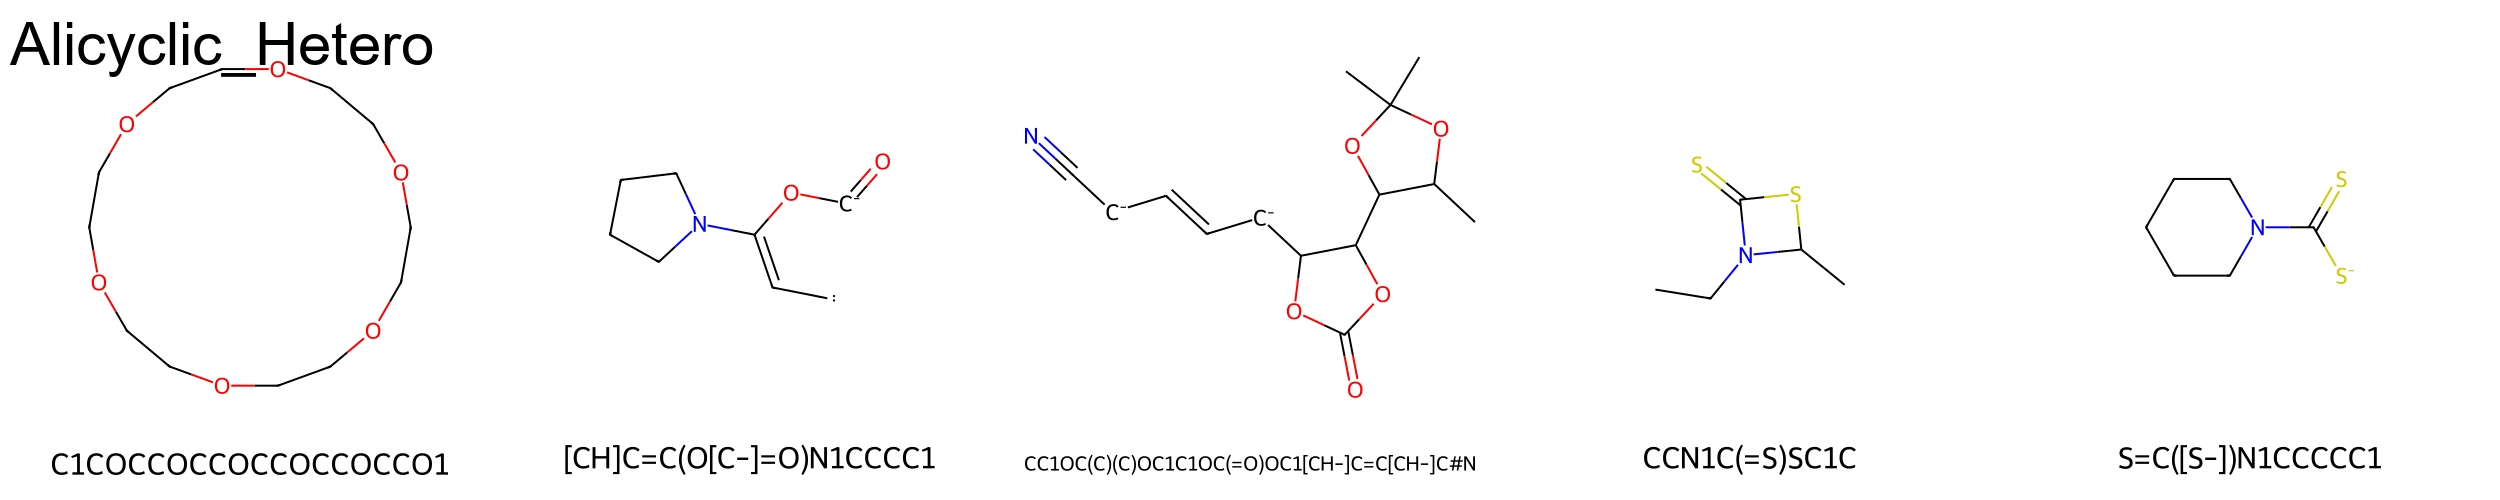



--- Class: Alicyclic_CH ---


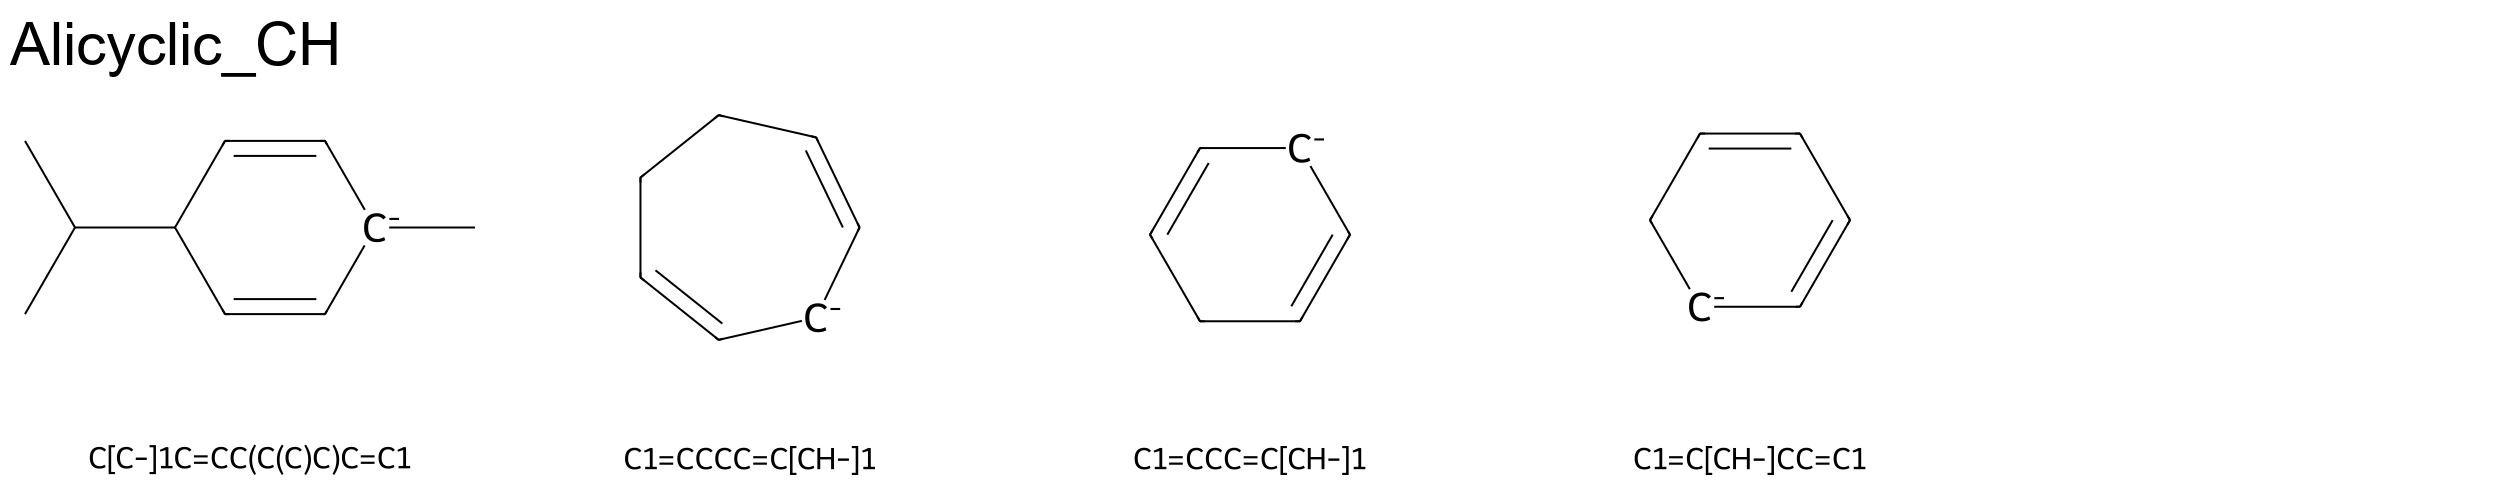



--- Class: Acyclic_CH ---


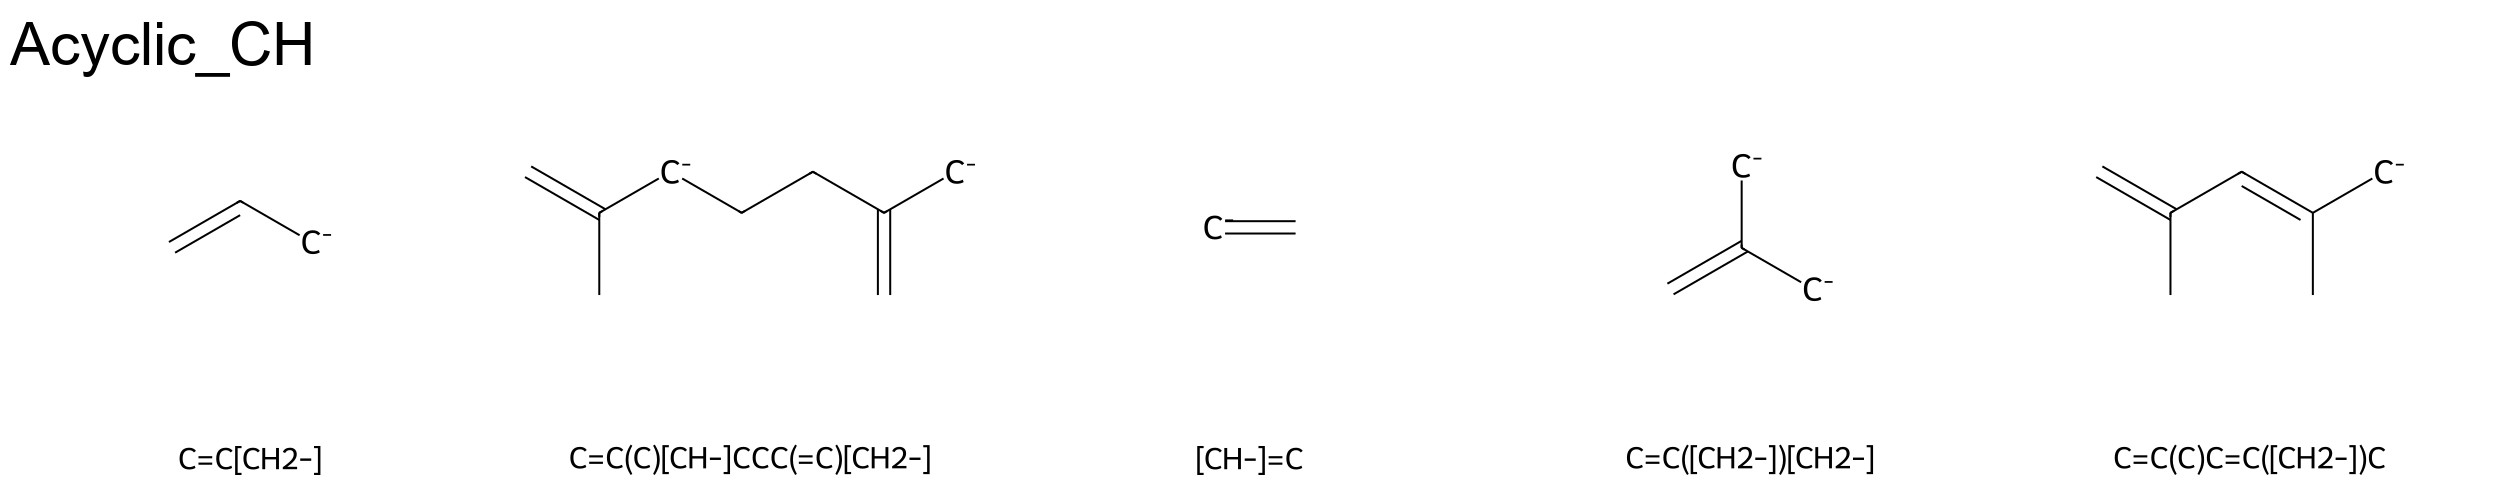

In [ ]:
import random
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import display, Image as IPImage # Import IPImage for displaying PIL images
from PIL import Image, ImageDraw, ImageFont # Import Pillow modules


for class_name, smiles_list in classes_info.items():
    print(f"--- Class: {class_name} ---")

    if not smiles_list:
        print(f"  No molecules in class '{class_name}' to display.")
        print("\n" + "="*50 + "\n")
        continue

    # Determine the number of molecules to sample (up to 5)
    num_to_sample = min(5, len(smiles_list))

    if num_to_sample == 0:
        print(f"  No molecules to sample in class '{class_name}'.")
        print("\n" + "="*50 + "\n")
        continue

    selected_smiles = random.sample(smiles_list, num_to_sample)

    mols_to_draw = []
    legends_for_mols = []
    for smi in selected_smiles:
        mol = Chem.MolFromSmiles(smi)
        if mol:
            mols_to_draw.append(mol)
            legends_for_mols.append(smi)
        else:
            print(f"  Warning: Could not parse SMILES '{smi}' from class '{class_name}'. Skipping.")

    if not mols_to_draw:
        print(f"  No valid molecules to draw for class '{class_name}'.")
        print("\n" + "="*50 + "\n")
        continue

    # --- Legend Text Size Adjustment ---
    # This value impacts the overall size of each molecule drawing.
    sub_image_width = 500
    sub_image_height = 500

    # Create the grid image (as a PIL Image object)
    draw_opts = Draw.rdMolDraw2D.MolDrawOptions()
    draw_opts.legendFontSize = 30      # or whatever size you like
    #draw_opts.padding = 0.1            # optional: tweak margins

    pil_image = Draw.MolsToGridImage(
        mols_to_draw,
        molsPerRow=5,
        subImgSize=(sub_image_width, sub_image_height),
        legends=legends_for_mols,
        drawOptions=draw_opts,
        returnPNG=False #
    )

    # --- Add Title/Text to the PIL Image ---
    if pil_image:
        # Make the image editable
        drawable_image = pil_image.convert("RGBA") # Convert to RGBA if not already for transparency handling
        draw = ImageDraw.Draw(drawable_image)

        # --- Font for the title ---
        try:
            # Try to load a common system font. Adjust path or font name as needed.
            font_size = 60 # Adjust as needed
            font = ImageFont.truetype("arial.ttf", font_size) # Example, replace with a known font on your system
        except IOError:
            print("  Warning: Arial font not found. Using default PIL font for title.")
            font = ImageFont.load_default() # Fallback font
            font_size = 20 # Default font is usually smaller


        # --- Position and draw the title ---
        title_text = str(class_name) # Ensure it's a string
        try:
            text_bbox = font.getbbox(title_text) # For Pillow >= 9.2.0
            text_width = text_bbox[2] - text_bbox[0]
            text_height = text_bbox[3] - text_bbox[1]
        except AttributeError: # Fallback for older Pillow
             try:
                text_width, text_height = draw.textsize(title_text, font=font)
             except AttributeError: # Even older Pillow or no draw object yet
                text_width, text_height = (len(title_text) * font_size / 2, font_size) # Rough estimate


        padding = 10 # Padding from the edge
        text_x = padding
        text_y = padding

        # Draw a semi-transparent background box for the title for better readability (optional)
        # box_padding = 5
        # draw.rectangle(
        #     (text_x - box_padding, text_y - box_padding,
        #      text_x + text_width + box_padding, text_y + text_height + box_padding),
        #     fill=(255, 255, 255, 180)  # White with some transparency
        # )

        draw.text((text_x, text_y), title_text, font=font, fill=(0, 0, 0, 255)) # Black text, fully opaque

        # --- Display the modified image ---
        import io
        img_byte_arr = io.BytesIO()
        drawable_image.save(img_byte_arr, format='PNG')
        img_byte_arr = img_byte_arr.getvalue()
        display(IPImage(data=img_byte_arr))

    else:
        print(f"  Failed to generate grid image for class '{class_name}'.")

    print("\n" + "="*50 + "\n")

In [40]:
# Draw ligand examples from each class; different technique

from io import BytesIO
import random
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import display, Image as IPImage # Import IPImage for displaying PIL images
from PIL import Image, ImageDraw, ImageFont # Import Pillow modules

def show_mol(d2d,mol,legend='',highlightAtoms=[]):
    d2d.DrawMolecule(mol,legend=legend, highlightAtoms=highlightAtoms)
    d2d.FinishDrawing()
    bio = BytesIO(d2d.GetDrawingText())
    return Image.open(bio)

def show_images(imgs,buffer=0, save_path=None):
    height = 0
    width = 0
    for img in imgs:
        height = max(height,img.height)
        width += img.width
    width += buffer*(len(imgs)-1)
    res = Image.new("RGBA",(width,height))
    x = 0
    for img in imgs:
        res.paste(img,(x,0))
        x += img.width + buffer
    
    if save_path:
        res.save(save_path)

    return res

for class_name, smiles_list in classes_info.items():
    if class_name != "Aromatic_monoHetero":
        continue
    print(f"--- Class: {class_name} {len(smiles_list)}---")

    if not smiles_list:
        print(f"  No molecules in class '{class_name}' to display.")
        print("\n" + "="*50 + "\n")
        continue

    # Determine the number of molecules to sample (up to 5)
    num_to_sample = min(4, len(smiles_list))

    if num_to_sample == 0:
        print(f"  No molecules to sample in class '{class_name}'.")
        print("\n" + "="*50 + "\n")
        continue

    selected_smiles = random.sample(smiles_list, num_to_sample)

    legends_for_mols = []
    imgs = []
    for smi in selected_smiles:
        mol = Chem.MolFromSmiles(smi)
        if mol:
            legends_for_mols.append(smi)

            d2d = Draw.MolDraw2DCairo(500,500)
            dopts = d2d.drawOptions()
            dopts.baseFontSize = 1.0 # default is 0.6
            dopts.legendFontSize = 30
            imgs.append(show_mol(d2d,mol))#,legend='fixedFontSize 3'))
        else:
            print(f"  Warning: Could not parse SMILES '{smi}' from class '{class_name}'. Skipping.")
    
    pathname = f"./Figures/ligand_examples/{class_name}.png"
    show_images(imgs) #, save_path=pathname)

    

--- Class: Aromatic_monoHetero 98---


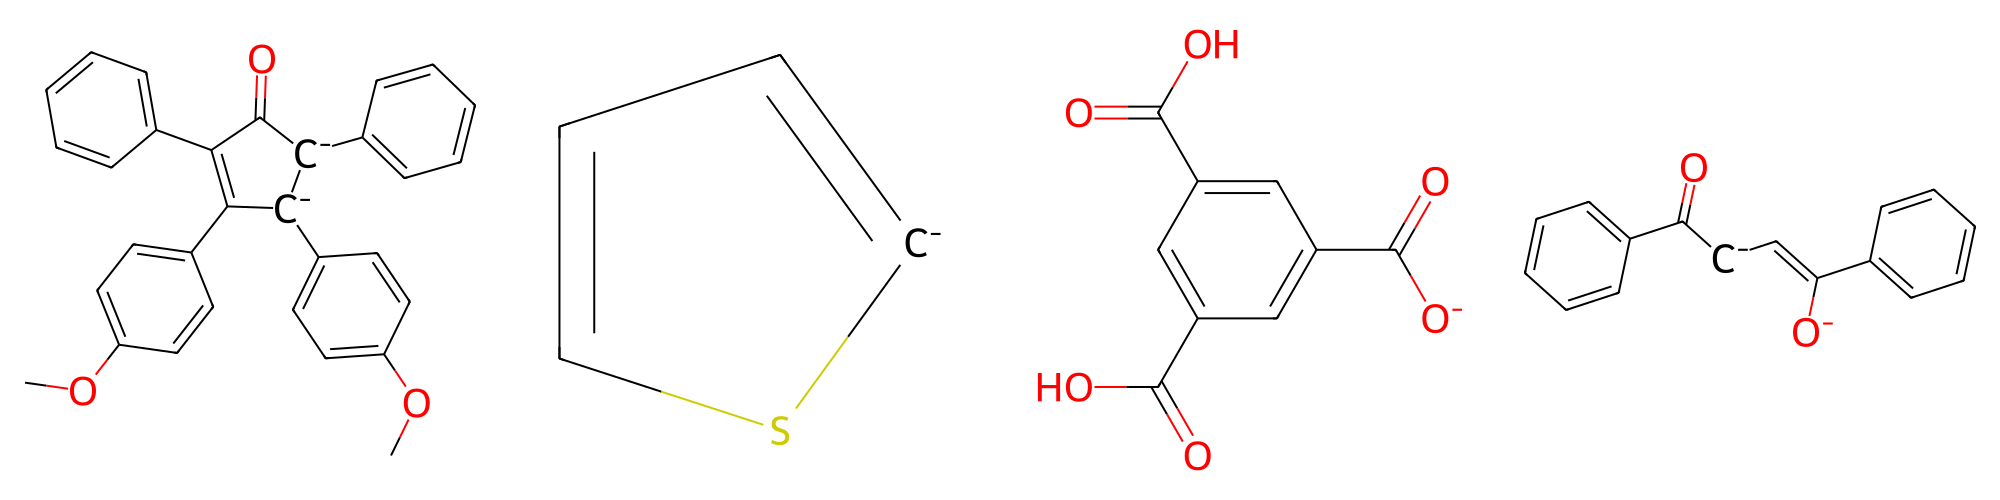

In [41]:
show_images(imgs)

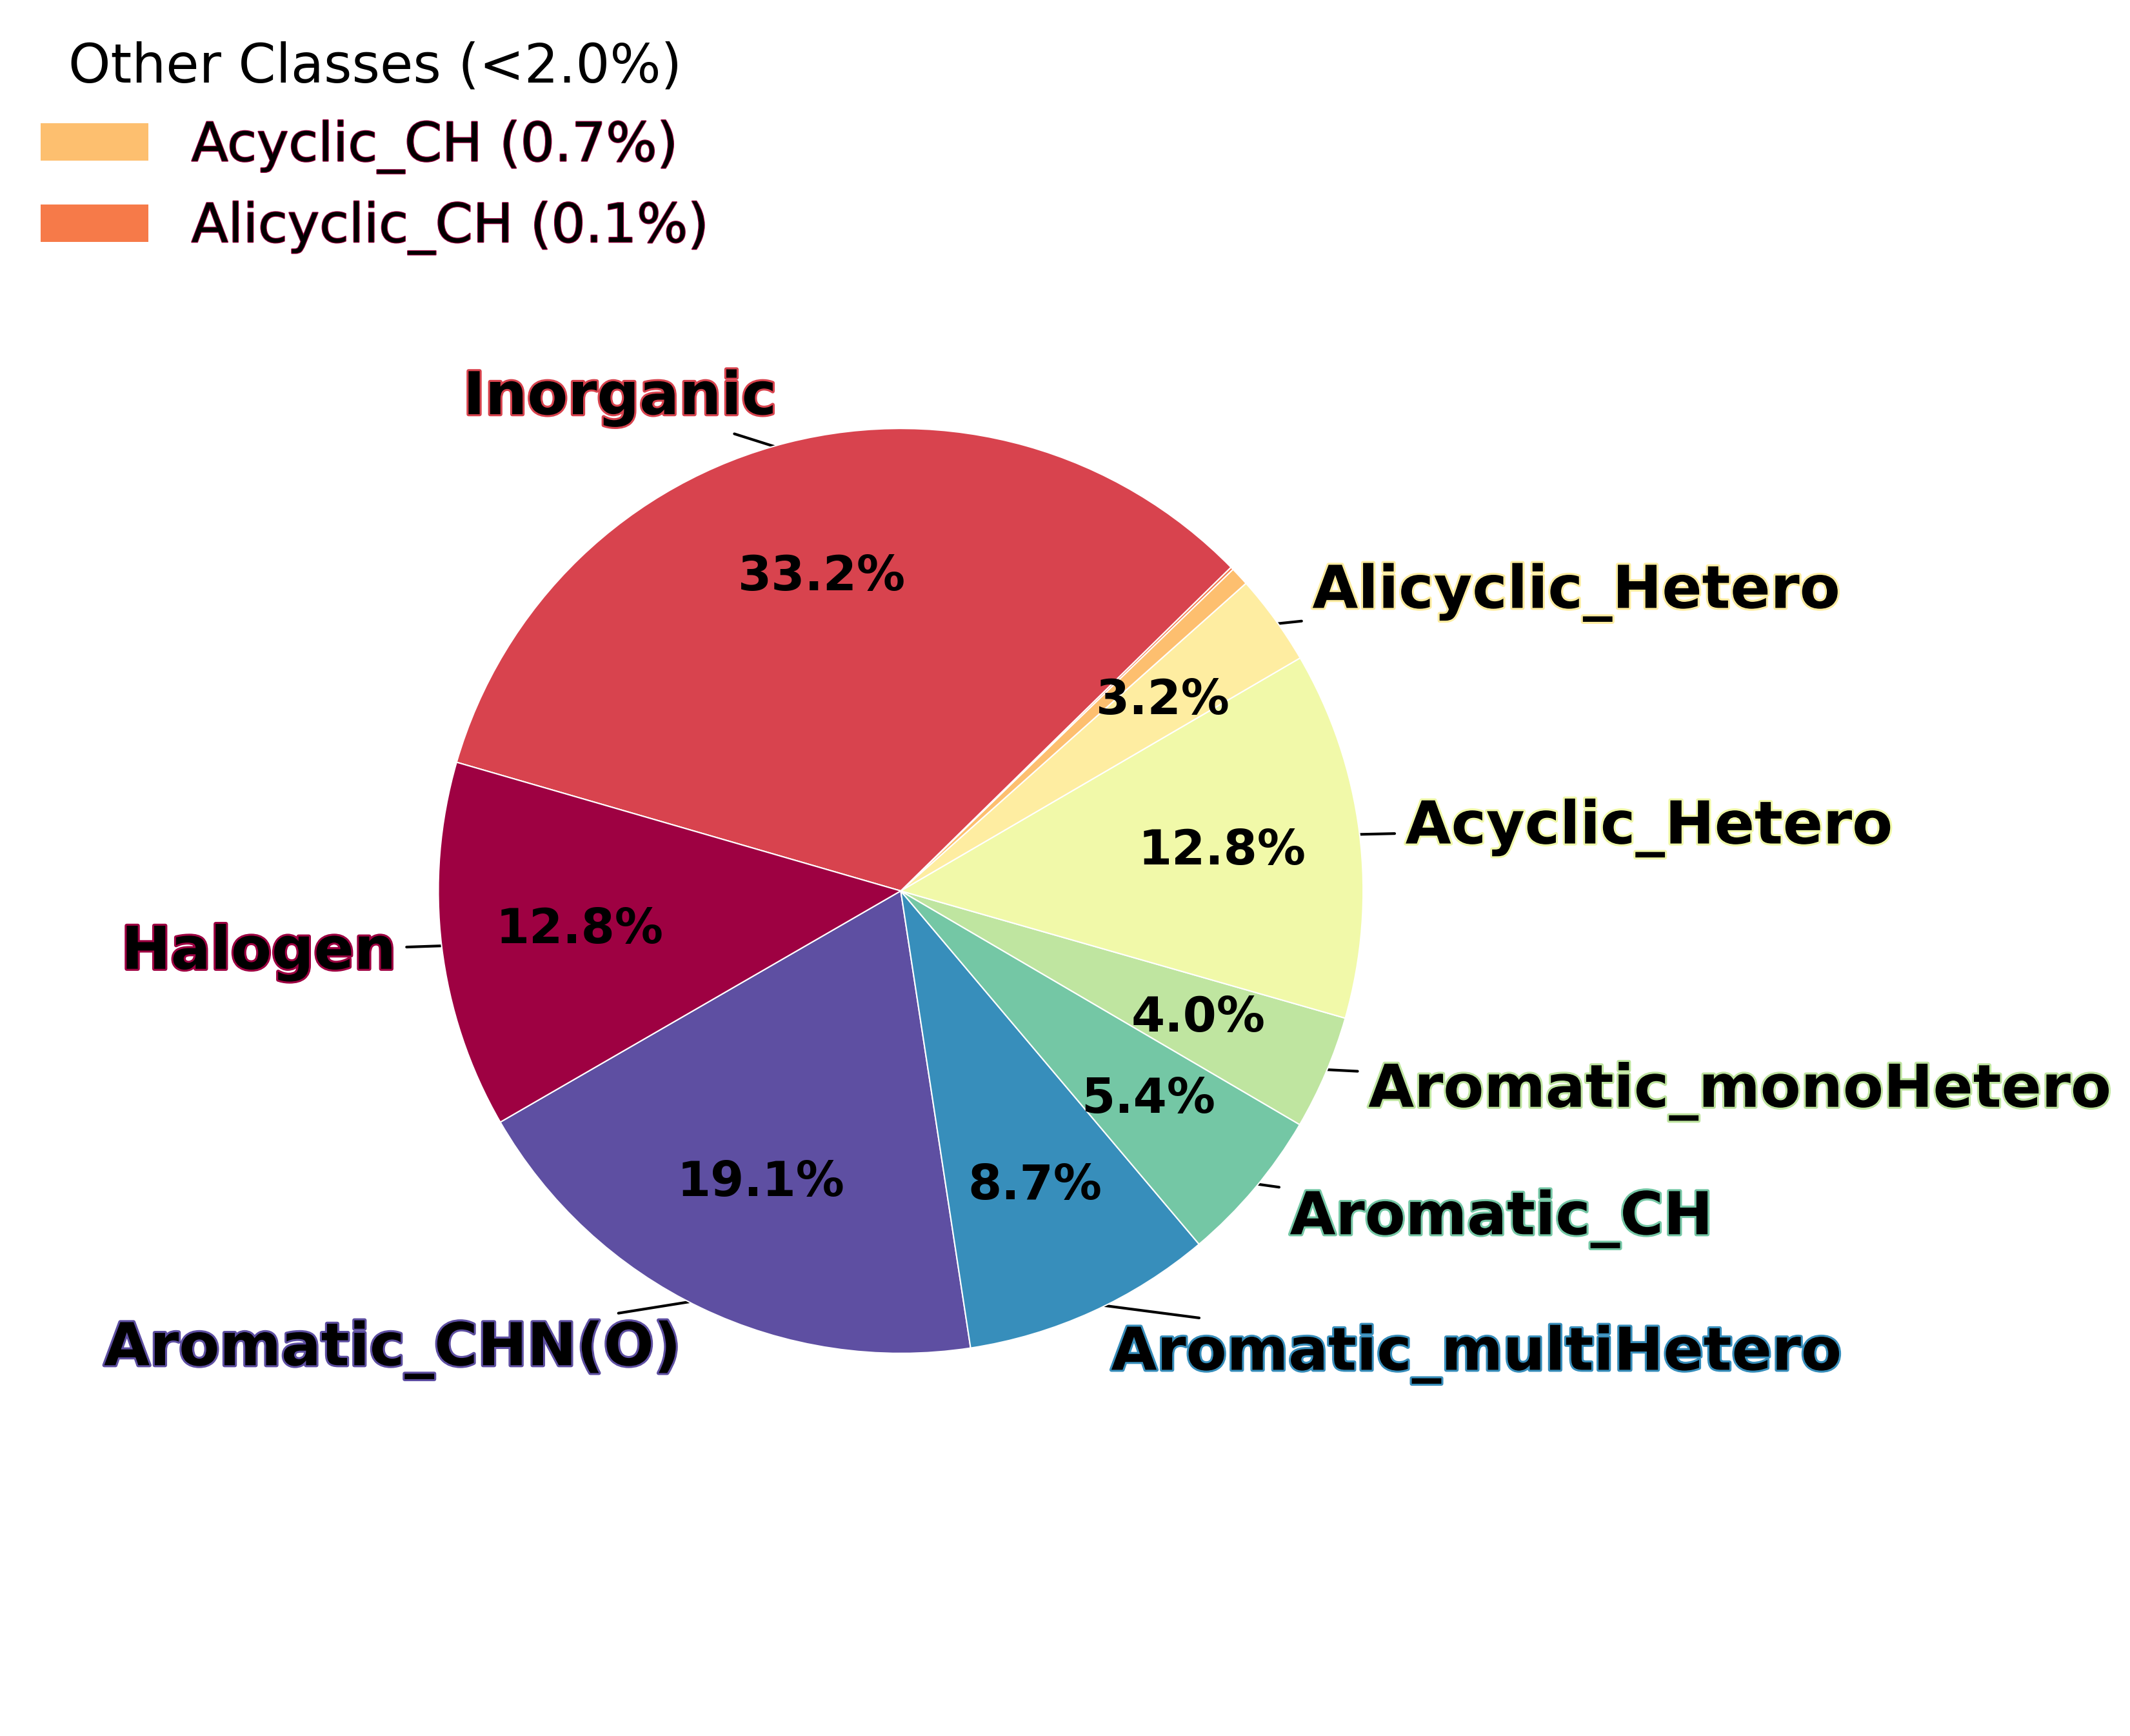

In [43]:
# Pie chart of the classes

all_ligands = []
all_ligand_cls_counter = defaultdict(int)
for mol in df2use['mol']:
    lig_smiles = get_ligand_smiles_after_fe_removal(mol)
    all_ligands.extend(lig_smiles)
    for smiles in lig_smiles:
        classification = classify_smiles(smiles, inorganic_ligands, halogens)
        all_ligand_cls_counter[classification] += 1
all_ligand_cls_freq = {label: (count / len(all_ligands)) * 100 for label, count in all_ligand_cls_counter.items()}
sorted_ligand_freqs = sorted(all_ligand_cls_freq.items(), key=operator.itemgetter(1), reverse=True)


total_ligands = sum(all_ligand_cls_counter.values())


# Calculate percentages
all_ligand_cls_percent = {
    label: (count / total_ligands) * 100
    for label, count in all_ligand_cls_counter.items()
}

# make a str all lowercase

# --- Custom Sorting Function ---
def sort_key(item):
    label, perc = item
    if label.lower().startswith('aro'): group = 0
    elif label.lower().startswith('ali'): group = 1
    elif label.lower().startswith('acy'): group = 1
    else: group = 2
    return (group, -perc) # Sort by group, then by percentage descending

# Sort items
sorted_items = sorted(all_ligand_cls_percent.items(), key=sort_key)

# Separate labels, percentages, and counts
sorted_labels = [item[0] for item in sorted_items]
sorted_percents = [item[1] for item in sorted_items]
sorted_counts = [all_ligand_cls_counter[label] for label in sorted_labels]

# --- Pie Chart Plotting ---

fig, ax = plt.subplots(figsize=(12, 10), dpi=300) # Adjusted size slightly for legend room

# Define threshold
percent_threshold = 2.0

# Custom autopct function (only show &gt;= threshold)
def func_autopct(pct):
    return f"{pct:.1f}%" if pct >= percent_threshold else ""

# --- Get the colormap ---
n_slices = len(sorted_counts)
cmap = colormaps.get_cmap('Spectral') #('gist_rainbow')
#slice_colors = [cmap(i / n_slices) for i in range(n_slices)]
slice_colors = cmap(np.linspace(1, 0, n_slices))


# --- Plot the pie chart WITH SPECIFIED COLORS ---
radius = 0.7 # Adjust radius for better fit
wedges, texts, autotexts = ax.pie(
    sorted_counts,
    autopct=func_autopct,
    startangle=210, # Your preferred start angle
    pctdistance=0.7, # Place percentage inside
    colors=slice_colors, # &lt;&lt;&lt; USE THE GENERATED COLORS HERE &gt;&gt;&gt;
    wedgeprops={'linewidth': 0.5, 'edgecolor': 'white'},
    radius=radius
)

# Style autopct text
for autotext in autotexts:
    autotext.set_color('k')
    autotext.set_weight('bold')
    autotext.set_fontsize(18) # Adjusted autopct font size slightly


# --- Custom Labeling and Legend Preparation ---
# Base settings for annotate
kw = dict(arrowprops=dict(arrowstyle="-", color='gray', lw=0.7),
            zorder=0, va="center")

# Fixed distance for large slice labels
large_slice_label_radius = 1.1*radius

# Lists to store items for the legend
legend_handles = []
legend_labels = []

for i, p in enumerate(wedges):
    # Get data for this wedge
    percentage = sorted_percents[i]
    label_text = sorted_labels[i]
    wedge_color = p.get_facecolor() # Get the color of the current wedge (now from colormap)

    if percentage >= percent_threshold:
        # --- Large Slices: Annotate beside the pie ---
        ang = (p.theta2 - p.theta1)/2. + p.theta1 # Angle of the middle
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))

        # Use a straight line connector for simplicity
        kw['arrowprops'].update({"connectionstyle": None, "arrowstyle": "-", "color": 'k', "lw": 1})  # wedge_color

        # Horizontal alignment
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]

        # Calculate text position
        text_x = large_slice_label_radius * x
        text_y = large_slice_label_radius * y

        # --- Draw annotation for large slices ---
        import matplotlib.patheffects as path_effects
        ax.annotate(label_text,
                    xy=(x*0.98*radius, y*0.98*radius), # Point on wedge edge
                    xytext=(text_x, text_y),
                    horizontalalignment=horizontalalignment,
                    color='k', #wedge_color, # Match text color to wedge
                    fontsize=22, # Adjusted label font size
                    fontweight='bold',
                    path_effects=[
                                path_effects.Stroke(linewidth=1.5, foreground=wedge_color),
                                path_effects.Normal()],
                    **kw)
    else:
        # --- Small Slices: Add to legend ---
        # Create a dummy patch for the legend with the wedge color
        legend_handles.append(plt.Rectangle((0, 0), 1, 1, fc=wedge_color)) # wedge_color
        # Add the label text and its percentage for the legend
        legend_labels.append(f"{label_text} ({percentage:.1f}%)")


# --- Add the Legend for Small Slices ---
if legend_handles: # Only add legend if there are items for it
    leg = ax.legend(legend_handles, legend_labels,
                    title="Other Classes (<{:.1f}%)".format(percent_threshold),
                    loc="center left", # Position the legend
                    bbox_to_anchor=(-0.05, 0.95), # Place it outside the pie on the right
                    ncol = 1,
                    fontsize=20,
                    title_fontsize=20,
                    frameon=False)

    # Set legend text colors to match pie slices (handles)
    for i, text in enumerate(leg.get_texts()):
        text.set_color('k')#(legend_handles[i].get_facecolor())
        text.set_path_effects([
        path_effects.Stroke(linewidth=0.55
        , foreground=wedge_color),
        path_effects.Normal()
    ])


# ax.set_title("Ligand Class Distribution", pad=20) # Simpler title
# plt.axis('equal') # Handled by pie

plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust right margin for legend
plt.savefig('./Figures/Ligand_class_pie.png', transparent=True, bbox_inches='tight')


Analyzing Cluster 0...
  Found 510 complexes.
  Analyzed 2027 ligands from 510 complexes.
  Top 5 Ligand Classifications (Frequency %):
    - Inorganic: 50.2%
    - Aromatic_CH: 11.2%
    - Acyclic_Hetero: 9.6%
    - Aromatic_monoHetero: 7.7%
    - Aromatic_multiHetero: 7.4%

Analyzing Cluster 1...
  Found 940 complexes.
  Analyzed 3004 ligands from 940 complexes.
  Top 5 Ligand Classifications (Frequency %):
    - Aromatic_CHN(O): 28.5%
    - Inorganic: 21.7%
    - Halogen: 18.4%
    - Acyclic_Hetero: 15.0%
    - Aromatic_multiHetero: 9.7%

--- Overall Cluster Ligand Classification Analysis ---
Cluster 0 (510 complexes, 2027 ligands):
  Predominant ligand classifications: Inorganic (50.2%), Aromatic_CH (11.2%), Acyclic_Hetero (9.6%), Aromatic_monoHetero (7.7%), Aromatic_multiHetero (7.4%)
Cluster 1 (940 complexes, 3004 ligands):
  Predominant ligand classifications: Aromatic_CHN(O) (28.5%), Inorganic (21.7%), Halogen (18.4%), Acyclic_Hetero (15.0%), Aromatic_multiHetero (9.7%)


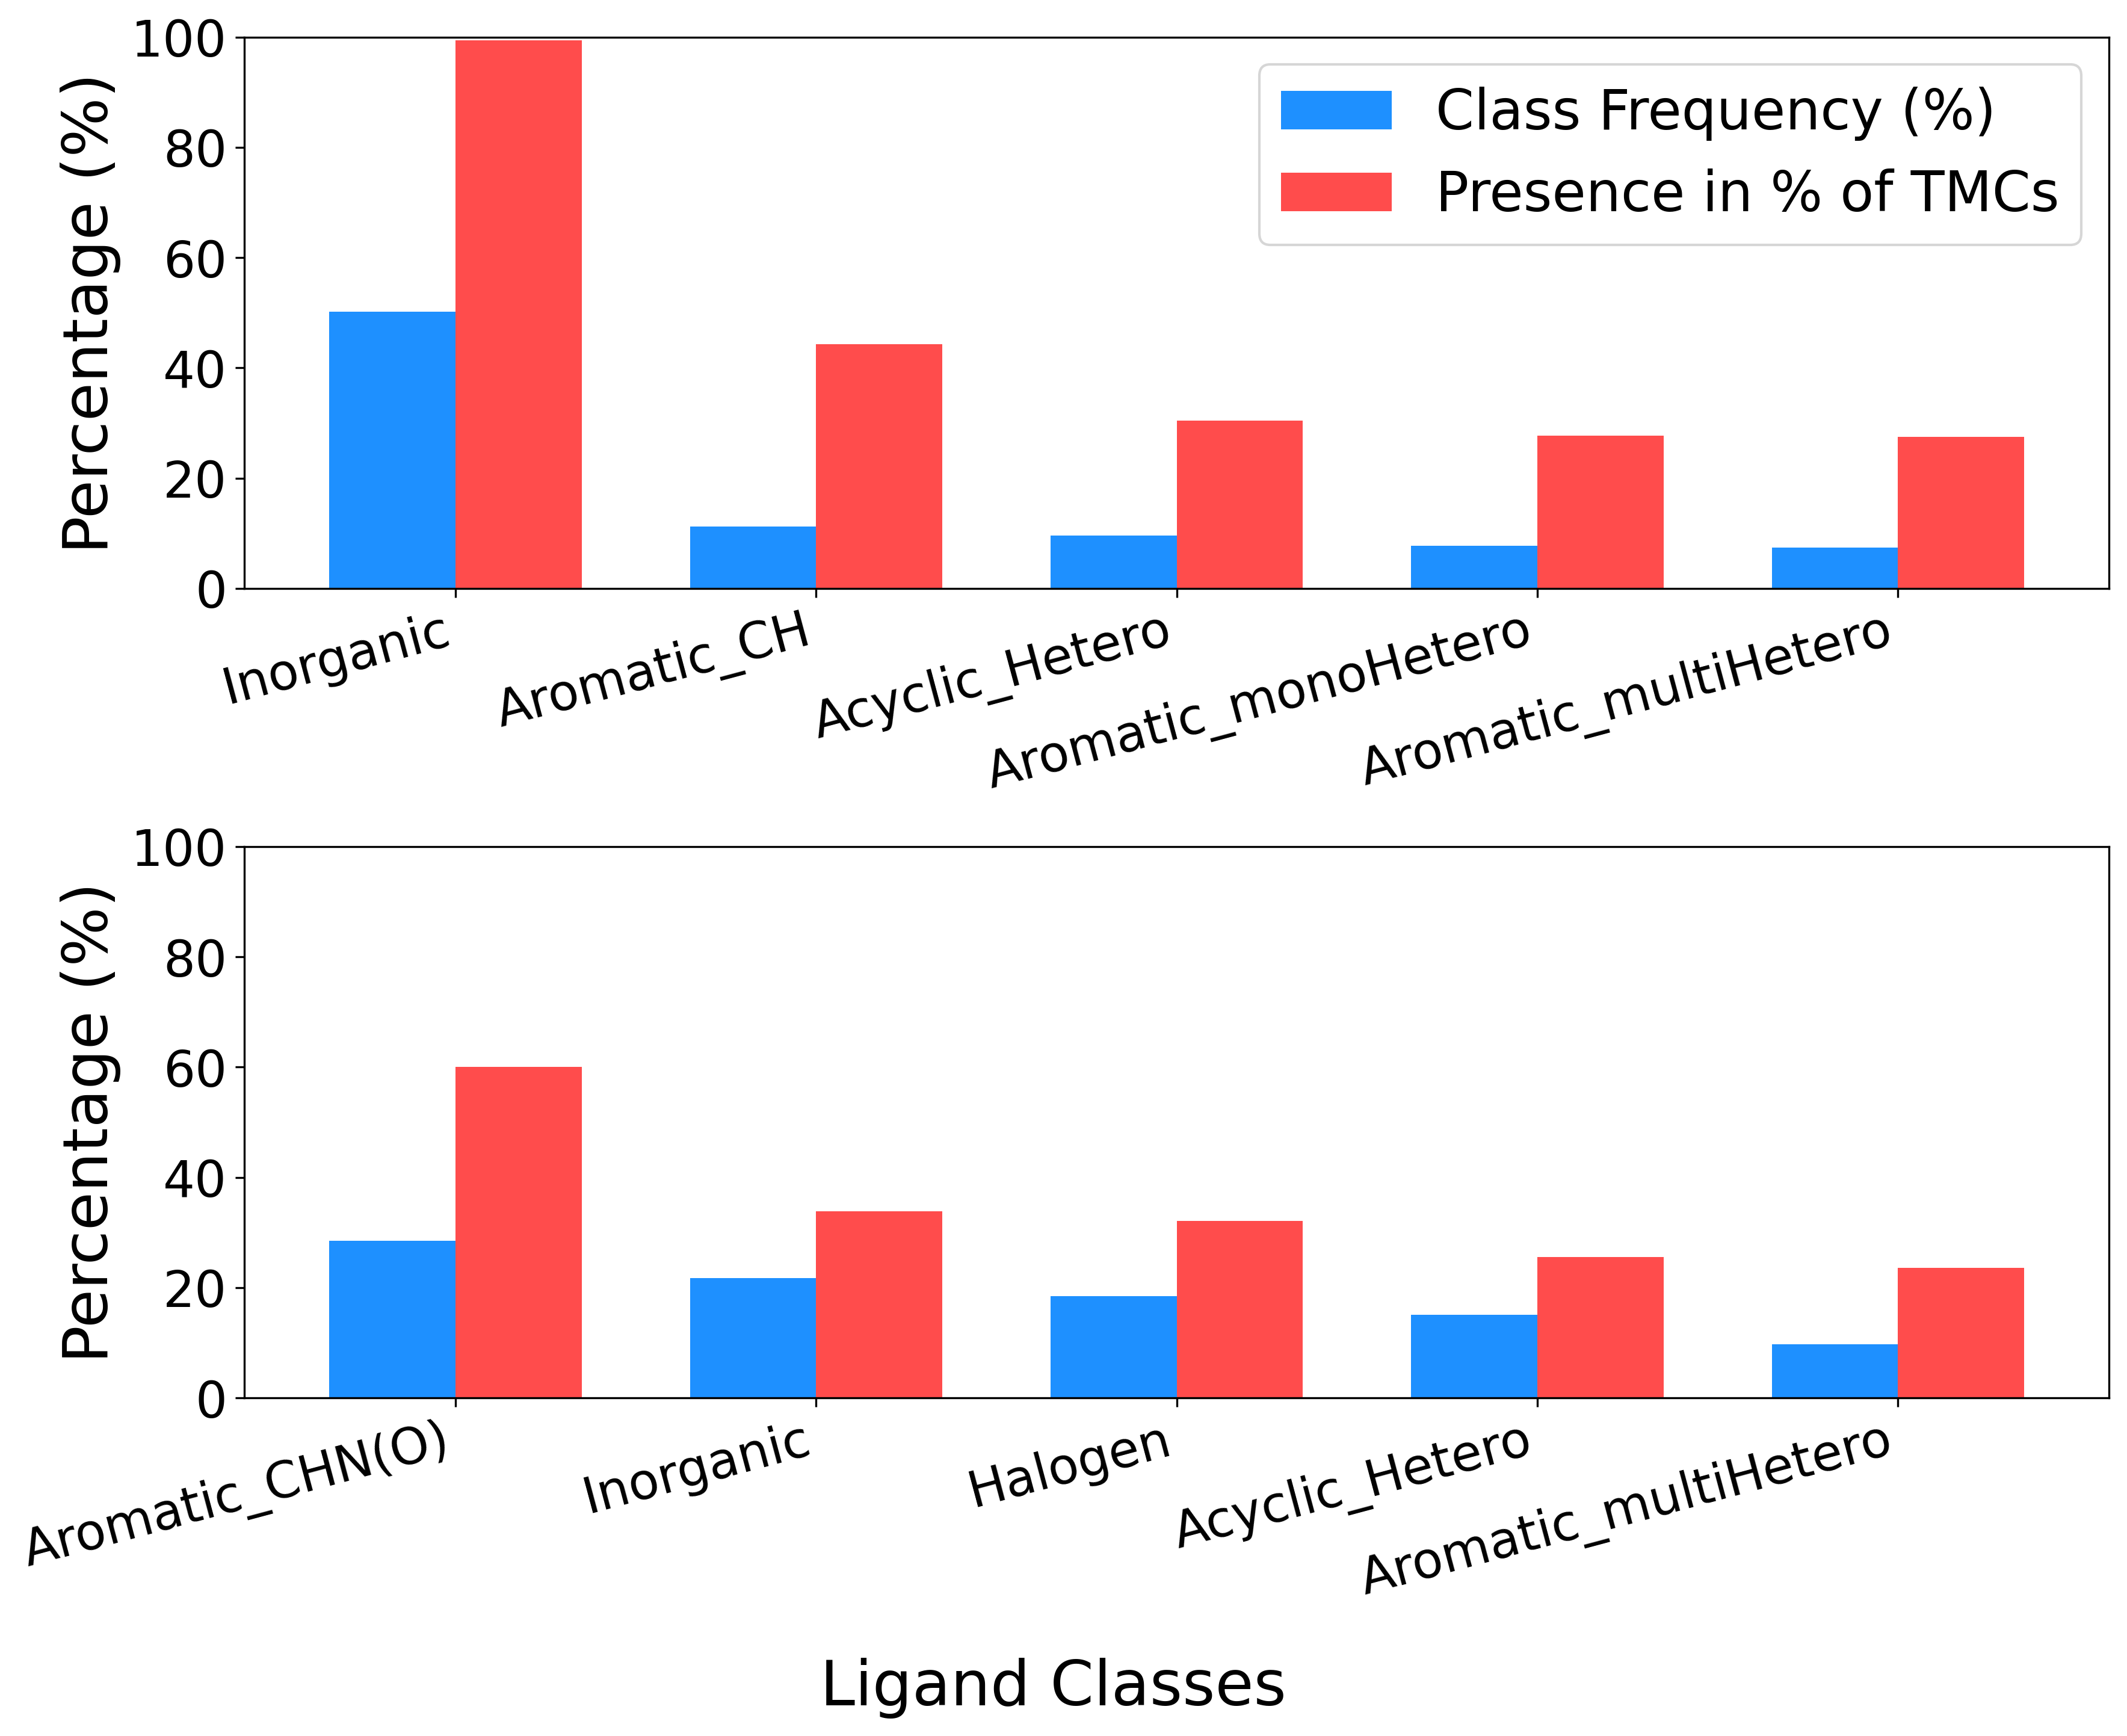

In [44]:
import operator


# --- Iterate Through Clusters and Analyze Fragments ---

cluster_classification_analysis = {} # Store results per cluster

for cluster_id in range(n_clusters):
    print(f"\nAnalyzing Cluster {cluster_id}...")

    # Get complexes belonging to the current cluster
    cluster_df = df2use[df2use['pca_cluster'] == cluster_id]
    cluster_mols = cluster_df['mol'].tolist() # Get the list of complex molecules
    num_complexes_in_cluster = len(cluster_mols) # Keep track of complexes for info

    if num_complexes_in_cluster == 0:
        print("  No complexes in this cluster. Skipping.")
        cluster_classification_analysis[cluster_id] = {
            "complex_count": 0,
            "ligand_count": 0,
            "top_classes": [],
            "ligand_frequencies": {}, 
            "tmc_presence_counts": defaultdict(int) # Store empty counts
        }
        continue

    print(f"  Found {num_complexes_in_cluster} complexes.")

    # Initialize counts for this cluster's classifications
    cluster_ligand_classification_counts = defaultdict(int)
    cluster_tmc_presence_counts = defaultdict(int) # Track counts per molecule
    total_ligands_in_cluster = 0

    # Iterate through complexes in this cluster
    for mol in cluster_mols:
        if not mol: continue # Skip invalid complex molecules

        # Get the list of ligand SMILES for the current complex
        lig_smiles = get_ligand_smiles_after_fe_removal(mol)


        # Iterate through LIGANDS for this complex
        lig_classes = set() # To avoid double counting ligands in the same complex
        for smiles in lig_smiles:
            # We count every valid ligand SMILES we attempt to classify
            total_ligands_in_cluster += 1

            # Classify the ligand based on its SMILES
            classification = classify_smiles(smiles, inorganic_ligands, halogens)
            lig_classes.add(classification) # Add to set to avoid duplicates
            
            # Record the classification category count for this cluster
            cluster_ligand_classification_counts[classification] += 1

        for lig_class in lig_classes:
            # Increment the count for this ligand classification
            cluster_tmc_presence_counts[lig_class] += 1


    # Calculate frequency (%) of each classification relative to the total number of ligands
    ligand_frequencies = {
        label: (count / total_ligands_in_cluster) * 100 if total_ligands_in_cluster > 0 else 0
        for label, count in cluster_ligand_classification_counts.items()
    }

    # Sort frequencies to find top classifications
    sorted_ligand_freqs = sorted(ligand_frequencies.items(), key=operator.itemgetter(1), reverse=True)


    tmc_frequencies = { # Calculate TMC frequencies just for reporting if needed
        label: (count / num_complexes_in_cluster) * 100 if num_complexes_in_cluster > 0 else 0
        for label, count in cluster_tmc_presence_counts.items()
    }
    sorted_tmc_freqs = sorted(tmc_frequencies.items(), key=operator.itemgetter(1), reverse=True)

    # Store results
    cluster_classification_analysis[cluster_id] = {
        "complex_count": num_complexes_in_cluster,
        "ligand_count": total_ligands_in_cluster,
        "top_classes": sorted_ligand_freqs[:5], # Top classes based on ligand frequency
        "ligand_frequencies": sorted_ligand_freqs, # Store ligand frequencies
        "tmc_presence_frequencies": sorted_tmc_freqs
    }

    print(f"  Analyzed {total_ligands_in_cluster} ligands from {num_complexes_in_cluster} complexes.")
    print(f"  Top 5 Ligand Classifications (Frequency %):")
    if sorted_ligand_freqs:
        for label, freq in sorted_ligand_freqs[:5]:
            print(f"    - {label}: {freq:.1f}%")
    else:
        print("    - No ligand classifications determined.")


# --- Report Overall Findings ---
print("\n--- Overall Cluster Ligand Classification Analysis ---")
for cluster_id, analysis in cluster_classification_analysis.items():
    # Use the counts stored in the analysis dictionary
    print(f"Cluster {cluster_id} ({analysis.get('complex_count', 0)} complexes, {analysis.get('ligand_count', 0)} ligands):")
    if analysis.get('top_classes'):
        top_str = ", ".join([f"{label} ({freq:.1f}%)" for label, freq in analysis['top_classes']])
        print(f"  Predominant ligand classifications: {top_str}")
    else:
        print("  No ligand classifications determined or no ligands found.")

# --- Visualization per cluster ---

DPI = 300

num_plot_items = 5 #-1 # Or set a limit like 15 if plots get too crowded

fig, axes = plt.subplots(n_clusters, 1, figsize=(12, n_clusters * 5), sharex=False, dpi=DPI) # Increased width slightly
if n_clusters == 1: axes = [axes] # Make axes iterable if only 1 cluster


for cluster_id, analysis in cluster_classification_analysis.items():
    ax = axes[cluster_id] # This is the primary axis (left)

    # Retrieve counts and frequencies needed
    complex_count = analysis.get('complex_count', 0)
    ligand_count = analysis.get('ligand_count', 0)
    ligand_frequencies = analysis.get('ligand_frequencies', {})
    tmc_presence_frequencies = analysis.get('tmc_presence_frequencies', defaultdict(int))

    
    
    # Sort based on ligand frequency to determine the order of bars
    #all_sorted_ligand_freqs = sorted(ligand_frequencies.items(), key=operator.itemgetter(1), reverse=True)

    # Limit the number of items to plot if num_plot_items is positive
    if num_plot_items > 0:
            ax1_plot_items = ligand_frequencies[:num_plot_items]
            ax2_plot_items = tmc_presence_frequencies[:num_plot_items]
    else:
        ax1_plot_items = ligand_frequencies # Show all
        ax2_plot_items = tmc_presence_frequencies # Show all

    plot_labels = [item[0] for item in ax1_plot_items]
    plot_ligand_freqs = [item[1] for item in ax1_plot_items]

    # Calculate the TMC presence percentage for the plotted labels
    plot_tmc_presence_percent = [item[1] for item in ax2_plot_items] 

    # --- Plotting Setup ---
    x_pos = np.arange(len(plot_labels)) # the label locations
    bar_width = 0.35 # the width of the bars

    # --- Plot Both Bar Series on the SAME Axis (ax) ---
    bars1 = ax.bar(x_pos - bar_width/2, plot_ligand_freqs, bar_width,
                    label='Class Frequency (%)', color='dodgerblue') # Add label for legend
    bars2 = ax.bar(x_pos + bar_width/2, plot_tmc_presence_percent, bar_width,
                    label='Presence in % of TMCs', color='red', alpha=0.7) # Add label for legend

    # --- Set Single Y-Axis Label and Ticks ---
    ax.set_ylabel('Percentage (%)', fontsize=25) # Single Y-axis label
    ax.tick_params(axis='y', labelsize=20) # Style Y-axis ticks
    ax.set_ylim(0, 100) # Set appropriate Y-limit (0-100% + headroom)

    # --- General Axes Formatting ---
    ax.set_xticks(x_pos)
    ax.set_xticklabels(plot_labels, rotation=15, ha='right', fontsize=20)

    #ax.set_title(f"Cluster {cluster_id+1} ({ligand_count} ligands from {complex_count} TMCs)", fontsize = 20)

    # --- Add Legend ---
    if cluster_id == 0: ax.legend(fontsize=22) # Display the legend using labels from ax.bar calls

# Set common x-label below all subplots
# Adjust figure layout to make room for labels and title
fig.text(0.5, 0.01, 'Ligand Classes', ha='center', va='center', fontsize=25)

fig.subplots_adjust(hspace=0.1)

plt.tight_layout(rect=[0, 0.04, 1, 0.95]) # Adjust rect bottom (0.04) to make space for common xlabel
#plt.show()

plt.savefig('./Figures/Cluster_classes.png', transparent=True, bbox_inches='tight')


Analyzing Cluster 0...
  Found 510 molecules.
  Top 5 Groups (Frequency %):
    - C: 100.0%
    - P: 34.3%
    - N: 29.8%
    - S: 14.7%
    - O: 9.8%

Analyzing Cluster 1...
  Found 940 molecules.
  Top 5 Groups (Frequency %):
    - N: 89.8%
    - O: 31.8%
    - Cl: 24.1%
    - C: 12.8%
    - P: 11.6%

--- Overall Cluster Fragment Analysis ---
Cluster 0 (510 molecules):
  Predominant groups: C (100.0%), P (34.3%), N (29.8%), S (14.7%), O (9.8%)
Cluster 1 (940 molecules):
  Predominant groups: N (89.8%), O (31.8%), Cl (24.1%), C (12.8%), P (11.6%)


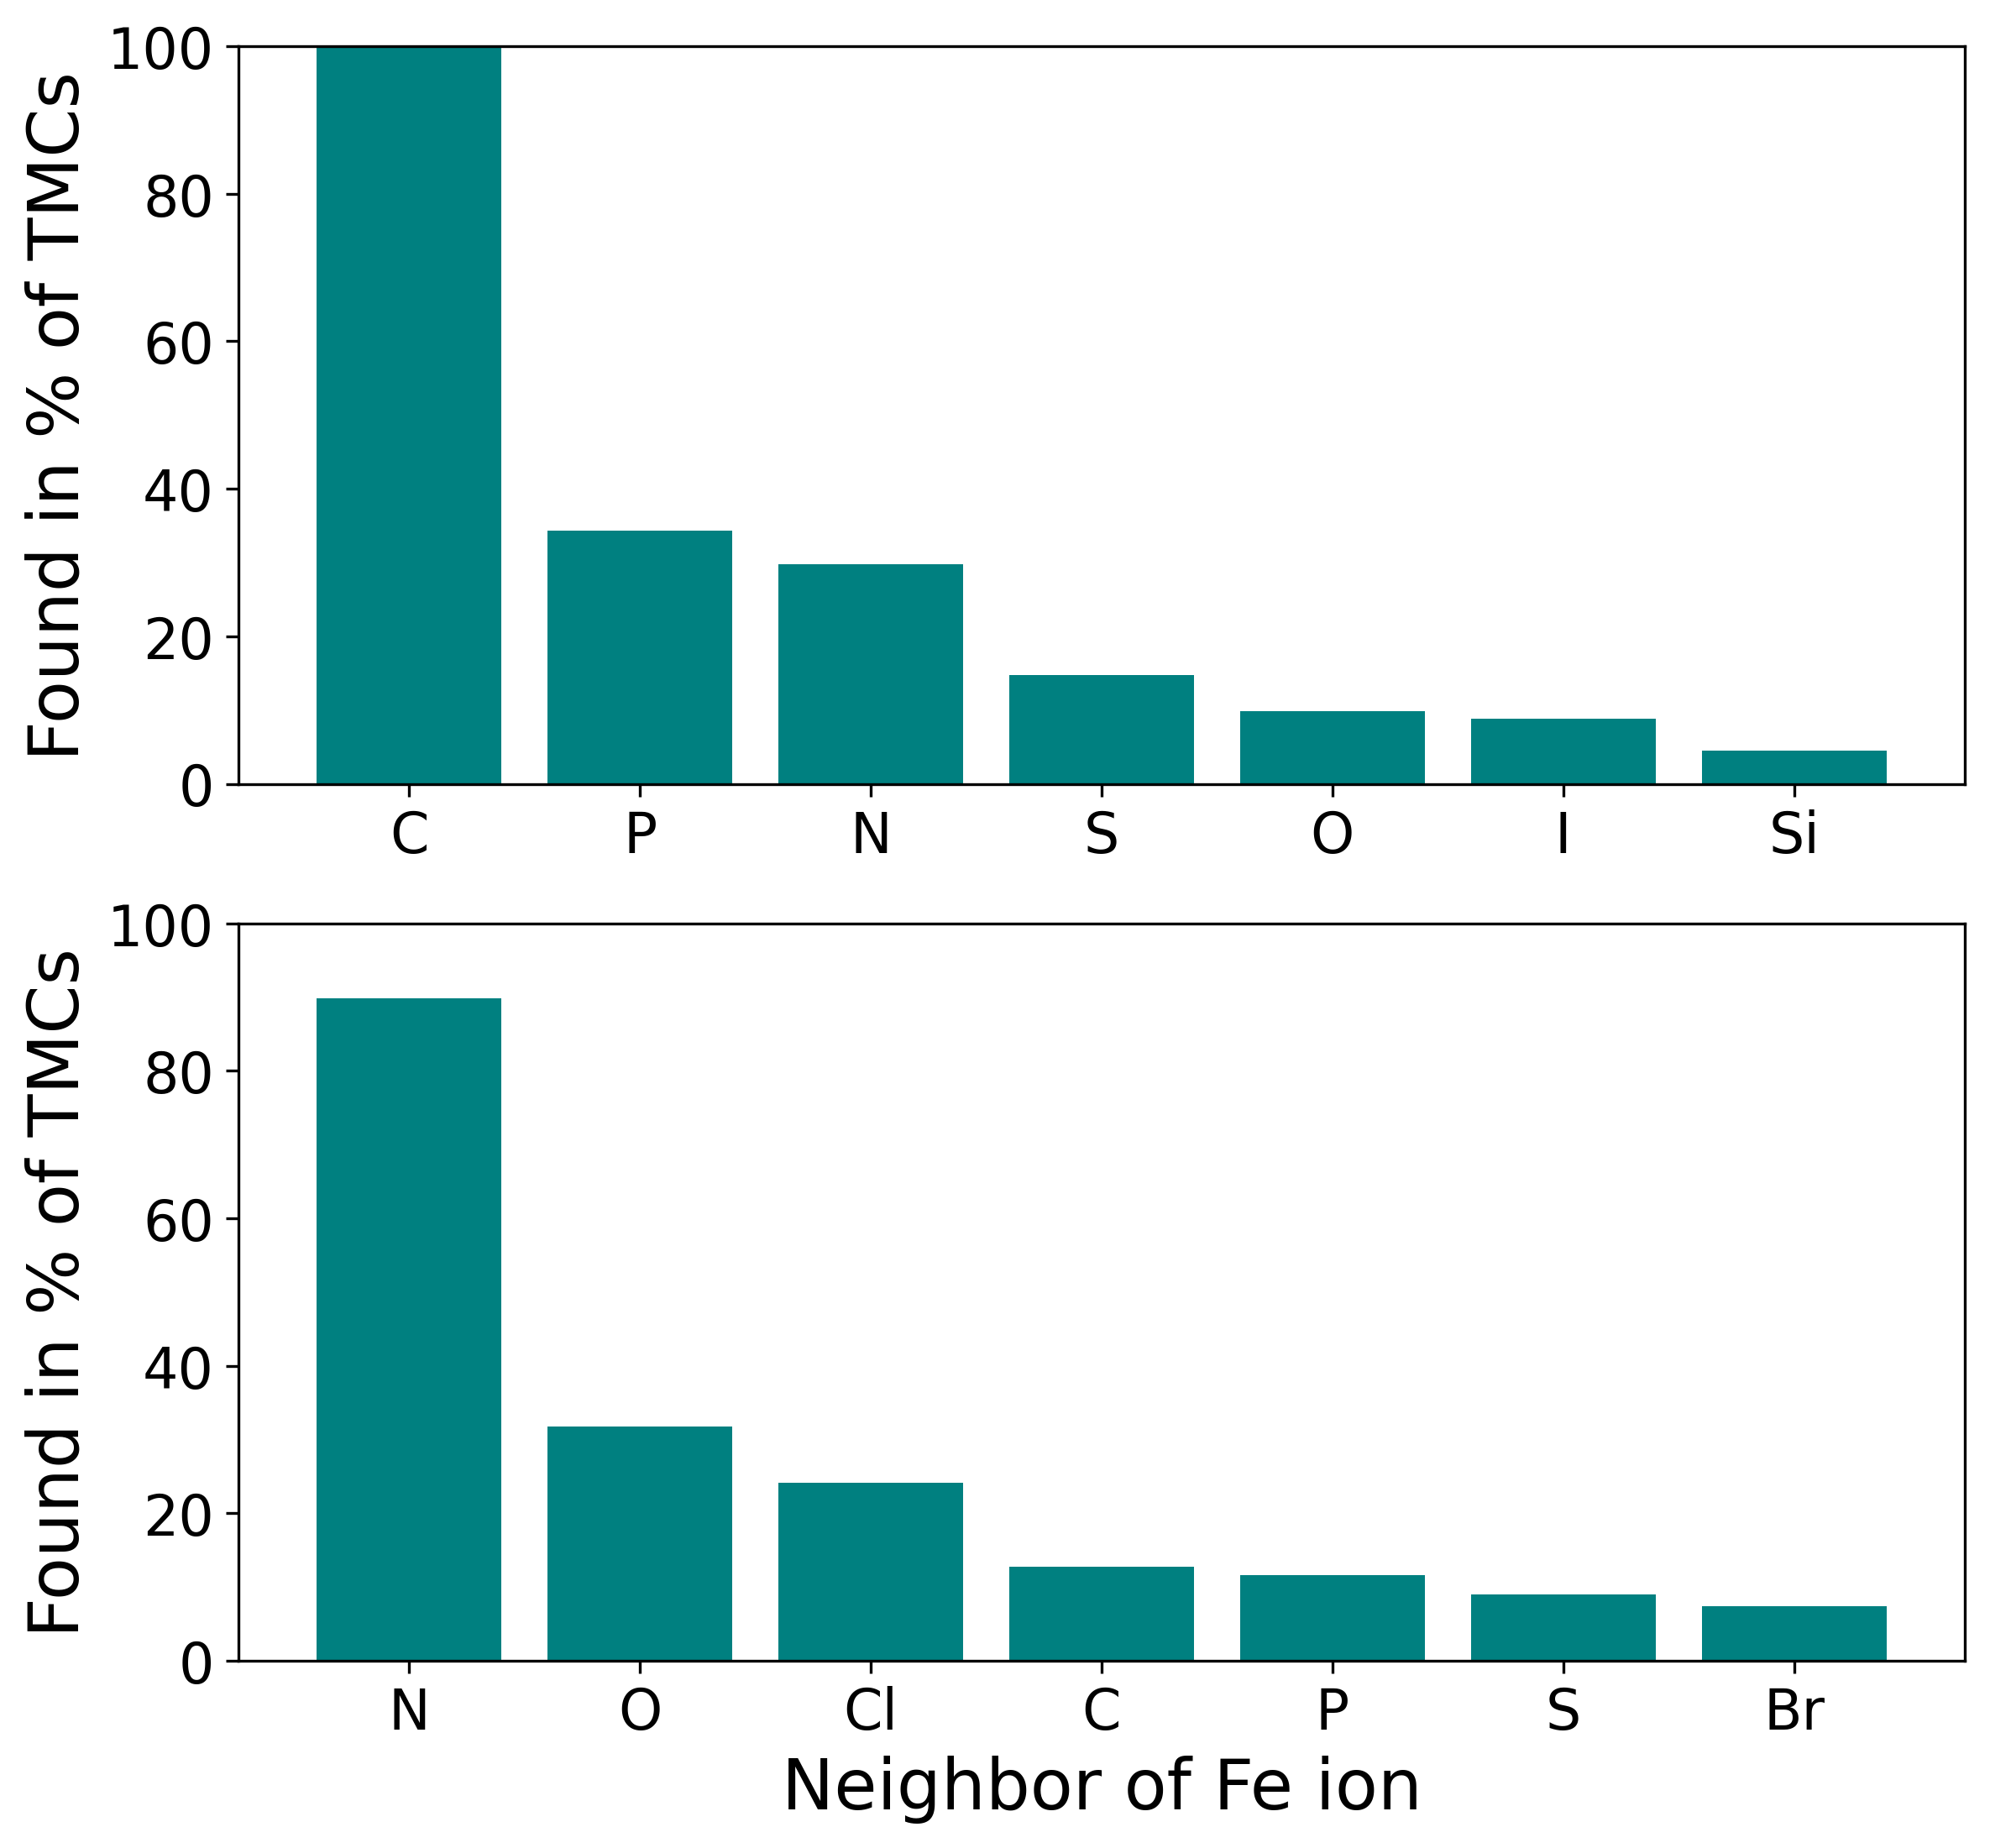

In [45]:
# Neighbor analysis around Fe

cluster_Fe_analysis = {} # Store results per cluster

for cluster_id in range(n_clusters):
    print(f"\nAnalyzing Cluster {cluster_id}...")

    # Get molecules belonging to the current cluster
    cluster_df = df2use[df2use['pca_cluster'] == cluster_id]
    cluster_mols = cluster_df['mol'].tolist()
    num_mols_in_cluster = len(cluster_mols)

    if num_mols_in_cluster == 0:
        print("  No molecules in this cluster. Skipping.")
        cluster_Fe_analysis[cluster_id] = {"count": 0, "top_groups": [], "frequencies": {}}
        continue

    print(f"  Found {num_mols_in_cluster} molecules.")

    # Initialize counts for this cluster
    # Use defaultdict for easier counting
    cluster_neigh_counts = defaultdict(int)

    # Iterate through molecules IN THIS CLUSTER
    for mol in cluster_mols:
        if not mol: continue # Skip None molecules if any

        # Iterate through the functional group checks
        for atom in mol.GetAtoms():
            if atom.GetSymbol() == 'Fe':
                # Get neighbors of the Fe atom
                neighbors = atom.GetNeighbors()
                neigh_symbol = set([neighbor.GetSymbol() for neighbor in neighbors])   # set() to get non-repeating neighs
                for neighbor in neigh_symbol:
                    # Increment the count for this neighbor type
                    cluster_neigh_counts[neighbor] += 1

    # --- Analyze and Store Results for the Cluster ---
    # Calculate frequency (%) of each group within this cluster
    cluster_frequencies = {
        name: (count / num_mols_in_cluster) * 100
        for name, count in cluster_neigh_counts.items()
    }

    # Sort frequencies to find top groups
    sorted_freqs = sorted(cluster_frequencies.items(), key=operator.itemgetter(1), reverse=True)

    # Store overall count and top N groups (e.g., top 5)
    cluster_Fe_analysis[cluster_id] = {
        "count": num_mols_in_cluster,
        "top_groups": sorted_freqs[:5], # Store top 5 groups/frequencies
        "frequencies": cluster_frequencies # Store all frequencies
    }

    print(f"  Top 5 Groups (Frequency %):")
    for name, freq in sorted_freqs[:5]:
        print(f"    - {name}: {freq:.1f}%")


print("\n--- Overall Cluster Fragment Analysis ---")
for cluster_id, analysis in cluster_Fe_analysis.items():
    print(f"Cluster {cluster_id} ({analysis['count']} molecules):")
    if analysis['top_groups']:
        top_str = ", ".join([f"{name} ({freq:.1f}%)" for name, freq in analysis['top_groups']])
        print(f"  Predominant groups: {top_str}")
    else:
        print("  No functional groups detected or no molecules in cluster.")

# --- Visualization per cluster ---

DPI = 300

num_plot_groups = 7 # Number of groups to show per cluster plot

fig, axes = plt.subplots(n_clusters, 1, figsize=(8, n_clusters * 4), sharex=False, dpi=DPI) # Adjust figsize
if n_clusters == 1: axes = [axes] # Make axes iterable if only 1 cluster

#fig.suptitle("Top Functional Group Frequencies per PCA Cluster", fontsize=16)

for cluster_id, analysis in cluster_Fe_analysis.items():
    ax = axes[cluster_id]
    if analysis['count'] > 0:
        # Sort all frequencies for plotting
        all_sorted_freqs = sorted(analysis['frequencies'].items(), key=operator.itemgetter(1), reverse=True)
        plot_names = [item[0] for item in all_sorted_freqs[:num_plot_groups]]
        plot_freqs = [item[1] for item in all_sorted_freqs[:num_plot_groups]]

        ax.bar(plot_names, plot_freqs, color='teal')
        ax.set_ylabel("Found in % of TMCs", fontsize = 20)
        #ax.set_title(f"Cluster {cluster_id+1} ({analysis['count']} TMCs)", fontsize = 20)
        ax.tick_params(axis='x', rotation=0, labelsize = 16)
        ax.tick_params(axis='y', labelsize = 16)
        ax.set_ylim([0,100])
        # Optional: Add frequency values on bars
        #for i, freq in enumerate(plot_freqs):
            #ax.text(i, freq, f'{freq:.1f}', ha='center', va='bottom')
    else:
        ax.set_title(f"Cluster {cluster_id} (Empty)")
        ax.text(0.5, 0.5, "No molecules", ha='center', va='center', transform=ax.transAxes)

plt.xlabel("Neighbor of Fe ion", fontsize = 20) # Common x-label
plt.tight_layout(rect=[0, 0.03, 1, 0.96]) # Adjust layout
plt.savefig('./Figures/Cluster_neighs.png', transparent=True, bbox_inches='tight')